In [1]:
import json, pathlib, random, time
from collections import defaultdict
import numpy as np
import pandas as pd
import multiprocessing as mp


In [2]:
with open('lists.json') as f:
    j = json.load(f)

target_list = j['target']
guess_list = j["guess"]


In [3]:
def char_freq(lst):
    hist = defaultdict(int)
    for word in lst:
        for char in word:
            hist[char] += 1
    mx = max(hist.values())
    for char in hist:
        hist[char] /= mx
    return hist

def print_char_freq(cf):
    for char in sorted(list(cf.keys())):
        print(f'{char}: {cf[char]}')
        
def freq_score(word, cf):
    return sum(cf[x] for x in word) / len(word) 

def uniq_score(word):
    return (len(word) - len(set(word))) / (len(word) - 2)

In [4]:

cf = char_freq(target_list)
#print_char_freq(cf)

In [5]:
print(random.choice(guess_list))
print(random.choice(target_list))

comes
dying


In [6]:
dfg = pd.DataFrame([[w, freq_score(w, cf), uniq_score(w), 1.0] for w in guess_list], columns=['word', 'freq_score', 'uniq_score', 'is_guess_word'])
dft = pd.DataFrame([[w, freq_score(w, cf), uniq_score(w), 0.0] for w in target_list], columns=['word', 'freq_score', 'uniq_score', 'is_guess_word'])
df = dfg.append(dft)
df.set_index('word', inplace=True)

In [7]:
df.iloc[2801]

freq_score       0.725547
uniq_score       1.000000
is_guess_word    1.000000
Name: esses, dtype: float64

In [8]:


def word_to_action(word, guesses, history):
    return dfword_to_action((word, df.loc[word]), guesses, history)
    
def dfword_to_action(dfword, guesses, history):
    #the action is going to be a word that we will submit next
    #for the purposes of feeding into the model, we will represent the action word as:
    #  how many of the entries in the hint history this word conforms to
    #  how many untried letters it gives us
    #  the number of uniq letters in the word
    #  the frequency of the letters in the word
    #  whether or not the word is in the guess list (as opposed to the target list)
    word = dfword[0]
    dfword = dfword[1]
    if guesses:
        conforms_to_history = sum([int(validate_against_hint(word,g,history[i])) for i,g in enumerate(guesses)]) / len(guesses)
    else: # we haven't made any guess yet, so this must conform
        conforms_to_history = 1.0
    num_untried_letters = len(set(word) - set(''.join(guesses))) / 5 #normalise to 1
    return np.array([conforms_to_history, num_untried_letters, dfword['freq_score'], dfword['uniq_score'], dfword['is_guess_word']])
    

In [50]:
df_global = None

def construct_actions_global(arg): #guesses, history, start_idx, end_idx):
    #global df_global
    guesses, history, start_idx, end_idx = arg
    #print(guesses, history, start_idx, end_idx)
    return np.array([dfword_to_action(dfword, guesses, history) for dfword in df.iloc[start_idx:end_idx].iterrows()])
    
class ActionSpace:
    def __init__(self, n):
        self.n = n
    
    
class Env:
    def __init__(self, df, target_word=None):
        self.df = df
        self.specified_target_word = False
        if target_word:
            self.specified_target_word = True
            self.target = target_word            
            
        self.reset()     
        self.num_letters = len(self.target)
        self.num_guesses = 6
        
        self.num_processes = mp.cpu_count() - 1
        self.action_space = ActionSpace(len(self.df))
       
        
    def index_from_word(self, word):
        return self.df.index.get_loc(word)
    
    def word_from_index(self, idx):
        return self.df.iloc[idx].name
    
    def submit_guess(self, guess):
        wrongplace = [0] * len(self.target)
        hints = np.zeros(len(self.target))
        rightplace = [guess[n] == chrt for n,chrt in enumerate(self.target)]
        #print(f'comparing {guess} against {self.target}.  rightplace {rightplace}')
        
        for n,chrt in enumerate(self.target):
            if rightplace[n] == 1: continue #this character has already been scored, skip it
            for m,chrg in enumerate(guess):
                if n == m: continue # we've already checked rightplace matches above
                if chrt != chrg: continue
                if wrongplace[m] == 1: continue
                if rightplace[m] == 1: continue
                
                wrongplace[m] = 1
                break

        for i in range(len(self.target)):
            hints[i] = 2 if rightplace[i] == 1 else wrongplace[i]
        
        return hints
    
    def reset(self):
        self.history = np.array([[]])
        self.guesses = []
        if not self.specified_target_word:
            self.target = df[df['is_guess_word'] == 0.0].sample().iloc[0].name
            
    def construct_actions(self):
        return np.array([dfword_to_action(dfword, self.guesses, self.history) for dfword in self.df.iterrows()])
    
    def construct_actions_mp(self):
        #global df_global
        
        grp_lst_args = []
        grp_guesses = [self.guesses] * self.num_processes
        grp_history = [self.history] * self.num_processes
        
        #df_global = self.df
        chunk_size = int(len(self.df) / self.num_processes) + 1
        start_offsets = list(range(0, len(self.df), chunk_size))
        end_offsets = start_offsets[1:] + [len(self.df)]
        grp_lst_args = list(zip(grp_guesses, grp_history, start_offsets, end_offsets))
        
        #print(grp_lst_args)
        self.pool = mp.Pool(processes=self.num_processes)
        results = self.pool.map(construct_actions_global, grp_lst_args)
        self.pool.close()
        self.pool.join()
        return np.concatenate(results)
    
    def construct_state(self):
        #print(history)
        #so the state is going to be:
            #  The number of green locations we know
            #  The number of other letters we know to be in the word
            #  The sequence number of the guess (1st guess, 2nd guess etc.)

        #the number of locations which were green at some point in the history
        num_green_locs = np.count_nonzero(self.history.max(axis=0) == 2)

        green_chars = [self.guesses[x][y] for x,y in np.argwhere(self.history == 2) ]
        orange_chars = [self.guesses[x][y] for x,y in np.argwhere(self.history == 1) ]
        num_other_letters = len(set(orange_chars) - set(green_chars))

        sequence_number = self.history.size / 5

        return np.array([num_green_locs, num_other_letters, sequence_number]) / 5

    def step_by_index(self, guess_idx):
        return self.step(self.word_from_index(guess_idx))
    
    
    def step(self, guess): #returns state, reward, done, actions
        #print(actions)
        hints = self.submit_guess(guess)

        #print(list(zip(self.guesses,self.history)))
        if self.history.size == 0:
            self.history = np.expand_dims(hints,0)
            best_hints = 0
        else:
            best_hints = np.apply_along_axis(np.sum, 1, self.history).max()
            self.history = np.row_stack([self.history, hints])
            
        print(f'======={guess} ({self.target}) => {hints}= {best_hints} =======')
        
        self.guesses.append(guess)
        reward = max(0, hints.sum() - best_hints)
        done = (hints.sum() == self.num_letters * 2 or len(self.guesses) == self.num_guesses)
    
        state = self.construct_state() 
        actions = self.construct_actions_mp()
        return state, reward, done, actions

    
def hint_to_hinty(hint):
    #hint takes form [0,1,2,1,0]
    #hinty takes form {2:[2], 1:[1,3], 0:[0,4]}
    hinty = {}
    for n in [0,1,2]:
        hinty[n] = [i for i, x in enumerate(hint) if x == n]
    #print(f'hint_to_hinty() {hint}, {hinty}')
    return hinty
    
def validate_against_hint(word, guess, hint):
    return validate_against_hinty(word, guess, hint_to_hinty(hint))

def validate_against_hinty(word, guess, hinty):
    #hinty takes form {2:[idx,..], 1:[idx,..], 0:[idx,..]}
    for idx in hinty[2]: # check the fixed letters first
        if word[idx] != guess[idx]:
            return False
    for idx in hinty[0]:
        #get the number of times char appears in target word (minus the times it appears in the correct location)
        indices = [i for i,x in enumerate(word) if x == guess[idx] and i not in hinty[2]]
        #get number of times char appears in guess word in the wrong location
        indices_g = [n for n,x in enumerate(guess) if x == guess[idx] and n in hinty[1]]
        #we already know that there is one not-exist hint for this char, so
        #if there are more fewer wrong location hints for this letter than there are actual occurrences of the letter
        #then the hint does not validate against this word
        if len(indices) > len(indices_g):
            return False
    for idx in hinty[1]:
        if word[idx] == guess[idx]:
            return False
        #get all the indices of the character in the target word
        indices = [i for i,x in enumerate(word) if x == guess[idx] and i not in hinty[2]]
        #remove all the indices where there is already a fixed position hint
        
        #now count all the occurences of the char in guess where the location is wrong
        indices_g = [i for i,x in enumerate(guess) if x == guess[idx] and i in hinty[1]]
        #if there are more wrong loc hints for this char than there are actual occurrences, then it must be bogus
        if len(indices) < len(indices_g):
            return False
    return True            
    

In [10]:
e = Env(df)
e.reset()
st = time.time()
rmp = e.construct_actions_mp()
print(time.time() - st)
e.reset()
st = time.time()
r = e.construct_actions()
print(time.time() - st)

print(r.__class__)
print(r.shape)

print(rmp.__class__)
print(rmp.shape)

print((r == rmp).all())


0.23499727249145508
0.6346826553344727
<class 'numpy.ndarray'>
(12972, 5)
<class 'numpy.ndarray'>
(12972, 5)
True


In [11]:
e_simple = Env(target_list, target_word='abcde')
tests_simple = {'abcde': [2,2,2,2,2],
         'acbde': [2,1,1,2,2],
         'azcde': [2,0,2,2,2],
         'aacde': [2,0,2,2,2],
         'zacde': [0,1,2,2,2],
         'zzdzz': [0,0,1,0,0],
         'zzddz': [0,0,0,2,0],
         'zdddz': [0,0,0,2,0],
         'ddddd': [0,0,0,2,0],
         'zzzdd': [0,0,0,2,0],
         'zzdez': [0,0,1,1,0]}

e_repeat = Env(target_list, target_word='abcae')
tests_repeat = {'abcde': [2,2,2,0,2],
         'acbde': [2,1,1,0,2],
         'azcde': [2,0,2,0,2],
         'aacde': [2,1,2,0,2],
         'zacde': [0,1,2,0,2],
         'zzdzz': [0,0,0,0,0],
         'zzddz': [0,0,0,0,0],
         'zdddz': [0,0,0,0,0],
         'ddddd': [0,0,0,0,0],
         'zzzdd': [0,0,0,0,0],
         'zzdez': [0,0,0,1,0],
         'aaaaa': [2,0,0,2,0],
         'aaaza': [2,1,0,0,0],
         'zaazz': [0,1,1,0,0],
         'zaaza': [0,1,1,0,0]}

for e,tests in [(e_simple, tests_simple),(e_repeat, tests_repeat)]:
    for guess,expected in tests.items():
        #guess = random.choice(guess_list + target_list)
        actual = e.submit_guess(guess)
        hinty = hint_to_hinty(expected)
        hinty_valid = validate_against_hinty(e.target, guess, hinty)
        print(e.target, guess, actual, expected, expected == actual, hinty_valid)

abcde abcde [2. 2. 2. 2. 2.] [2, 2, 2, 2, 2] [ True  True  True  True  True] True
abcde acbde [2. 1. 1. 2. 2.] [2, 1, 1, 2, 2] [ True  True  True  True  True] True
abcde azcde [2. 0. 2. 2. 2.] [2, 0, 2, 2, 2] [ True  True  True  True  True] True
abcde aacde [2. 0. 2. 2. 2.] [2, 0, 2, 2, 2] [ True  True  True  True  True] True
abcde zacde [0. 1. 2. 2. 2.] [0, 1, 2, 2, 2] [ True  True  True  True  True] True
abcde zzdzz [0. 0. 1. 0. 0.] [0, 0, 1, 0, 0] [ True  True  True  True  True] True
abcde zzddz [0. 0. 0. 2. 0.] [0, 0, 0, 2, 0] [ True  True  True  True  True] True
abcde zdddz [0. 0. 0. 2. 0.] [0, 0, 0, 2, 0] [ True  True  True  True  True] True
abcde ddddd [0. 0. 0. 2. 0.] [0, 0, 0, 2, 0] [ True  True  True  True  True] True
abcde zzzdd [0. 0. 0. 2. 0.] [0, 0, 0, 2, 0] [ True  True  True  True  True] True
abcde zzdez [0. 0. 1. 1. 0.] [0, 0, 1, 1, 0] [ True  True  True  True  True] True
abcae abcde [2. 2. 2. 0. 2.] [2, 2, 2, 0, 2] [ True  True  True  True  True] True
abcae acbde [2. 

In [12]:
e=Env(df)
for _ in range(10):
    n = random.randint(0, len(e.df))
    w = e.word_from_index(n)
    n_ = e.index_from_word(w)
    print(f'{n}, {w}, {n_}')
    assert(n == n_)
    

6832, pingo, 6832
6651, pawaw, 6651
12071, below, 12071
10374, xylem, 10374
1783, comms, 1783
8405, slaps, 8405
8520, snoot, 8520
10720, drain, 10720
9487, trabs, 9487
3271, fudgy, 3271


In [13]:
def random_guess(guess_list, target_list):
    guess_idx = random.randint(0, len(guess_list) + len(target_list))
    is_guess = guess_idx < len(guess_list)
    if is_guess:
        word = guess_list[guess_idx]
    else:
        word = target_list[guess_idx - len(guess_list)]
    return word, is_guess

In [14]:
#'beast'
e = Env(df, target_word='beast')
e.step('treat')
#e.guesses = ['treat']
#e.history = np.array([[0.0, 0.0, 1.0, 1.0, 2.0]])
#Env(target_list, target_word='beast').submit_guess('treat')
print(e.guesses, e.history)
actual = e.construct_state()
expected = [0.2, 0.4, 0.2]
print(expected, actual, expected == actual)

actual = word_to_action('feast', ['treat'], np.array([[0.0, 0.0, 1.0, 1.0, 2.0]]))
expected = [1.0, 0.4, 0.62287105, 0.0, 0.0]
print(expected, actual, expected == actual)


=======treat (beast) => [0. 0. 1. 1. 2.]= 0 =======
['treat'] [[0. 0. 1. 1. 2.]]
[0.2, 0.4, 0.2] [0.2 0.4 0.2] [ True  True  True]
[1.0, 0.4, 0.62287105, 0.0, 0.0] [1.         0.4        0.62287105 0.         0.        ] [ True  True False  True  True]


In [15]:
num_guesses = 6
e = Env(df)

print(e.target)
num_letters = len(e.target)
history = np.array([[]])
guesses = []
rewards = []
for i in range(num_guesses):
    #guess, is_guess_list = random_guess(guess_list, target_list)
    actions = e.construct_actions_mp()
    state = e.construct_state()
    #here feed it into a model to choose the word
    #guess, value = np.argmax(model(state)) # but do this epsilon greedy
    
    #print(actions)
    hints = e.submit_guess(guess)
    
    print(f'======={guess}========')
    print(list(zip(guesses,history)))
    if history.size == 0:
        history = np.expand_dims(hints,0)
    else:
        history = np.row_stack([history, hints])
    guesses.append(guess)
    if hints.sum() == num_letters * 2 or i == num_guesses - 1:
        reward = hints.sum()
        done = True
    else:
        reward = -1
        done = False
    
    

    
#so the state is going to be:
#  The number of green locations we know
#  The number of other letters we know to be in the word
#  The sequence number of the guess (1st guess, 2nd guess etc.)

#the action is going to be a word that we will submit next
#for the purposes of feeding into the model, we will represent the action word as:
#  whether or not it conforms to the hint history
#  how many new letters it gives us
#  the number of uniq letters in the word
#  the frequency of the letters in the word

#the reward is going to be:
#  -1 on all states except the last one
#  on the last state (which can either be after guess 6 or on guessing the correct word):
#    the sum of the last hint (ie. 2 for a correct letter/position combo, 1 for a letter in the wrong place)

troop
=======zaaza========
[]
=======zaaza========
[('zaaza', array([0., 0., 0., 0., 0.]))]
=======zaaza========
[('zaaza', array([0., 0., 0., 0., 0.])), ('zaaza', array([0., 0., 0., 0., 0.]))]
=======zaaza========
[('zaaza', array([0., 0., 0., 0., 0.])), ('zaaza', array([0., 0., 0., 0., 0.])), ('zaaza', array([0., 0., 0., 0., 0.]))]
=======zaaza========
[('zaaza', array([0., 0., 0., 0., 0.])), ('zaaza', array([0., 0., 0., 0., 0.])), ('zaaza', array([0., 0., 0., 0., 0.])), ('zaaza', array([0., 0., 0., 0., 0.]))]
=======zaaza========
[('zaaza', array([0., 0., 0., 0., 0.])), ('zaaza', array([0., 0., 0., 0., 0.])), ('zaaza', array([0., 0., 0., 0., 0.])), ('zaaza', array([0., 0., 0., 0., 0.])), ('zaaza', array([0., 0., 0., 0., 0.]))]


In [16]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def clear(self):
        self.memory.clear()
        
    def __len__(self):
        return len(self.memory)
    

In [18]:
class DQN(nn.Module):

    def __init__(self, inputs):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 20)
        self.fc2 = nn.Linear(20, 16)
        self.fc3 = nn.Linear(16, 20)
        self.head = nn.Linear(20, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.head(x)

In [54]:
env = Env(df)
class NaiveModel():
    def __init__(self, startword_idx=None, target_list_only=False):
        self.startword_idx = startword_idx
        self.target_list_only = target_list_only #when guessing, only choose from the target list (not the full guess list)
        
    def guess(self, idx, state_action):
        if state_action[2] == 0: #if this is the first guess
            return 
    
    def conforms_to_history(state_action):
        return state_action[3] == 1.0
    
    def is_in_target_list(state_action):
        return state_action[7] == 0.0
                
    def __call__(self, x): # we must return the value of each action
        #x will be a batch
        # if this is the first guess, we must return 1 for the chosen startword
        print(f'startword analysis {x[0]} {x[0].__class__}')
        if x[0][2] == 0.0: #if this is the first guess
            if self.startword_idx: # if we have specified a starting word
                choice = self.startword_idx
                print(f'choosing fixed startword at {choice}')
            else:  #chose a random startword
                choice = random.randint(0,len(x))
                print(f'choosing random word at {choice}')
        else:
            #choose a random startword from the words that conform to the history
            
            conformant_indices = [idx for idx, state_action in enumerate(x) if NaiveModel.conforms_to_history(state_action)]
            if self.target_list_only:
                conformant_indices = [idx for idx in conformant_indices if NaiveModel.is_in_target_list(x[idx])]
            choice = random.sample(conformant_indices, 1)[0]
            print(f'choosing conformant word at {choice} from {len(conformant_indices)} conformant words')   

        print(f'word at {choice} is {env.word_from_index(choice)}')
        ret = torch.zeros(len(x))
        ret[choice] = 1.0
        return ret
    
    def parameters(self):
        return []
    
    def to(self, device):
        return self
        

In [ ]:





# Get number of actions from gym action space
#n_actions = env.action_space.n
n_action_features = 5
n_state_features = 3
n_input_features = n_action_features + n_state_features




#target_net = DQN(n_input_features).to(device)
#target_net.load_state_dict(policy_net.state_dict())
#target_net.eval()






def select_action(policy_net, state, actions, eps_threshold):
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            #now combine the state (shape 3,) and action (shape 5, n) into one input array (shape 8,n)
            #first expand the state so that it is shape 3,1
            #then repeat it to 3,n
            states = np.repeat(np.expand_dims(state, 0), actions.shape[0], axis=0)
            #print(f'states shape {states.shape} actions shape {actions.shape}')
            #then concatenate to 8,n
            state_actions = np.concatenate((states, actions), axis=1)
            # policy_net(state_action) will return a single value estimate for each state/action row
            # so, probably shape (1,n)
            # Then return the index which has the max value
            
            estimate = policy_net(torch.tensor(state_actions, device=device, dtype=torch.float))
            #print(f'ESTIMATE>>>{estimate.__class__} {estimate.shape} {estimate} {estimate.max(0).indices.item()}<<<')
            return estimate.max(0).indices.item()
    else:
        randindex = random.randrange(len(actions))
        print(f'returning random index {randindex}')
        return randindex #torch.tensor([[randindex]], device=device, dtype=torch.long)



def plot_values(vals, axes=['duration', 'episode']):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel(axes[1])
    plt.ylabel(axes[0])
    plt.plot(np.array(vals))
    # Take 20 episode averages and plot them too
    window_width = 20
    cumsum_vec = np.cumsum(np.insert(vals, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    if len(vals) >= 20:
    #    means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
    #    means = torch.cat((torch.zeros(99), means))
        plt.plot(ma_vec)

    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())
    
def plot_all(episode_durations, episode_rewards, losses):
    plot_values(episode_durations, axes=['duration', 'episode'])
    plot_values(episode_rewards, axes=['reward', 'episode'])
    if losses: plot_values(losses, axes=['loss', 'step'])
    #plt.ioff()
    plt.show()

In [78]:
def optimize_model(model, optimizer, memory, batch_size=128):

    transitions = memory.sample(batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    state_batch = np.stack([tr.state for tr in transitions])
    action_batch = np.stack([tr.action for tr in transitions])
      
    reward_batch = np.stack([tr.reward for tr in transitions])
    state_action_batch = np.concatenate((state_batch, action_batch), axis=1)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_value_estimates = model(torch.tensor(state_action_batch, device=device, dtype=torch.float))
    #print(f'ESTIMATE>>>{estimate.__class__} {estimate.shape} {estimate} {estimate.max(0).indices.item()}<<<')
       
    expected_state_action_values = torch.tensor(reward_batch, device=device, dtype=torch.float)
    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_value_estimates, expected_state_action_values)
    
    print(f'loss {loss}')

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return loss


In [126]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
def run_experiment(model={'name':'naive', 'startword':None, 'target_list_only':False},
                   num_episodes=128,
                   batch_size=128,
                   eps=[0.9, 0.05, 200],
                   gamma=0.999,
                   value_function='reward'):
    BATCH_SIZE = batch_size
    EPS_START = eps[0]
    EPS_END = eps[1]
    EPS_DECAY = eps[2]
    GAMMA = gamma
    env = Env(df)
    memory = ReplayMemory(10000)
    starting_actions = env.construct_actions()
    starting_state = env.construct_state()

    steps_done = 0
    losses = []
    episode_rewards = []
    episode_durations = []
    
    if model['name']=='naive':
        startword_idx = env.index_from_word(model['startword']) if model['startword'] else None
        
        policy_net = NaiveModel(startword_idx=startword_idx, target_list_only=model['target_list_only'])
        optimizer = None
        EPS_START = 0
        EPS_END = 0
    else:
        policy_net = DQN(n_input_features).to(device)
        optimizer = optim.RMSprop(policy_net.parameters())

    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        print(f'=========================episode {i_episode} {env.target}======================')

        episode_memory = []
        state = starting_state
        actions = starting_actions
        for t in count():
            eps = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
            steps_done += 1
            # Select and perform an action
            #print(state, actions)
            action_idx = select_action(policy_net, state, actions, eps)
            selected_action = actions[action_idx]
            print(f'------guess {t} {action_idx} {env.word_from_index(action_idx)} {selected_action}-------')
            next_state, reward, done, actions = env.step_by_index(action_idx)
            print(f'reward {reward} done {done} ')
            reward = np.array([reward])

            # Store the transition in memory
            #memory.push(state, selected_action, reward)
            episode_memory.append([state, selected_action, reward])
            # Move to the next state
            state = next_state

            if done:
                episode_durations.append(t + 1)
                episode_reward = sum([tr[2] for tr in episode_memory])
                print(f'episode finished.  reward {episode_reward} eps {eps}')
                episode_rewards.append(episode_reward)
                if value_function == 'reward':
                    for tr in episode_memory:
                        memory.push(*tr)
                elif value_function == 'hybrid':
                    #use the returned reward,
                    #but reduce it if we didn't get the target word by the end of the episode
                    #and increase it if we took less than 6 guesses
                    if episode_reward == 10.0: # if we got the target word
                        factor = 1.0 + (env.num_guesses - (t+1)) * 0.33 * GAMMA # 1.0, 1.1, 1.2 ... 1.5
                    else:
                        factor = 1.0 - 1.0 * GAMMA
                        for tr in episode_memory:
                            memory.push(tr[0], tr[1], tr[2]*factor)
                    print(f'hybrid rewards {[tr[2]*factor for tr in episode_memory]} vs. {[tr[2] for tr in episode_memory]}')    
                elif value_function == 'discounted':
                    #q is the actual value of the state_action value function
                    # which is the discounted reward.
                    #on the last guess q(n) is equal to the total episode reward 
                    #and q(n-1) is equal to -1 + episode_reward * GAMMA.
                    #and q(n-2) = -1 + (n-1) * GAMMA
                    #min(q) = -6 (for GAMMA = 1)
                    #max(q) = 10
                    q = episode_reward
                    qs = []
                    if episode_reward < 10: q = q * 0.7 #reduce the reward if we didn't get the correct answer
                    for idx,tr in enumerate(reversed(episode_memory)):
                        if idx > 0:
                            q = -1 + GAMMA * q
                        memory.push(tr[0], tr[1], (q + 6)) # add 6 on to the value so that it is never < 0 
                        qs.append(q+6)
                    print(f'discounted rewards {list(reversed(qs))} vs. {[tr[2] for tr in episode_memory]}')
                else:
                    raise Exception(f'bad value function {value_function}')

                # If we have gathered enough data, Perform one step of the optimization (on the policy network)
                if model['name'] != 'naive' and len(memory) >= BATCH_SIZE:
                    loss = optimize_model(policy_net, optimizer, memory, batch_size=BATCH_SIZE)
                    losses.append(loss)
                    memory.clear()
                #plot_durations()
                break

    print('Complete')
    
    return episode_durations, episode_rewards, losses

#env.render()
#env.close()
#plt.ioff()
#plt.show()

=========================episode 0 brick======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 4156
word at 4156 is hoosh
------guess 0 4156 hoosh [1.         0.6        0.47931873 0.66666667 1.        ]-------
=======hoosh (brick) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.2000, 0.0000, 0.6000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 9489 from 4089 conformant words
word at 9489 is tragi
------guess 1 9489 tragi [1.         1.         0.58215734 0.         1.        ]-------
=======tragi (brick) => [0. 2. 0. 0. 1.]= 0.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.2000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.4000, 0.4000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 7854 from 21 conformant words
word at 7854 is sairs
------guess 2 7854 sairs [1.         0.2        0.63049473 0.33333333 1.        ]-------
=======sairs (rabbi) => [0. 2. 1. 1. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.4000, 0.6000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11706 from 1 conformant words
word at 11706 is rabbi
------guess 3 11706 rabbi [1.         0.2        0.50462287 0.33333333 0.        ]-------
=======rabbi (rabbi) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 5 model======================
states shape (12972, 3) actions shape (12972, 5)
startw

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.4000, 1.0000, 0.2000, 0.0000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 9848 from 3 conformant words
word at 9848 is valse
------guess 5 9848 valse [1.         0.4        0.60875912 0.         1.        ]-------
=======valse (lapse) => [0. 2. 1. 2. 2.]= 4.0 =======
reward 3.0 done True 
episode finished.  reward [7.] eps 0.0
=========================episode 9 fewer======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 2629
word at 2629 is dzhos
------guess 0 2629 dzhos [1.         1.         0.36415247 0.         1.        ]-------
=======dzhos (fewer) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.4000, 0.0000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 9594 from 93 conformant words
word at 9594 is tules
------guess 1 9594 tules [1.         0.6        0.61914031 0.         1.        ]-------
=======tules (melee) => [0. 0. 2. 2. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.4000, 0.0000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 3442 from 27 conformant words
word at 3442 is gelee
------guess 2 3442 gelee [1.         0.2        0.76707218 0.66666667 1.        ]-------
=======gelee (melee) => [0. 2. 2. 2. 2.]= 4.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 0.6000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tens

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.2000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 5399 from 3111 conformant words
word at 5399 is luxed
------guess 1 5399 luxed [1.        1.        0.4621249 0.        1.       ]-------
=======luxed (equal) => [1. 1. 0. 1. 0.]= 0.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.6000, 0.4000, 0.5000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 3205 from 19 conformant words
word at 3205 is foule
------guess 2 3205 foule [1.         0.4        0.55198702 0.         1.        ]-------
=======foule (equal) => [0. 0. 2. 1. 1.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.4000, 0.6000, 0.3333, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.6000, 0.2000, 0.8000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10700 from 2 conformant words
word at 10700 is repay
------guess 4 10700 repay [1.         0.2        0.63309002 0.         0.        ]-------
=======repay (repay) => [2. 2. 2. 2. 2.]= 7.0 =======
reward 3.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 22 racer======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 10205
word at 10205 is whift
------guess 0 10205 whift [1.         1.         0.35912409 0.         1.        ]-------
=======whift (racer) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 1.0000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12037 from 1 conformant words
word at 12037 is speed
------guess 5 12037 speed [1.         0.2        0.63179238 0.33333333 0.        ]-------
=======speed (speed) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 26 gloat======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 11207
word at 11207 is crave
------guess 0 11207 crave [1.         1.         0.60681265 0.         0.        ]-------
=======crave (gloat) => [0. 0. 1. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.00

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.4000, 0.4000, 0.5000, 0.6000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 5860 from 273 conformant words
word at 5860 is morel
------guess 2 5860 morel [1.         0.6        0.63600973 0.         1.        ]-------
=======morel (lover) => [0. 2. 1. 2. 1.]= 2.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.4000, 0.4000, 0.6000, 0.3333, 0.6000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 5273 from 4 conformant words
word at 5273 is loner
------guess 3 5273 loner [1.         0.2        0.67802109 0.         1.        ]-------
=======loner (lover) => [2. 2. 0. 2. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 0.8000, 0.2500, 0.6000, 0.6444, 0.3333, 1.0000]) <class 'torch.Te

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.2000, 0.2000, 0.0000, 0.6000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 8934 from 204 conformant words
word at 8934 is swabs
------guess 1 8934 swabs [1.         0.6        0.45304136 0.33333333 1.        ]-------
=======swabs (habit) => [0. 0. 1. 1. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.4000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12354 from 48 conformant words
word at 12354 is abbot
------guess 2 12354 abbot [1.         0.4        0.49051095 0.33333333 0.        ]-------
=======abbot (habit) => [1. 0. 2. 0. 2.]= 2.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.4000, 0.2000, 0.6000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torc

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.4000, 0.2000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11854 from 2 conformant words
word at 11854 is credo
------guess 2 11854 credo [1.         0.4        0.60924574 0.         0.        ]-------
=======credo (credo) => [2. 2. 2. 2. 2.]= 5.0 =======
reward 5.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 39 spook======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 4155
word at 4155 is hoors
------guess 0 4155 hoors [1.         0.8        0.5620438  0.33333333 1.        ]-------
=======hoors (spook) => [0. 1. 2. 0. 1.]= 0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000,

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.4000, 0.2000, 0.6000, 0.3333, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11763 from 7 conformant words
word at 11763 is gaunt
------guess 3 11763 gaunt [1.         0.4        0.49651257 0.         0.        ]-------
=======gaunt (daunt) => [0. 2. 2. 2. 2.]= 5.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 0.8000, 0.2500, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 6075 from 6 conformant words
word at 6075 is naunt
------guess 4 6075 naunt [1.         0.         0.53933496 0.33333333 1.        ]-------
=======naunt (daunt) => [0. 2. 2. 2. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 1.0000, 0.2000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Ten

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.4000, 0.8000, 0.2500, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 420 from 6 conformant words
word at 420 is argot
------guess 4 420 argot [1.         0.4        0.59562044 0.         1.        ]-------
=======argot (abort) => [2. 1. 0. 1. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.4000, 0.4000, 1.0000, 0.2000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12012 from 2 conformant words
word at 12012 is abort
------guess 5 12012 abort [1.         0.2        0.59075426 0.         0.        ]-------
=======abort (abort) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 47 float======================
states shape (12972, 3) actions shape (12972, 5)
startwo

reward 5.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 51 tiara======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 2228
word at 2228 is deros
------guess 0 2228 deros [1.         1.         0.64038929 0.         1.        ]-------
=======deros (tiara) => [0. 0. 1. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.2000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 9692 from 404 conformant words
word at 9692 is ulnar
------guess 1 9692 ulnar [1.         0.8        0.59026764 0.         1.        ]-------
=======ulnar (tiara) => [0. 0. 0. 1. 1.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.2000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10956 from 77 conformant words
word at 10956 is stair
------guess 2 10956 stair [1.         0.6        0.64022709 0.         0.        ]-------
=======stair (scald) => [2. 0. 2. 0. 0.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.4000, 0.0000, 0.6000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10950 from 25 conformant words
word at 10950 is shawl
------guess 3 10950 shawl [1.         0.6        0.47866991 0.         0.        ]-------
=======shawl (scald) => [2. 0. 2. 0. 1.]= 4.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.4000, 0.2000, 0.8000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'to

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.4000, 0.4000, 0.6000, 0.0000, 0.6000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 8838 from 7 conformant words
word at 8838 is strad
------guess 3 8838 strad [1.         0.2        0.59513382 0.         1.        ]-------
=======strad (stray) => [2. 2. 2. 2. 0.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 0.8000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11256 from 5 conformant words
word at 11256 is stray
------guess 4 11256 stray [1.         0.2        0.60032441 0.         0.        ]-------
=======stray (stray) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 60 hardy======================
states shape (12972, 3) actions shape (12972, 5)
star

reward 7.0 done True 
episode finished.  reward [10.] eps 0.0
Complete


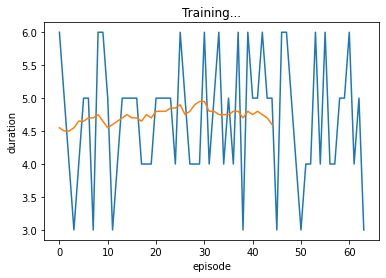

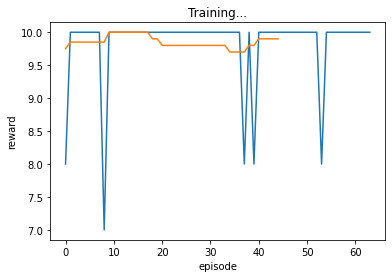

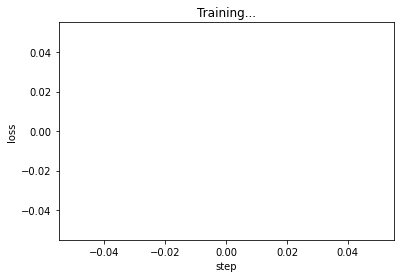

In [61]:
plot_all(*run_experiment(
    model={'name': 'naive', 'startword': None, 'target_list_only':False},
    num_episodes=64
    ))


=========================episode 0 imbue======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 7670
word at 7670 is rondo
------guess 0 7670 rondo [1.         0.8        0.54744526 0.33333333 1.        ]-------
=======rondo (imbue) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.2000, 0.0000, 0.6000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12038 from 630 conformant words
word at 12038 is gipsy
------guess 1 12038 gipsy [1.         1.         0.39626926 0.         0.        ]-------
=======gipsy (imbue) => [0. 1. 0. 0. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.2000, 0.4000, 0.0000, 0.6000, 0.6444, 0.3333, 1.0000]) <clas

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 0.6000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12060 from 1 conformant words
word at 12060 is burly
------guess 3 12060 burly [1.         0.2        0.45271695 0.         0.        ]-------
=======burly (burly) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 6 stunt======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 2265
word at 2265 is dibbs
------guess 0 2265 dibbs [1.         0.8        0.37226277 0.33333333 1.        ]-------
=======dibbs (stunt) => [0. 0. 0. 0. 1.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.6000, 0.0000, 1.0000, 0.0000, 0.0000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11807 from 1 conformant words
word at 11807 is diary
------guess 5 11807 diary [1.         0.4        0.54614761 0.         0.        ]-------
=======diary (diary) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 11 waltz======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 6984
word at 6984 is pooka
------guess 0 6984 pooka [1.         0.8        0.49699919 0.33333333 1.        ]-------
=======pooka (waltz) => [0. 0. 0. 0. 1.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000,

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.2000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11680 from 15 conformant words
word at 11680 is dingo
------guess 1 11680 dingo [1.         0.6        0.43860503 0.         0.        ]-------
=======dingo (midst) => [1. 2. 0. 0. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.2000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10987 from 4 conformant words
word at 10987 is midst
------guess 2 10987 midst [1.         0.6        0.45060827 0.         0.        ]-------
=======midst (midst) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 17 baste======================
states shape (12972, 3) actions shape (12972, 5)
st

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.2000, 0.4000, 0.0000, 0.6000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11707 from 7 conformant words
word at 11707 is agony
------guess 2 11707 agony [1.         0.6        0.49375507 0.         0.        ]-------
=======agony (savoy) => [1. 0. 1. 0. 2.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.4000, 0.6000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11902 from 1 conformant words
word at 11902 is savoy
------guess 3 11902 savoy [1.         0.4        0.48337388 0.         0.        ]-------
=======savoy (savoy) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 22 crimp======================
states shape (12972, 3) actions shape (12972, 5)
s

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.2000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11899 from 90 conformant words
word at 11899 is bible
------guess 2 11899 bible [1.         0.6        0.51662612 0.33333333 0.        ]-------
=======bible (fiber) => [0. 2. 2. 0. 1.]= 1.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.4000, 0.2000, 0.6000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11434 from 1 conformant words
word at 11434 is fiber
------guess 3 11434 fiber [1.         0.4        0.53755069 0.         0.        ]-------
=======fiber (fiber) => [2. 2. 2. 2. 2.]= 5.0 =======
reward 5.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 27 frill======================
states shape (12972, 3) actions shape (12972, 5)
st

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.2000, 0.0000, 0.6000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12840 from 421 conformant words
word at 12840 is punch
------guess 1 12840 punch [1.         1.         0.36901865 0.         0.        ]-------
=======punch (allow) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11493 from 113 conformant words
word at 11493 is bravo
------guess 2 11493 bravo [1.        1.        0.4973236 0.        0.       ]-------
=======bravo (allow) => [0. 0. 1. 0. 1.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.4000, 0.6000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Ten

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.0000, 0.4000, 0.5000, 0.6000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12009 from 120 conformant words
word at 12009 is posse
------guess 2 12009 posse [1.         0.6        0.59886456 0.33333333 0.        ]-------
=======posse (sense) => [0. 0. 1. 2. 2.]= 2.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.4000, 0.0000, 0.6000, 0.3333, 0.6000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12398 from 1 conformant words
word at 12398 is sense
------guess 3 12398 sense [1.         0.2        0.71030008 0.66666667 0.        ]-------
=======sense (sense) => [2. 2. 2. 2. 2.]= 5.0 =======
reward 5.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 36 sonar======================
states shape (12972, 3) actions shape (12972, 5)

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.6000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12120 from 3 conformant words
word at 12120 is feast
------guess 2 12120 feast [1.         0.2        0.62287105 0.         0.        ]-------
=======feast (yeast) => [0. 2. 2. 2. 2.]= 5.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 0.6000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11942 from 2 conformant words
word at 11942 is least
------guess 3 11942 least [1.         0.2        0.70218978 0.         0.        ]-------
=======least (yeast) => [0. 2. 2. 2. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 0.8000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.2000, 0.4000, 0.5000, 0.6000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10750 from 3 conformant words
word at 10750 is gamma
------guess 2 10750 gamma [1.         0.4        0.47055961 0.66666667 0.        ]-------
=======gamma (pygmy) => [1. 0. 0. 2. 0.]= 1.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.2000, 0.6000, 0.3333, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12789 from 1 conformant words
word at 12789 is pygmy
------guess 3 12789 pygmy [1.         0.4        0.29910787 0.33333333 0.        ]-------
=======pygmy (pygmy) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 46 oaken======================
states shape (12972, 3) actions shape (12972, 5)
s

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.2000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10716 from 226 conformant words
word at 10716 is ivory
------guess 1 10716 ivory [1.         0.8        0.47072182 0.         0.        ]-------
=======ivory (risky) => [1. 0. 0. 1. 2.]= 1.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.4000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11373 from 3 conformant words
word at 11373 is risky
------guess 2 11373 risky [1.         0.4        0.46618005 0.         0.        ]-------
=======risky (risky) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 51 spicy======================
states shape (12972, 3) actions shape (12972, 5)

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.4000, 0.4000, 0.0000, 0.6000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10820 from 38 conformant words
word at 10820 is prove
------guess 2 10820 prove [1.         0.6        0.55247364 0.         0.        ]-------
=======prove (early) => [0. 1. 0. 0. 1.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.4000, 0.6000, 0.0000, 0.6000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12256 from 1 conformant words
word at 12256 is early
------guess 3 12256 early [1.         0.6        0.69018654 0.         0.        ]-------
=======early (early) => [2. 2. 2. 2. 2.]= 2.0 =======
reward 8.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 55 filly======================
states shape (12972, 3) actions shape (12972, 5)
st

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 0.8000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11380 from 2 conformant words
word at 11380 is house
------guess 4 11380 house [1.         0.2        0.56966748 0.         0.        ]-------
=======house (louse) => [0. 2. 2. 2. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 1.0000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11198 from 1 conformant words
word at 11198 is louse
------guess 5 11198 louse [1.         0.2        0.62319546 0.         0.        ]-------
=======louse (louse) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 59 unfit======================
states shape (12972, 3) actions shape (12972, 5)
start

reward 8.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 63 rifle======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing random word at 3028
word at 3028 is fient
------guess 0 3028 fient [1.         1.         0.55766423 0.         1.        ]-------
=======fient (rifle) => [1. 2. 1. 0. 0.]= 0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.4000, 0.2000, 0.0000, 0.6000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11227 from 1 conformant words
word at 11227 is rifle
------guess 1 11227 rifle [1.         0.4        0.60859692 0.         0.        ]-------
=======rifle (rifle) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.0
Complete


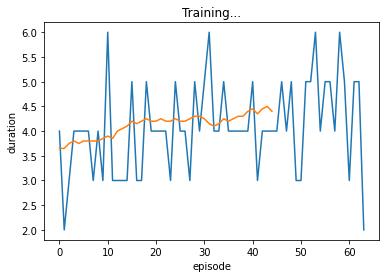

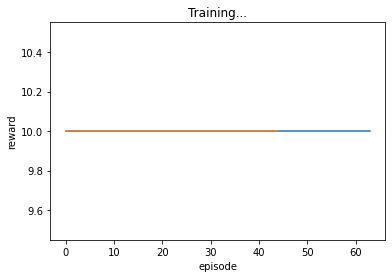

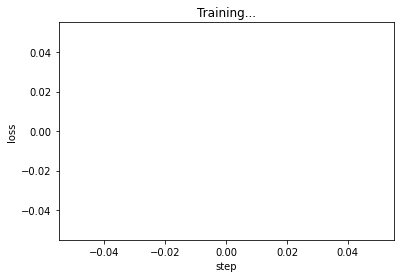

In [62]:
plot_all(*run_experiment(
    model={'name': 'naive', 'startword': None, 'target_list_only':True},
    num_episodes=64
    ))

=========================episode 0 midst======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.74517437 0.         1.        ]-------
=======roate (midst) => [0. 0. 0. 1. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.2000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11480 from 63 conformant words
word at 11480 is thump
------guess 1 11480 thump [1.         0.8        0.36788321 0.         0.        ]-------
=======thump (midst) => [1. 0. 0. 1. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.4000, 0.4000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) 

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.2000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11594 from 112 conformant words
word at 11594 is daisy
------guess 1 11594 daisy [1.         0.8        0.50884023 0.         0.        ]-------
=======daisy (usual) => [0. 1. 0. 1. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.4000, 0.4000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11303 from 3 conformant words
word at 11303 is usual
------guess 2 11303 usual [1.         0.4        0.53544201 0.33333333 0.        ]-------
=======usual (usual) => [2. 2. 2. 2. 2.]= 2.0 =======
reward 8.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 6 hymen======================
states shape (12972, 3) actions shape (12972, 5)


reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.6000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11607 from 21 conformant words
word at 11607 is stork
------guess 1 11607 stork [1.         0.4        0.52895377 0.         0.        ]-------
=======stork (orbit) => [0. 1. 1. 1. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.6000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12211 from 6 conformant words
word at 12211 is orbit
------guess 2 12211 orbit [1.         0.4        0.54079481 0.         0.        ]-------
=======orbit (orbit) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 11 wreak======================
states shape (12972, 3) actions shape (12972, 5)
st

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.4000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11003 from 7 conformant words
word at 11003 is hinge
------guess 2 11003 hinge [1.         0.4        0.51565288 0.         0.        ]-------
=======hinge (binge) => [0. 2. 2. 2. 2.]= 4.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 0.6000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12515 from 1 conformant words
word at 12515 is binge
------guess 3 12515 binge [1.         0.2        0.49813463 0.         0.        ]-------
=======binge (binge) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 17 tulle======================
states shape (12972, 3) actions shape (12972, 5)
s

reward 8.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 22 evoke======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.74517437 0.         1.        ]-------
=======roate (evoke) => [0. 1. 0. 0. 2.]= 0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.2000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11542 from 30 conformant words
word at 11542 is globe
------guess 1 11542 globe [1.         0.6        0.53495539 0.         0.        ]-------
=======globe (evoke) => [0. 0. 2. 0. 2.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.2000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11522 from 51 conformant words
word at 11522 is braid
------guess 1 11522 braid [1.         0.6        0.52278994 0.         0.        ]-------
=======braid (braid) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 27 spend======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.74517437 0.         1.        ]-------
=======roate (spend) => [0. 0. 0. 0. 1.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.0000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12275 from 71 conformant words
word at 12275 is knack
------guess 1 12275 knack [1.         0.6        0.39756691 0.33333333 0.        ]-------
=======knack (psalm) => [0. 0. 2. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.0000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11790 from 25 conformant words
word at 11790 is swami
------guess 2 11790 swami [1.         0.8        0.45904298 0.         0.        ]-------
=======swami (psalm) => [1. 0. 2. 1. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.4000, 0.6000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torc

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.4000, 0.4000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11088 from 17 conformant words
word at 11088 is unfit
------guess 2 11088 unfit [1.         0.6        0.43341444 0.         0.        ]-------
=======unfit (guilt) => [1. 0. 0. 1. 2.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.4000, 0.6000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11330 from 3 conformant words
word at 11330 is built
------guess 3 11330 built [1.         0.4        0.46504461 0.         0.        ]-------
=======built (guilt) => [0. 2. 2. 2. 2.]= 4.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 0.8000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'tor

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.0000, 0.4000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11351 from 16 conformant words
word at 11351 is sunny
------guess 2 11351 sunny [1.         0.6        0.43974047 0.33333333 0.        ]-------
=======sunny (pushy) => [1. 2. 0. 0. 2.]= 2.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.4000, 0.2000, 0.6000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12864 from 5 conformant words
word at 12864 is fussy
------guess 3 12864 fussy [1.         0.2        0.39902676 0.33333333 0.        ]-------
=======fussy (pushy) => [0. 2. 2. 0. 2.]= 5.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.6000, 0.0000, 0.8000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'tor

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.4000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12356 from 56 conformant words
word at 12356 is quest
------guess 1 12356 quest [1.         0.6        0.50721817 0.         0.        ]-------
=======quest (quiet) => [2. 2. 1. 0. 2.]= 2.0 =======
reward 5.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.6000, 0.2000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10673 from 1 conformant words
word at 10673 is quiet
------guess 2 10673 quiet [1.         0.2        0.50754258 0.         0.        ]-------
=======quiet (quiet) => [2. 2. 2. 2. 2.]= 7.0 =======
reward 3.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 47 pluck======================
states shape (12972, 3) actions shape (12972, 5)


reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.6000, 0.2000, 0.4000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12165 from 2 conformant words
word at 12165 is alter
------guess 2 12165 alter [1.         0.2        0.73949716 0.         0.        ]-------
=======alter (alter) => [2. 2. 2. 2. 2.]= 7.0 =======
reward 3.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 52 angel======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.74517437 0.         1.        ]-------
=======roate (angel) => [0. 0. 1. 0. 1.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0

reward 7.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 57 queen======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.74517437 0.         1.        ]-------
=======roate (queen) => [0. 0. 0. 0. 1.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.2000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12424 from 106 conformant words
word at 12424 is neigh
------guess 1 12424 neigh [1.         0.8        0.51565288 0.         0.        ]-------
=======neigh (queen) => [1. 1. 0. 0. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.2000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11379 from 39 conformant words
word at 11379 is nurse
------guess 1 11379 nurse [1.         0.6        0.62335766 0.         0.        ]-------
=======nurse (genre) => [1. 0. 1. 0. 2.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.4000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11225 from 2 conformant words
word at 11225 is genre
------guess 2 11225 genre [1.         0.2        0.68953771 0.33333333 0.        ]-------
=======genre (genre) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 63 horny======================
states shape (12972, 3) actions shape (12972, 5)


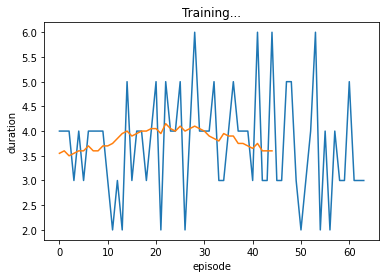

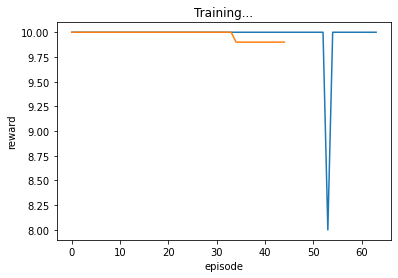

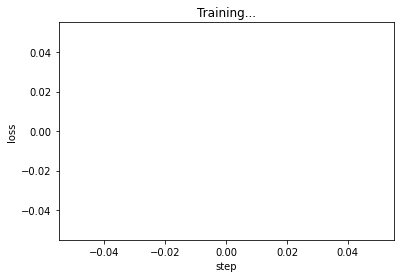

In [63]:
plot_all(*run_experiment(
    model={'name': 'naive', 'startword': 'roate', 'target_list_only':True},
    num_episodes=64
    ))


=========================episode 0 doubt======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.74517437 0.         1.        ]-------
=======roate (doubt) => [0. 2. 0. 1. 0.]= 0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.2000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 8620 from 111 conformant words
word at 8620 is souct
------guess 1 8620 souct [1.         0.6        0.50218978 0.         1.        ]-------
=======souct (doubt) => [0. 2. 2. 0. 2.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.6000, 0.0000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <c

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 0.6000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 6244 from 4 conformant words
word at 6244 is noser
------guess 3 6244 noser [1.         0.2        0.66991079 0.         1.        ]-------
=======noser (poser) => [0. 2. 2. 2. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 0.8000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11031 from 3 conformant words
word at 11031 is loser
------guess 4 11031 loser [1.         0.2        0.69326845 0.         0.        ]-------
=======loser (poser) => [0. 2. 2. 2. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 1.0000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tenso

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.2000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11631 from 237 conformant words
word at 11631 is pitch
------guess 1 11631 pitch [1.        0.8       0.4270884 0.        0.       ]-------
=======pitch (butch) => [0. 0. 2. 2. 2.]= 1.0 =======
reward 5.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.6000, 0.0000, 0.4000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 4910 from 7 conformant words
word at 4910 is kutch
------guess 2 4910 kutch [1.         0.4        0.36853204 0.         1.        ]-------
=======kutch (butch) => [0. 2. 2. 2. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 0.6000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tens

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.6000, 0.0000, 0.8000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 1930 from 6 conformant words
word at 1930 is crine
------guess 4 1930 crine [1.         0.4        0.62530414 0.         1.        ]-------
=======crine (urine) => [0. 2. 2. 2. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 1.0000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12091 from 1 conformant words
word at 12091 is urine
------guess 5 12091 urine [1.         0.2        0.62368208 0.         0.        ]-------
=======urine (urine) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 13 stilt======================
states shape (12972, 3) actions shape (12972, 5)
startw

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.6000, 0.2000, 0.8000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11604 from 1 conformant words
word at 11604 is cough
------guess 4 11604 cough [1.         0.2        0.38896999 0.         0.        ]-------
=======cough (cough) => [2. 2. 2. 2. 2.]= 7.0 =======
reward 3.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 17 hobby======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.74517437 0.         1.        ]-------
=======roate (hobby) => [0. 2. 0. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.4000, 0.4000, 0.6000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 3938 from 2 conformant words
word at 3938 is hasta
------guess 3 3938 hasta [1.         0.         0.60746148 0.33333333 1.        ]-------
=======hasta (hasty) => [2. 2. 2. 2. 0.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 0.8000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10977 from 1 conformant words
word at 10977 is hasty
------guess 4 10977 hasty [1.         0.2        0.51759935 0.         0.        ]-------
=======hasty (hasty) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 21 alloy======================
states shape (12972, 3) actions shape (12972, 5)
star

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.4000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11356 from 49 conformant words
word at 11356 is venom
------guess 2 11356 venom [1.         0.6        0.49164639 0.         0.        ]-------
=======venom (epoch) => [0. 1. 0. 1. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.4000, 0.6000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 2685 from 4 conformant words
word at 2685 is ejido
------guess 3 2685 ejido [1.         0.6        0.49927007 0.         1.        ]-------
=======ejido (epoch) => [2. 0. 0. 0. 1.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.2000, 0.8000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tens

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.4000, 0.4000, 0.6000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 8737 from 2 conformant words
word at 8737 is spuer
------guess 3 8737 spuer [1.         0.2        0.58961882 0.         1.        ]-------
=======spuer (upper) => [0. 2. 1. 2. 2.]= 6.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.6000, 0.2000, 0.8000, 0.0000, 0.2000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12095 from 1 conformant words
word at 12095 is upper
------guess 4 12095 upper [1.         0.         0.5406326  0.33333333 0.        ]-------
=======upper (upper) => [2. 2. 2. 2. 2.]= 7.0 =======
reward 3.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 30 alloy======================
states shape (12972, 3) actions shape (12972, 5)
star

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.4000, 0.0000, 1.0000, 0.0000, 0.0000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11866 from 4 conformant words
word at 11866 is puppy
------guess 5 11866 puppy [1.         0.2        0.32327656 0.66666667 0.        ]-------
=======puppy (mummy) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done True 
episode finished.  reward [4.] eps 0.0
=========================episode 34 stuff======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.74517437 0.         1.        ]-------
=======roate (stuff) => [0. 0. 0. 1. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.6000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 8931 from 61 conformant words
word at 8931 is sutor
------guess 1 8931 sutor [1.         0.4        0.57064071 0.         1.        ]-------
=======sutor (story) => [2. 0. 1. 1. 1.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.6000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 11642 from 7 conformant words
word at 11642 is storm
------guess 2 11642 storm [1.         0.2        0.54614761 0.         0.        ]-------
=======storm (story) => [2. 2. 2. 2. 0.]= 5.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.8000, 0.0000, 0.6000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.6000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 12665 from 108 conformant words
word at 12665 is exert
------guess 1 12665 exert [1.         0.2        0.67007299 0.33333333 0.        ]-------
=======exert (truer) => [1. 0. 0. 1. 1.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.6000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 9357 from 50 conformant words
word at 9357 is titer
------guess 2 9357 titer [1.         0.2        0.69115977 0.33333333 1.        ]-------
=======titer (truer) => [2. 0. 0. 2. 2.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.6000, 0.0000, 0.6000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.4000, 0.4000, 0.4000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 476 from 2 conformant words
word at 476 is aspie
------guess 2 476 aspie [1.         0.2        0.63568532 0.         1.        ]-------
=======aspie (aside) => [2. 2. 0. 1. 2.]= 6.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.6000, 0.2000, 0.6000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 10849 from 1 conformant words
word at 10849 is aside
------guess 3 10849 aside [1.         0.2        0.63990268 0.         0.        ]-------
=======aside (aside) => [2. 2. 2. 2. 2.]= 7.0 =======
reward 3.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 47 major======================
states shape (12972, 3) actions shape (12972, 5)
startwo

reward 4.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 50 hurry======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.74517437 0.         1.        ]-------
=======roate (hurry) => [1. 0. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.2000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 1631 from 298 conformant words
word at 1631 is cirls
------guess 1 1631 cirls [1.         0.8        0.55717762 0.         1.        ]-------
=======cirls (hurry) => [0. 0. 2. 0. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.20

reward 2.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 54 warty======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.74517437 0.         1.        ]-------
=======roate (warty) => [1. 0. 1. 2. 0.]= 0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.2000, 0.4000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 2920 from 23 conformant words
word at 2920 is farts
------guess 1 2920 farts [1.         0.4        0.56869424 0.         1.        ]-------
=======farts (warty) => [0. 2. 2. 2. 0.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.600

reward 5.0 done True 
episode finished.  reward [10.] eps 0.0
=========================episode 59 beret======================
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.0000, 0.0000, 1.0000, 0.8000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing fixed startword at 7642
word at 7642 is roate
------guess 0 7642 roate [1.         1.         0.74517437 0.         1.        ]-------
=======roate (beret) => [1. 0. 0. 1. 1.]= 0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.0000, 0.6000, 0.2000, 0.0000, 0.4000, 0.6444, 0.3333, 1.0000]) <class 'torch.Tensor'>
choosing conformant word at 9357 from 108 conformant words
word at 9357 is titer
------guess 1 9357 titer [1.         0.2        0.69115977 0.33333333 1.        ]-------
=======titer (beret) => [1. 0. 0. 2. 1.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
startword analysis tensor([0.20

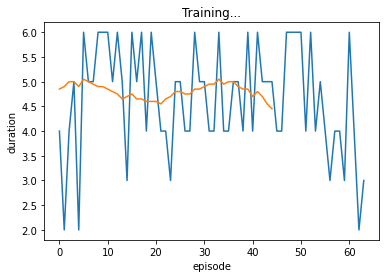

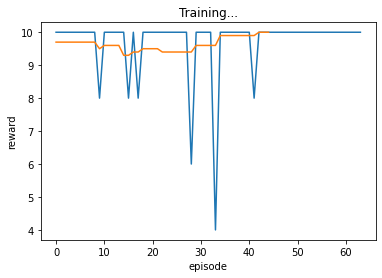

In [81]:
plot_all(*run_experiment(
    model={'name': 'naive', 'startword': 'roate', 'target_list_only':False},
    num_episodes=64
    ))



=========================episode 0 force======================
returning random index 11137
------guess 0 11137 recap [1.         1.         0.64152474 0.         0.        ]-------
=======recap (force) => [1. 1. 1. 0. 0.]= 0 =======
reward 3.0 done False 
returning random index 463
------guess 1 463 ascon [0.         0.6        0.56025953 0.         1.        ]-------
=======ascon (force) => [0. 0. 1. 1. 0.]= 3.0 =======
reward 0 done False 
returning random index 3574
------guess 2 3574 globi [0.         0.8        0.44379562 0.         1.        ]-------
=======globi (force) => [0. 0. 1. 0. 0.]= 3.0 =======
reward 0 done False 
returning random index 2818
------guess 3 2818 etyma [0.        0.6       0.5972425 0.        1.       ]-------
=======etyma (force) => [1. 0. 0. 0. 0.]= 3.0 =======
reward 0 done False 
returning random index 1380
------guess 4 1380 camas [0.         0.         0.55474453 0.33333333 1.        ]-------
=======camas (force) => [1. 0. 0. 0. 0.]= 3.0 =======
rew

reward 0 done False 
returning random index 4527
------guess 3 4527 jolty [0.         0.4        0.43049473 0.         1.        ]-------
=======jolty (gypsy) => [0. 0. 0. 0. 2.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11086 alien [0.         0.         0.67753447 0.         0.        ]-------
=======alien (gypsy) => [0. 0. 0. 0. 0.]= 3.0 =======
reward 0 done False 
returning random index 11473
------guess 5 11473 spout [0.2        0.2        0.48434712 0.         0.        ]-------
=======spout (gypsy) => [1. 1. 0. 0. 0.]= 3.0 =======
reward 0 done True 
episode finished.  reward [3.] eps 0.8330811648918964
=========================episode 7 nutty======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12306 fuzzy [1.         0.8        0.19497161 0.33333333 0.        ]-------
=======fuzzy (nutty) => [0. 2. 0. 0. 2.]= 0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)


reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 6367 oiler [0.         0.         0.69359286 0.         1.        ]-------
=======oiler (stake) => [0. 0. 0. 1. 0.]= 2.0 =======
reward 0 done True 
episode finished.  reward [2.] eps 0.7786812178597389
=========================episode 13 polka======================
returning random index 10895
------guess 0 10895 ultra [1.         1.         0.61524736 0.         0.        ]-------
=======ultra (polka) => [0. 1. 0. 0. 2.]= 0 =======
reward 3.0 done False 
returning random index 5832
------guess 1 5832 moobs [0.         0.8        0.44995945 0.33333333 1.        ]-------
=======moobs (polka) => [0. 2. 0. 0. 0.]= 3.0 =======
reward 0 done False 
returning random index 7007
------guess 2 7007 porky [0.5        0.6        0.43065693 0.         1.        ]-------
=======porky (polka) => [2. 2. 0. 2. 0.]= 3.0 =======
reward 3.0 done False 
returning random index 5217
------guess 3 5217 litas [0.         0.2 

reward 1.0 done False 
returning random index 5851
------guess 1 5851 mopes [1.         0.8        0.54160584 0.         1.        ]-------
=======mopes (token) => [0. 2. 0. 2. 0.]= 1.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 112 aeros [0.         0.         0.73544201 0.         1.        ]-------
=======aeros (token) => [0. 1. 0. 1. 0.]= 4.0 =======
reward 0 done False 
returning random index 1066
------guess 3 1066 booky [0.         0.6        0.39318735 0.33333333 1.        ]-------
=======booky (token) => [0. 2. 0. 1. 0.]= 4.0 =======
reward 0 done False 
returning random index 6631
------guess 4 6631 paten [0.        0.4       0.6298459 0.        1.       ]-------
=======paten (token) => [0. 0. 1. 2. 2.]= 4.0 =======
reward 1.0 done False 
returning random index 12259
------guess 5 12259 stump [0.         0.2        0.41330089 0.         0.        ]-------
=======stump (token) => [0. 1. 0. 0. 0.]= 5.0 =======
reward 0 done Tru

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 3087 fjeld [0.33333333 1.         0.42206002 0.         1.        ]-------
=======fjeld (ankle) => [0. 0. 1. 2. 0.]= 3.0 =======
reward 0 done False 
returning random index 8178
------guess 4 8178 shewn [0.25       0.4        0.49651257 0.         1.        ]-------
=======shewn (ankle) => [0. 0. 1. 0. 1.]= 3.0 =======
reward 0 done False 
returning random index 8251
------guess 5 8251 sides [0.2        0.         0.58961882 0.33333333 1.        ]-------
=======sides (ankle) => [0. 0. 0. 1. 0.]= 3.0 =======
reward 0 done True 
episode finished.  reward [3.] eps 0.6734299127906459
=========================episode 26 shake======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (shake) => [0. 1. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
--

reward 0 done True 
episode finished.  reward [3.] eps 0.6301207952245815
=========================episode 32 admit======================
returning random index 1175
------guess 0 1175 breme [1.         0.8        0.64266018 0.33333333 1.        ]-------
=======breme (admit) => [0. 0. 0. 1. 0.]= 0 =======
reward 1.0 done False 
returning random index 4362
------guess 1 4362 inure [0.         0.6        0.62368208 0.         1.        ]-------
=======inure (admit) => [1. 0. 0. 0. 0.]= 1.0 =======
reward 0 done False 
returning random index 5640
------guess 2 5640 merks [0.         0.4        0.53965937 0.         1.        ]-------
=======merks (admit) => [1. 0. 0. 0. 0.]= 1.0 =======
reward 0 done False 
returning random index 6338
------guess 3 6338 odism [0.66666667 0.4        0.45466342 0.         1.        ]-------
=======odism (admit) => [0. 2. 1. 0. 1.]= 1.0 =======
reward 3.0 done False 
returning random index 12709
------guess 4 12709 curvy [0.         0.6        0.39270073 0. 

reward 1.0 done False 
returning random index 7525
------guess 1 7525 repla [0.         0.4        0.68077859 0.         1.        ]-------
=======repla (short) => [1. 0. 0. 0. 0.]= 1.0 =======
reward 0 done False 
returning random index 9746
------guess 2 9746 unica [0.         0.8        0.51403082 0.         1.        ]-------
=======unica (short) => [0. 0. 0. 0. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 9446 torot [1.         0.4        0.6269262  0.66666667 1.        ]-------
=======torot (short) => [0. 1. 1. 0. 2.]= 1.0 =======
reward 3.0 done False 
returning random index 7016
------guess 4 7016 posey [0.25       0.4        0.55928629 0.         1.        ]-------
=======posey (short) => [0. 1. 1. 0. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 5866 morro [0.6        0.2        0.58751014 0.66666667 1.        ]-------
=======morro (short) => [0. 1. 0. 2. 0.]= 4.0 ==

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12262 wimpy [1.         0.6        0.32019465 0.         0.        ]-------
=======wimpy (imply) => [0. 1. 1. 1. 2.]= 2.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10852 unify [0.66666667 0.6        0.38410381 0.         0.        ]-------
=======unify (imply) => [0. 0. 1. 0. 2.]= 5.0 =======
reward 0 done False 
returning random index 1160
------guess 4 1160 brava [0.         0.6        0.53381995 0.33333333 1.        ]-------
=======brava (imply) => [0. 0. 0. 0. 0.]= 5.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12467 sixty [0.8        0.6        0.41054339 0.         0.        ]-------
=======sixty (imply) => [0. 1. 0. 0. 2.]= 5.0 =======
reward 0 done True 
episode finished.  reward [5.] eps 0.5463276778797345
=========================episode 45 sever======================
returning random index 1

reward 1.0 done False 
returning random index 3833
------guess 5 3833 gyoza [0.2        0.2        0.40697486 0.         1.        ]-------
=======gyoza (moron) => [0. 0. 1. 0. 0.]= 4.0 =======
reward 0 done True 
episode finished.  reward [4.] eps 0.5136993313853994
=========================episode 51 cache======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
=======jumpy (cache) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11875 stole [1.         1.         0.66569343 0.         0.        ]-------
=======stole (cache) => [0. 0. 0. 0. 2.]= 0.0 =======
reward 2.0 done False 
returning random index 1131
------guess 2 1131 boxes [0.5        0.4        0.48240065 0.         1.        ]-------
=======boxes (cache) => [0. 0. 0. 1. 0.]= 2.0 =======
reward 0 done False 
returning random index 7883
------guess 3 7883 s

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10959 royal [1.         0.6        0.61248986 0.         0.        ]-------
=======royal (apart) => [1. 0. 0. 1. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11332 award [1.         0.4        0.55879968 0.33333333 0.        ]-------
=======award (apart) => [2. 0. 2. 2. 0.]= 2.0 =======
reward 4.0 done False 
returning random index 2605
------guess 4 2605 durry [0.         0.         0.5000811  0.33333333 1.        ]-------
=======durry (apart) => [0. 0. 0. 2. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12348 apart [1.         0.4        0.64120032 0.33333333 0.        ]-------
=======apart (apart) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.47890538614351846
=========================episode 59 crass======================
returning random ind

reward 7.0 done True 
episode finished.  reward [10.] eps 0.45151156982986246
=========================episode 65 white======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 6306 oater [1.         1.         0.74517437 0.         1.        ]-------
=======oater (white) => [0. 0. 1. 1. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12185 hefty [1.         0.6        0.48759124 0.         0.        ]-------
=======hefty (white) => [1. 1. 0. 2. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12656 white [1.         0.4        0.52181671 0.         0.        ]-------
=======white (white) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.4491097131863793
=========================episode 66 aloft======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 6306 oater [1.         1.       

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11529 irate [1.         0.2        0.73171127 0.         0.        ]-------
=======irate (stare) => [0. 1. 2. 1. 2.]= 4.0 =======
reward 2.0 done False 
returning random index 8988
------guess 2 8988 sybow [0.         1.         0.37696675 0.         1.        ]-------
=======sybow (stare) => [2. 0. 0. 0. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11572 stare [1.         0.         0.73138686 0.         0.        ]-------
=======stare (stare) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.421383918938275
=========================episode 74 abled======================
returning random index 3082
------guess 0 3082 fiver [1.         1.         0.51678832 0.         1.        ]-------
=======fiver (abled) => [0. 0. 0. 2. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11887 lunge [1.         0.4        0.53609084 0.         0.        ]-------
=======lunge (lunge) => [2. 2. 2. 2. 2.]= 5.0 =======
reward 5.0 done True 
episode finished.  reward [10.] eps 0.39696931598623425
=========================episode 81 assay======================
returning random index 8818
------guess 0 8818 stoln [1.         1.         0.55896188 0.         1.        ]-------
=======stoln (assay) => [1. 0. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11217 arise [1.         0.8        0.72197891 0.         0.        ]-------
=======arise (assay) => [2. 0. 0. 1. 0.]= 1.0 =======
reward 2.0 done False 
returning random index 3510
------guess 2 3510 gimps [0.5        0.6        0.37858881 0.         1.        ]-------
=======gimps (assay) => [0. 0. 0. 0. 1.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972

reward 0 done False 
returning random index 2994
------guess 2 2994 ferms [0.         0.4        0.54290349 0.         1.        ]-------
=======ferms (patsy) => [0. 0. 0. 0. 1.]= 4.0 =======
reward 0 done False 
returning random index 11772
------guess 3 11772 snoop [0.33333333 0.4        0.50592052 0.33333333 0.        ]-------
=======snoop (patsy) => [1. 0. 0. 0. 1.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11962 patsy [1.         0.2        0.51403082 0.         0.        ]-------
=======patsy (patsy) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.37157678523486526
=========================episode 90 manly======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
=======later (manly) => [1. 2. 0. 0. 0.]= 0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12338 olden [1.         0.6        0.59594485 0.         0.        ]-------
=======olden (impel) => [0. 1. 0. 2. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11170 spiel [1.         0.6        0.59351176 0.         0.        ]-------
=======spiel (impel) => [0. 1. 1. 2. 2.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12890 impel [1.         0.2        0.53625304 0.         0.        ]-------
=======impel (impel) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.34983620717821073
=========================episode 98 fatty======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
=======later (fatty) => [0. 2. 2. 0. 0.]= 0 =======
reward 4.0 done False

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11147 scorn [1.         0.8        0.54728305 0.         0.        ]-------
=======scorn (cross) => [1. 1. 2. 1. 0.]= 1.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11689 cross [1.         0.         0.56253041 0.33333333 0.        ]-------
=======cross (cross) => [2. 2. 2. 2. 2.]= 5.0 =======
reward 5.0 done True 
episode finished.  reward [10.] eps 0.3295654265570032
=========================episode 106 print======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
=======later (print) => [0. 0. 1. 0. 1.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12049 snort [1.         0.6        0.58815896 0.         0.        ]-------
=======snort (print) => [0. 1. 0. 1. 2.]= 2.0 =======
reward 2.0 done Fal

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10973 askew [1.         0.4        0.53300892 0.         0.        ]-------
=======askew (askew) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.3111869278109615
=========================episode 114 satyr======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
=======later (satyr) => [0. 2. 2. 0. 2.]= 0 =======
reward 6.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12513 satyr [1.         0.4        0.60032441 0.         0.        ]-------
=======satyr (satyr) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.3101442668119301
=========================episode 115 angel======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.    

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11822 piano [1.         0.8        0.54274128 0.         0.        ]-------
=======piano (shank) => [0. 0. 2. 2. 0.]= 1.0 =======
reward 3.0 done False 
returning random index 11888
------guess 2 11888 space [0.         0.4        0.60421736 0.         0.        ]-------
=======space (shank) => [2. 0. 2. 0. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11696 shank [1.         0.4        0.45774534 0.         0.        ]-------
=======shank (shank) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.29255690665940765
=========================episode 123 scope======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
=======later (scope) => [0. 0. 0. 1. 0.]= 0 =======
reward 1.0 done False 
states shape (129

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 10882 wrung [1.         0.2        0.39691809 0.         0.        ]-------
=======wrung (wrung) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.27661133048504216
loss 1.7253015041351318
=========================episode 130 fluke======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11679 porch [1.         1.         0.46812652 0.         0.        ]-------
=======porch (fluke) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11958 waist [1.         1.         0.52603406 0.         0.        ]-------
=======waist (fluke) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
returning random index 1081
------guess 2 1081 bords [0.         0.4        0.48596918 0.         1.        ]-------
=======bords (fluke) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
r

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11759 trade [1.       0.2      0.686618 0.       0.      ]-------
=======trade (trade) => [2. 2. 2. 2. 2.]= 5.0 =======
reward 5.0 done True 
episode finished.  reward [10.] eps 0.26129100406491773
=========================episode 137 chalk======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11679 porch [1.         1.         0.46812652 0.         0.        ]-------
=======porch (chalk) => [0. 0. 0. 1. 1.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10938 chest [1.         0.6        0.56723439 0.         0.        ]-------
=======chest (chalk) => [2. 2. 0. 0. 0.]= 2.0 =======
reward 2.0 done False 
returning random index 11115
------guess 2 11115 fungi [0.         1.         0.36561233 0.         0.        ]-------
=======fungi (chalk) => [0. 0. 0. 0. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) act

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (civic) => [0. 0. 0. 2. 0.]= 0.0 =======
reward 2.0 done False 
returning random index 6656
------guess 2 6656 pawls [0.         0.6        0.47510138 0.         1.        ]-------
=======pawls (civic) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12425 minim [1.         0.4        0.4134631  0.66666667 0.        ]-------
=======minim (civic) => [0. 2. 0. 2. 0.]= 2.0 =======
reward 2.0 done False 
returning random index 11453
------guess 4 11453 molar [0.         0.2        0.59480941 0.         0.        ]-------
=======molar (civic) => [0. 0. 0. 0. 0.]= 4.0 =======
reward 0 done False 
returning random index 280
------guess 5 280 amens [0.         0.         0.61184104 0.         1.        ]-------
=======amens (civic) => [0. 0. 0. 0. 0.]= 4.0 

reward 4.0 done True 
episode finished.  reward [10.] eps 0.234055317218606
=========================episode 153 olden======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (olden) => [1. 0. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12824 latte [1.         0.6        0.71192214 0.33333333 0.        ]-------
=======latte (olden) => [1. 0. 0. 0. 1.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12553 cello [1.         0.4        0.63292782 0.33333333 0.        ]-------
=======cello (olden) => [0. 1. 1. 0. 1.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12338 olden [1.         0.4        0.59594485 0.         0.        ]-------
=======olden (olden) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True

reward 0 done False 
returning random index 6368
------guess 2 6368 oinks [0.         0.8        0.46699108 0.         1.        ]-------
=======oinks (gouge) => [1. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10903 dodge [1.         0.4        0.50024331 0.33333333 0.        ]-------
=======dodge (gouge) => [0. 2. 0. 2. 2.]= 2.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 10790 gouge [1.         0.2        0.49894566 0.33333333 0.        ]-------
=======gouge (gouge) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.22092696320189825
=========================episode 162 thick======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (thick) => [0. 0. 0. 1. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11677 pearl [1.         0.6        0.68077859 0.         0.        ]-------
=======pearl (beard) => [0. 2. 2. 2. 0.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12500 heard [1.         0.4        0.63146796 0.         0.        ]-------
=======heard (beard) => [0. 2. 2. 2. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11908 beard [1.         0.2        0.61394972 0.         0.        ]-------
=======beard (beard) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.2093712441447414
=========================episode 169 given======================
returning random index 8249
------guess 0 8249 sided [1.         0.8        0.54484996 0.33333333 1.        ]-------
=======sided (given) => [0. 2. 0. 2. 0.]= 0 =======
reward 4.0 done False 
states shape (12972,

reward 7.0 done True 
episode finished.  reward [10.] eps 0.19919234052444734
=========================episode 176 score======================
returning random index 9420
------guess 0 9420 tonus [1.         1.         0.51808597 0.         1.        ]-------
=======tonus (score) => [0. 1. 0. 0. 1.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11909 arose [1.         0.6        0.73544201 0.         0.        ]-------
=======arose (score) => [0. 1. 2. 1. 2.]= 2.0 =======
reward 4.0 done False 
returning random index 4470
------guess 2 4470 jerks [0.         0.4        0.49278183 0.         1.        ]-------
=======jerks (score) => [0. 1. 1. 0. 1.]= 6.0 =======
reward 0 done False 
returning random index 10823
------guess 3 10823 cheat [0.         0.4        0.61751825 0.         0.        ]-------
=======cheat (score) => [1. 0. 1. 0. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 

reward 6.0 done True 
episode finished.  reward [10.] eps 0.18910601628229845
=========================episode 185 array======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
=======later (array) => [0. 1. 0. 0. 1.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11777 array [1.         0.2        0.67818329 0.66666667 0.        ]-------
=======array (array) => [2. 2. 2. 2. 2.]= 2.0 =======
reward 8.0 done True 
episode finished.  reward [10.] eps 0.1885507035829846
=========================episode 186 micro======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
=======later (micro) => [0. 0. 0. 0. 1.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11147 scorn [1.         0.8    

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12266 salsa [1.         0.6        0.6512571  0.66666667 0.        ]-------
=======salsa (gypsy) => [0. 0. 0. 2. 0.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10854 boost [1.         0.6        0.51695053 0.33333333 0.        ]-------
=======boost (gypsy) => [0. 0. 0. 2. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12457 gypsy [1.         0.6        0.35636659 0.33333333 0.        ]-------
=======gypsy (gypsy) => [2. 2. 2. 2. 2.]= 2.0 =======
reward 8.0 done True 
episode finished.  reward [10.] eps 0.17944244594389536
=========================episode 195 whine======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (whine) => [0. 0. 0. 1. 2.]= 0 =======
reward 3.0 done False 

reward 6.0 done True 
episode finished.  reward [10.] eps 0.17141766144686005
=========================episode 202 smear======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (smear) => [1. 0. 1. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11672 arena [1.         0.4        0.756691   0.33333333 0.        ]-------
=======arena (smear) => [1. 1. 2. 0. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12020 clear [1.         0.4        0.69862125 0.         0.        ]-------
=======clear (smear) => [0. 0. 2. 2. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11692 shear [1.         0.4        0.67623682 0.         0.        ]-------
=======shear (smear) => [2. 0. 2. 2. 2.]= 6.0 =======
reward 2.0 done Fa

reward 4.0 done True 
episode finished.  reward [10.] eps 0.163209077160485
=========================episode 209 sappy======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
=======jumpy (sappy) => [0. 0. 0. 2. 2.]= 0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12586 raspy [1.         0.6        0.54160584 0.         0.        ]-------
=======raspy (sappy) => [0. 2. 1. 2. 2.]= 4.0 =======
reward 3.0 done False 
returning random index 1443
------guess 2 1443 casco [0.         0.4        0.54436334 0.33333333 1.        ]-------
=======casco (sappy) => [0. 2. 1. 0. 0.]= 7.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12672 sappy [1.         0.         0.45531225 0.33333333 0.        ]-------
=======sappy (sappy) => [2. 2. 2. 2. 2.]= 7.0 =======
reward 3.0 done True 
episode finished.  rew

reward 1.0 done False 
returning random index 771
------guess 3 771 befog [0.66666667 0.6        0.45563666 0.         1.        ]-------
=======befog (retro) => [0. 2. 0. 1. 0.]= 1.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11039 retro [1.         0.4        0.73219789 0.33333333 0.        ]-------
=======retro (retro) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.1551340654448366
=========================episode 217 icing======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
=======jumpy (icing) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11468 whisk [1.         1.         0.34614761 0.         0.        ]-------
=======whisk (icing) => [0. 0. 2. 0. 0.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3

reward 0 done False 
returning random index 7900
------guess 3 7900 sango [0.66666667 0.8        0.53333333 0.         1.        ]-------
=======sango (otter) => [0. 0. 0. 0. 1.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12564 chock [1.         0.6        0.37420925 0.33333333 0.        ]-------
=======chock (otter) => [0. 0. 1. 0. 0.]= 1.0 =======
reward 0 done False 
returning random index 9711
------guess 5 9711 umphs [0.2        0.2        0.35815085 0.         1.        ]-------
=======umphs (otter) => [0. 0. 0. 0. 0.]= 1.0 =======
reward 0 done True 
episode finished.  reward [1.] eps 0.14783049609865773
=========================episode 224 score======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12306 fuzzy [1.         0.8        0.19497161 0.33333333 0.        ]-------
=======fuzzy (score) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)

reward 4.0 done True 
episode finished.  reward [10.] eps 0.14158214686691428
=========================episode 230 stout======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12306 fuzzy [1.         0.8        0.19497161 0.33333333 0.        ]-------
=======fuzzy (stout) => [0. 1. 0. 0. 0.]= 0 =======
reward 1.0 done False 
returning random index 3458
------guess 1 3458 genoa [0.         1.         0.62481752 0.         1.        ]-------
=======genoa (stout) => [0. 0. 0. 1. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11320 couch [1.         0.4        0.41589619 0.33333333 0.        ]-------
=======couch (stout) => [0. 1. 1. 0. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11220 opium [1.         0.6        0.41768045 0.         0.        ]-------
=======opium (stout) => [1. 0. 0. 2. 0.]= 2.0 =======
reward 1.0 done False 
returning random in

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12184 scold [1.         0.8        0.48856448 0.         0.        ]-------
=======scold (basal) => [1. 0. 0. 1. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12926 basal [1.         0.4        0.58832117 0.33333333 0.        ]-------
=======basal (basal) => [2. 2. 2. 2. 2.]= 2.0 =======
reward 8.0 done True 
episode finished.  reward [10.] eps 0.13504974745651882
=========================episode 238 unlit======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
=======jumpy (unlit) => [0. 1. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12271 squib [1.         0.8        0.34339011 0.         0.        ]-------
=======squib (unlit) => [0. 0. 1. 2. 0.]= 1.0 =======
reward 2.0 done Fa

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11974 annoy [1.         0.2        0.53657745 0.33333333 0.        ]-------
=======annoy (alloy) => [2. 0. 0. 2. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12697 alloy [1.         0.2        0.58329278 0.33333333 0.        ]-------
=======alloy (alloy) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.12929985891301982
=========================episode 245 hilly======================
returning random index 12202
------guess 0 12202 spree [1.         0.8        0.71386861 0.33333333 0.        ]-------
=======spree (hilly) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11886 jumbo [1.         1.         0.29927007 0.         0.        ]-------
=======jumbo (hilly) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
returning random in

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11041 gawky [1.         0.8        0.34387672 0.         0.        ]-------
=======gawky (biddy) => [0. 0. 0. 0. 2.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12663 fizzy [1.         0.6        0.22806164 0.33333333 0.        ]-------
=======fizzy (biddy) => [0. 2. 0. 0. 2.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12467 sixty [1.         0.6        0.41054339 0.         0.        ]-------
=======sixty (biddy) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12746 biddy [1.         0.4        0.35085158 0.33333333 0.        ]-------
=======biddy (biddy) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.12364353429812919
=========================episode 253 befit====================

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11255 blast [1.         0.4        0.54776967 0.         0.        ]-------
=======blast (boast) => [2. 0. 2. 2. 2.]= 5.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12173 beast [1.         0.2        0.63114355 0.         0.        ]-------
=======beast (boast) => [2. 0. 2. 2. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12591 boast [1.         0.2        0.55344688 0.         0.        ]-------
=======boast (boast) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.11880224322926997
loss 1.1672329902648926
=========================episode 260 arbor======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (arbor) => [0. 1. 0. 0. 0.]= 0 ====

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11068 bobby [1.         0.6        0.32798054 0.66666667 0.        ]-------
=======bobby (ditty) => [0. 0. 0. 0. 2.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12410 ninny [1.         0.4        0.45758313 0.66666667 0.        ]-------
=======ninny (ditty) => [0. 2. 0. 0. 2.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11021 piety [1.         0.6        0.55555556 0.         0.        ]-------
=======piety (ditty) => [0. 2. 0. 2. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12694 dirty [1.         0.4        0.50559611 0.         0.        ]-------
=======dirty (ditty) => [2. 2. 0. 2. 2.]= 6.0 =======
reward 2.0 done True 
episode finished.  reward [8.] eps 0.11402261302595304
=========================episode 266 bison===================

reward 6.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11116 charm [1.         0.2        0.49635036 0.         0.        ]-------
=======charm (charm) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.11005353110136515
=========================episode 273 agora======================
returning random index 5755
------guess 0 5755 mitch [1.        1.        0.4188159 0.        1.       ]-------
=======mitch (agora) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
returning random index 5091
------guess 1 5091 leman [0.         0.8        0.61995134 0.         1.        ]-------
=======leman (agora) => [0. 0. 0. 1. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11041 gawky [1.         0.8        0.34387672 0.         0.        ]-------
=======gawky (agora) => [1. 1. 0. 0. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12957 flush [1.         0.6        0.40129765 0.         0.        ]-------
=======flush (flush) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.10599354126244251
=========================episode 280 bunch======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
=======jumpy (bunch) => [0. 2. 0. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11260 quick [1.         0.8        0.30072993 0.         0.        ]-------
=======quick (bunch) => [0. 2. 0. 2. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12826 bunch [1.         0.6        0.35506894 0.         0.        ]-------
=======bunch (bunch) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done Tr

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11343 might [1.        0.8       0.3918897 0.        0.       ]-------
=======might (miser) => [2. 2. 0. 0. 0.]= 1.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11932 micro [1.         0.6        0.50559611 0.         0.        ]-------
=======micro (miser) => [2. 2. 0. 1. 0.]= 4.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12379 miner [1.         0.4        0.59918897 0.         0.        ]-------
=======miner (miser) => [2. 2. 0. 2. 2.]= 5.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12732 miser [1.         0.2        0.61443633 0.         0.        ]-------
=======miser (miser) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.10189572150468323
=========================episode 288 macho=====================

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12662 inbox [1.         0.8        0.37599351 0.         0.        ]-------
=======inbox (final) => [1. 1. 0. 0. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11262 given [1.         0.6        0.47737226 0.         0.        ]-------
=======given (final) => [0. 2. 0. 0. 1.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11275 final [1.         0.6        0.51484185 0.         0.        ]-------
=======final (final) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.09848412134959653
=========================episode 296 eaten======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
=======jumpy (eaten) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done Fals

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 10828 triad [1.         0.2        0.59545823 0.         0.        ]-------
=======triad (triad) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.09538748242341752
=========================episode 303 endow======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
=======jumpy (endow) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11468 whisk [1.         1.         0.34614761 0.         0.        ]-------
=======whisk (endow) => [1. 0. 0. 0. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11428 flown [1.         0.8        0.40113544 0.         0.        ]-------
=======flown (endow) => [0. 0. 1. 1. 1.]= 1.0 =======
reward 2.0 done Fals

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12035 nobly [1.         0.8        0.44671533 0.         0.        ]-------
=======nobly (berry) => [0. 0. 1. 0. 2.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11280 derby [1.         0.6        0.52408759 0.         0.        ]-------
=======derby (berry) => [0. 2. 2. 1. 2.]= 3.0 =======
reward 4.0 done False 
returning random index 5796
------guess 5 5796 moira [0.         0.         0.58702352 0.         1.        ]-------
=======moira (berry) => [0. 0. 0. 2. 0.]= 7.0 =======
reward 0 done True 
episode finished.  reward [7.] eps 0.0921500701813468
=========================episode 311 inept======================
returning random index 3896
------guess 0 3896 halse [1.         1.         0.64703974 0.         1.        ]-------
=======halse (inept) => [0. 0. 0. 0. 1.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972,

reward 7.0 done True 
episode finished.  reward [10.] eps 0.08953697656067441
=========================episode 318 bland======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11572 stare [1.         1.         0.73138686 0.         0.        ]-------
=======stare (bland) => [0. 0. 2. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11921 quack [1.         0.8        0.35068938 0.         0.        ]-------
=======quack (bland) => [0. 0. 2. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12476 foamy [1.         0.8        0.43860503 0.         0.        ]-------
=======foamy (bland) => [0. 0. 2. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11060 bland [1.         0.8        0.47802109 0.         0.        ]-------
=======bland (bland) => [2. 2. 2. 2. 2.]= 2.0 =======
reward 8.0 done True 


reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11567 creed [1.         0.2        0.68694242 0.33333333 0.        ]-------
=======creed (creed) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.08686403260293918
=========================episode 326 adult======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11572 stare [1.         1.         0.73138686 0.         0.        ]-------
=======stare (adult) => [0. 1. 1. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11178 waltz [1.         0.6        0.43179238 0.         0.        ]-------
=======waltz (adult) => [0. 1. 1. 1. 0.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11783 tubal [1.         0.4        0.51500406 0.         0.        ]-------
=======tubal (adult) => [1. 1. 0. 1. 1.]= 3.0 =======
reward 1.0 done Fa

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 10880 perky [1.         0.         0.50835361 0.         0.        ]-------
=======perky (perky) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.08444060855758778
=========================episode 334 pooch======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
=======later (pooch) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
=======sonic (pooch) => [0. 2. 0. 0. 1.]= 0.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11713 pouch [1.         0.6        0.39805353 0.         0.        ]-------
=======pouch (pooch) => [2. 2. 0. 2. 2.]= 3.0 =======
reward 5.0 done False 

reward 4.0 done True 
episode finished.  reward [10.] eps 0.08224091665574398
=========================episode 343 nymph======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
=======later (nymph) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
=======sonic (nymph) => [0. 0. 1. 0. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10941 nymph [1.         0.8        0.33609084 0.         0.        ]-------
=======nymph (nymph) => [2. 2. 2. 2. 2.]= 1.0 =======
reward 9.0 done True 
episode finished.  reward [10.] eps 0.08204805033337524
=========================episode 344 howdy======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.    

reward 6.0 done True 
episode finished.  reward [10.] eps 0.08012141406335885
=========================episode 352 ledge======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
=======later (ledge) => [2. 0. 0. 1. 0.]= 0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11198 louse [1.         0.6        0.62319546 0.         0.        ]-------
=======louse (ledge) => [2. 0. 0. 0. 2.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11139 liege [1.         0.4        0.67591241 0.33333333 0.        ]-------
=======liege (ledge) => [2. 0. 1. 2. 2.]= 4.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12577 ledge [1.         0.2        0.63081914 0.33333333 0.        ]-------
=======ledge (ledge) => [2. 2. 2. 2. 2.]= 7.0 =======
reward 3.0 done Tr

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11490 stain [1.         0.6        0.58767234 0.         0.        ]-------
=======stain (quota) => [0. 1. 1. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10925 today [1.         0.6        0.53203569 0.         0.        ]-------
=======today (quota) => [1. 1. 0. 1. 0.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11385 about [1.         0.4        0.52068127 0.         0.        ]-------
=======about (quota) => [1. 0. 2. 1. 1.]= 3.0 =======
reward 2.0 done False 
returning random index 260
------guess 4 260 aloos [0.         0.         0.62854826 0.33333333 1.        ]-------
=======aloos (quota) => [1. 0. 2. 0. 0.]= 5.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11620 quota [1.         0.2        0.47980535 0.         0.        ]-------
==

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11468 whisk [1.         1.         0.34614761 0.         0.        ]-------
=======whisk (havoc) => [0. 1. 0. 0. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12320 botch [1.         0.8        0.42660178 0.         0.        ]-------
=======botch (havoc) => [0. 1. 0. 1. 1.]= 1.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11961 havoc [1.         0.4        0.44639092 0.         0.        ]-------
=======havoc (havoc) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.07608176339168066
=========================episode 369 amend======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
=======jumpy (amend) => [0. 0. 1. 0. 0.]= 0 =======
reward 1.0 done Fals

reward 0 done True 
episode finished.  reward [8.] eps 0.07451380306917496
=========================episode 378 impel======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
=======jumpy (impel) => [0. 0. 1. 1. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11210 skimp [1.       0.6      0.362206 0.       0.      ]-------
=======skimp (impel) => [0. 0. 1. 1. 1.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12890 impel [1.         0.4        0.53625304 0.         0.        ]-------
=======impel (impel) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.0743671606180404
=========================episode 379 swear======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12621 jumpy [1.         1.         0.25985

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11529 irate [1.         0.2        0.73171127 0.         0.        ]-------
=======irate (treat) => [0. 2. 1. 1. 1.]= 4.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11655 tread [1.       0.2      0.686618 0.       0.      ]-------
=======tread (treat) => [2. 2. 2. 2. 0.]= 5.0 =======
reward 3.0 done False 
returning random index 953
------guess 3 953 blent [0.         0.4        0.57372263 0.         1.        ]-------
=======blent (treat) => [0. 0. 2. 0. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11100 treat [1.         0.         0.74111922 0.33333333 0.        ]-------
=======treat (treat) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.07271978996891648
=========================episode 388 forty======================
states shape (12972, 3) actio

reward 5.0 done True 
episode finished.  reward [10.] eps 0.07139669240320871
=========================episode 396 world======================
returning random index 7410
------guess 0 7410 razes [1.         1.         0.61962693 0.         1.        ]-------
=======razes (world) => [1. 0. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12925 intro [1.         0.8        0.58848337 0.         0.        ]-------
=======intro (world) => [0. 0. 0. 1. 1.]= 1.0 =======
reward 1.0 done False 
returning random index 9907
------guess 2 9907 venge [0.         0.4        0.56853204 0.33333333 1.        ]-------
=======venge (world) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12053 flour [1.         0.6        0.49781022 0.         0.        ]-------
=======flour (world) => [0. 1. 1. 0. 1.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11147 scorn [1.         0.8        0.54728305 0.         0.        ]-------
=======scorn (risky) => [1. 0. 0. 1. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12208 prism [1.         0.6        0.47396594 0.         0.        ]-------
=======prism (risky) => [0. 1. 1. 1. 0.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11373 risky [1.         0.4        0.46618005 0.         0.        ]-------
=======risky (risky) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.06991028334935463
=========================episode 406 naval======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
=======later (naval) => [1. 2. 0. 0. 0.]= 0 =======
reward 3.0 done Fa

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12933 scamp [1.         0.6        0.45547445 0.         0.        ]-------
=======scamp (champ) => [0. 1. 2. 2. 2.]= 3.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10839 champ [1.         0.2        0.41005677 0.         0.        ]-------
=======champ (champ) => [2. 2. 2. 2. 2.]= 7.0 =======
reward 3.0 done True 
episode finished.  reward [10.] eps 0.06867594532376808
=========================episode 416 fetal======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
=======later (fetal) => [1. 1. 2. 1. 0.]= 0 =======
reward 5.0 done False 
returning random index 10947
------guess 1 10947 snout [0.         0.8        0.51808597 0.         0.        ]-------
=======snout (fetal) => [0. 0. 0. 0. 1.]= 5.0 =======
reward 0 done False 
states shape (129

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12016 fiery [1.         0.6        0.56090835 0.         0.        ]-------
=======fiery (query) => [0. 0. 2. 2. 2.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11659 every [1.         0.2        0.63957826 0.33333333 0.        ]-------
=======every (query) => [0. 0. 2. 2. 2.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 10862 query [1.         0.4        0.49521492 0.         0.        ]-------
=======query (query) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.06741333600078275
=========================episode 425 organ======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
=======later (organ) => [0. 1. 0. 0. 1.]= 0 =======
reward 2.0 done Fals

reward 5.0 done True 
episode finished.  reward [10.] eps 0.06636649650907889
=========================episode 433 pygmy======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
=======later (pygmy) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
=======sonic (pygmy) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11441 dumpy [1.         1.         0.31922141 0.         0.        ]-------
=======dumpy (pygmy) => [0. 0. 1. 1. 2.]= 0.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12789 pygmy [1.         0.2        0.29910787 0.33333333 0.        ]-------
=======pygmy (pygmy) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 


reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11655 tread [1.       0.2      0.686618 0.       0.      ]-------
=======tread (treat) => [2. 2. 2. 2. 0.]= 5.0 =======
reward 3.0 done False 
returning random index 12955
------guess 3 12955 twixt [0.         0.4        0.38296837 0.33333333 0.        ]-------
=======twixt (treat) => [2. 0. 0. 0. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11100 treat [1.         0.         0.74111922 0.33333333 0.        ]-------
=======treat (treat) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.0651991020353338
=========================episode 442 stead======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
=======later (stead) => [0. 1. 1. 1. 0.]= 0 =======
reward 3.0 done False 
states shape (12972, 3) acti

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11069 trite [1.         0.         0.69115977 0.33333333 0.        ]-------
=======trite (trite) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.06425683369752079
loss 1.153440237045288
=========================episode 451 filth======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
=======later (filth) => [1. 0. 1. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12065 blitz [1.         0.6        0.39578264 0.         0.        ]-------
=======blitz (filth) => [0. 1. 1. 2. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12679 filth [1.         0.4        0.44412003 0.         0.        ]-------
=======filth (filth) => [2. 2. 2. 2. 2.]= 4.0 =====

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12578 tweak [1.         0.4        0.54274128 0.         0.        ]-------
=======tweak (meaty) => [1. 0. 1. 1. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12810 exact [1.         0.4        0.56042174 0.         0.        ]-------
=======exact (meaty) => [1. 0. 2. 0. 1.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12562 stave [1.         0.4        0.61038118 0.         0.        ]-------
=======stave (meaty) => [0. 1. 2. 0. 1.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 10678 death [1.         0.4        0.60389294 0.         0.        ]-------
=======death (meaty) => [0. 2. 2. 2. 0.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11948 meaty [1.        0.4       0.5972425 0.        0

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11917 swamp [1.         0.6        0.40973236 0.         0.        ]-------
=======swamp (spasm) => [2. 0. 2. 1. 1.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12680 spasm [1.         0.         0.486618   0.33333333 0.        ]-------
=======spasm (spasm) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.062419109182347776
=========================episode 468 wispy======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
=======later (wispy) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10834 sonic [1.         1.         0.51030008 0.         0.        ]-------
=======sonic (wispy) => [1. 0. 0. 1. 0.]= 0.0 =======
reward 2.0 done Fal

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11316 arson [1.         0.6        0.62871046 0.         0.        ]-------
=======arson (drawn) => [1. 2. 0. 0. 2.]= 2.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10720 drain [1.         0.4        0.57047851 0.         0.        ]-------
=======drain (drawn) => [2. 2. 2. 0. 2.]= 5.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12360 drawn [1.         0.2        0.49326845 0.         0.        ]-------
=======drawn (drawn) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.061579500650358276
=========================episode 477 suing======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
=======later (suing) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done Fal

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11316 arson [1.         0.6        0.62871046 0.         0.        ]-------
=======arson (cobra) => [1. 1. 0. 1. 0.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11793 roach [1.         0.4        0.56739659 0.         0.        ]-------
=======roach (cobra) => [1. 2. 1. 1. 0.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12492 cobra [1.         0.2        0.54987835 0.         0.        ]-------
=======cobra (cobra) => [2. 2. 2. 2. 2.]= 5.0 =======
reward 5.0 done True 
episode finished.  reward [10.] eps 0.06079665484399097
=========================episode 485 sissy======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11530 later [1.         1.         0.73949716 0.         0.        ]-------
=======later (sissy) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done Fals

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11224 mulch [1.         0.8        0.38410381 0.         0.        ]-------
=======mulch (pulpy) => [0. 2. 2. 0. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12657 bulky [1.         0.6        0.34095702 0.         0.        ]-------
=======bulky (pulpy) => [0. 2. 2. 0. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11117 gully [1.         0.2        0.42838605 0.33333333 0.        ]-------
=======gully (pulpy) => [0. 2. 2. 0. 2.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 10795 pulpy [1.         0.2        0.38037307 0.33333333 0.        ]-------
=======pulpy (pulpy) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.0600667342521948
=========================episode 494 yacht===================

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11308 muddy [1.         0.6        0.32343877 0.33333333 0.        ]-------
=======muddy (movie) => [2. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11399 moron [1.         0.6        0.53495539 0.33333333 0.        ]-------
=======moron (movie) => [2. 2. 0. 0. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10885 moist [1.         0.6        0.50916464 0.         0.        ]-------
=======moist (movie) => [2. 2. 1. 0. 0.]= 4.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 10930 movie [1.         0.4        0.50721817 0.         0.        ]-------
=======movie (movie) => [2. 2. 2. 2. 2.]= 5.0 =======
reward 5.0 done True 
episode finished.  reward [10.] eps 0.05940495190983148
=========================episode 502 overt==================

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12919 peril [1.         0.6        0.63081914 0.         0.        ]-------
=======peril (reply) => [1. 2. 1. 0. 1.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11310 reply [1.         0.2        0.59091646 0.         0.        ]-------
=======reply (reply) => [2. 2. 2. 2. 2.]= 5.0 =======
reward 5.0 done True 
episode finished.  reward [10.] eps 0.05880426575997164
=========================episode 509 badly======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (badly) => [0. 2. 0. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12396 jazzy [1.         0.6        0.24509327 0.33333333 0.        ]-------
=======jazzy (badly) => [0. 2. 0. 0. 2.]= 2.0 =======
reward 2.0 done Fals

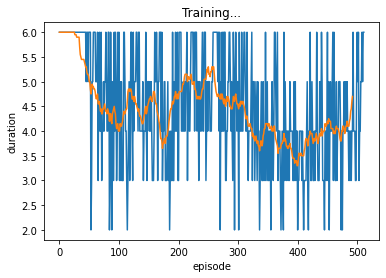

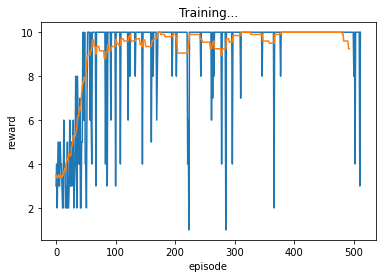

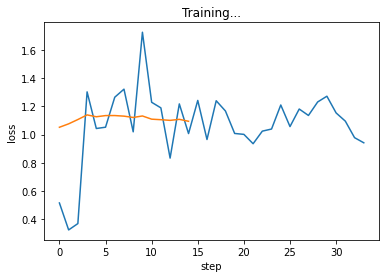

In [129]:
plot_all(*run_experiment(
    model={'name': 'nn'},
    value_function='reward',
    eps=[0.9, 0.05, 500],
    num_episodes=512,
    batch_size=64
    ))


=========================episode 0 squib======================
returning random index 3202
------guess 0 3202 fouds [1.         1.         0.40762368 0.         1.        ]-------
=======fouds (squib) => [0. 0. 2. 0. 1.]= 0 =======
reward 3.0 done False 
returning random index 7734
------guess 1 7734 rowan [0.         0.8        0.55182482 0.         1.        ]-------
=======rowan (squib) => [0. 0. 0. 0. 0.]= 3.0 =======
reward 0 done False 
returning random index 10724
------guess 2 10724 crass [0.         0.2        0.59902676 0.33333333 0.        ]-------
=======crass (squib) => [0. 0. 0. 1. 0.]= 3.0 =======
reward 0 done False 
returning random index 9756
------guess 3 9756 unlid [0.         0.4        0.45823195 0.         1.        ]-------
=======unlid (squib) => [1. 0. 0. 2. 0.]= 3.0 =======
reward 0 done False 
returning random index 4821
------guess 4 4821 knubs [0.25       0.4        0.35717762 0.         1.        ]-------
=======knubs (squib) => [0. 0. 2. 1. 1.]= 3.0 ====

reward 0 done False 
returning random index 9455
------guess 5 9455 tosed [0.         0.2        0.61281427 0.         1.        ]-------
=======tosed (belch) => [0. 0. 0. 1. 0.]= 1.0 =======
reward 0 done True 
episode finished.  reward [1.] eps 0.842534746920056
hybrid rewards [array([1.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])] vs. [array([1.]), array([0]), array([0]), array([0]), array([0]), array([0])]
=========================episode 6 blank======================
returning random index 8929
------guess 0 8929 suses [1.         0.6        0.60129765 0.66666667 1.        ]-------
=======suses (blank) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 6689 peepe [0.         0.2        0.71905921 1.         1.        ]-------
=======peepe (blank) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
returning random index 7578
------guess 2 7578 riata [1.         0.8        0.69051095 0.33333333

reward 0 done False 
returning random index 9519
------guess 2 9519 treys [0.         0.2        0.64152474 0.         1.        ]-------
=======treys (pasty) => [1. 0. 0. 1. 1.]= 3.0 =======
reward 0 done False 
returning random index 4890
------guess 3 4890 kudos [0.         0.4        0.40437956 0.         1.        ]-------
=======kudos (pasty) => [0. 0. 0. 0. 1.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 5077 leese [0.25       0.2        0.82514193 0.66666667 1.        ]-------
=======leese (pasty) => [0. 0. 0. 1. 0.]= 3.0 =======
reward 0 done False 
returning random index 5458
------guess 5 5458 maire [0.         0.2        0.66472019 0.         1.        ]-------
=======maire (pasty) => [0. 2. 0. 0. 0.]= 3.0 =======
reward 0 done True 
episode finished.  reward [3.] eps 0.787478068013027
hybrid rewards [array([3.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])] vs. [array([3.]), array([0]), array([0]), ar

reward 0 done False 
returning random index 9866
------guess 1 9866 varna [0.         0.4        0.58150852 0.33333333 1.        ]-------
=======varna (crimp) => [0. 0. 1. 0. 0.]= 0.0 =======
reward 1.0 done False 
returning random index 5758
------guess 2 5758 mitis [0.         0.4        0.49570154 0.33333333 1.        ]-------
=======mitis (crimp) => [1. 1. 0. 0. 0.]= 1.0 =======
reward 1.0 done False 
returning random index 1850
------guess 3 1850 corns [0.         0.4        0.54728305 0.         1.        ]-------
=======corns (crimp) => [2. 0. 1. 0. 0.]= 2.0 =======
reward 1.0 done False 
returning random index 2464
------guess 4 2464 dovie [0.25       0.4        0.51970803 0.         1.        ]-------
=======dovie (crimp) => [0. 0. 0. 1. 0.]= 3.0 =======
reward 0 done False 
returning random index 11897
------guess 5 11897 droop [0.4        0.2        0.51370641 0.33333333 0.        ]-------
=======droop (crimp) => [0. 2. 0. 0. 2.]= 3.0 =======
reward 1.0 done True 
episode fi

reward 3.0 done False 
returning random index 1653
------guess 5 1653 clapt [0.4        0.4        0.53057583 0.         1.        ]-------
=======clapt (repay) => [0. 0. 1. 1. 0.]= 4.0 =======
reward 0 done True 
episode finished.  reward [4.] eps 0.6962822639717497
hybrid rewards [array([1.]), array([0.]), array([0.]), array([0.]), array([3.]), array([0.])] vs. [array([1.]), array([0]), array([0]), array([0]), array([3.]), array([0])]
=========================episode 23 moral======================
returning random index 10176
------guess 0 10176 wents [1.         1.         0.55166261 0.         1.        ]-------
=======wents (moral) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
returning random index 1010
------guess 1 1010 boeps [0.         0.6        0.53592863 0.         1.        ]-------
=======boeps (moral) => [0. 2. 0. 0. 0.]= 0.0 =======
reward 2.0 done False 
returning random index 12344
------guess 2 12344 tulle [0.         0.4        0.62725061 0.33333333 0.       

reward 0 done False 
returning random index 9867
------guess 2 9867 varus [0.         0.6        0.51370641 0.         1.        ]-------
=======varus (emcee) => [0. 0. 0. 0. 0.]= 1.0 =======
reward 0 done False 
returning random index 11405
------guess 3 11405 index [0.33333333 0.6        0.47185726 0.         0.        ]-------
=======index (emcee) => [0. 0. 0. 2. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 9014 taata [0.         0.2        0.71289538 1.         1.        ]-------
=======taata (emcee) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
returning random index 8164
------guess 5 8164 shchi [0.2        0.2        0.42092457 0.33333333 1.        ]-------
=======shchi (emcee) => [0. 0. 2. 0. 0.]= 2.0 =======
reward 0 done True 
episode finished.  reward [2.] eps 0.6513856140405265
hybrid rewards [array([1.]), array([0.]), array([0.]), array([1.]), array([0.]), array([0.])] vs. [array([1.]), array([0]), array([0]

reward 0 done True 
episode finished.  reward [3.] eps 0.6163636423111535
hybrid rewards [array([1.]), array([2.]), array([0.]), array([0.]), array([0.]), array([0.])] vs. [array([1.]), array([2.]), array([0]), array([0]), array([0]), array([0])]
=========================episode 34 roast======================
returning random index 7338
------guess 0 7338 ramee [1.         0.8        0.75587997 0.33333333 1.        ]-------
=======ramee (roast) => [2. 1. 0. 0. 0.]= 0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12962 rival [1.         0.6        0.55490673 0.         0.        ]-------
=======rival (roast) => [2. 0. 0. 1. 0.]= 3.0 =======
reward 0 done False 
returning random index 4598
------guess 2 4598 kails [0.         0.4        0.52684509 0.         1.        ]-------
=======kails (roast) => [0. 1. 0. 0. 1.]= 3.0 =======
reward 0 done False 
returning random index 2695
------guess 3 2695 elint [0.         0.4        0.63698297 0.  

reward 0 done False 
returning random index 10618
------guess 3 10618 zobus [0.33333333 0.4        0.35863747 0.         1.        ]-------
=======zobus (tulip) => [0. 0. 0. 1. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 3778 guimp [0.75      0.6       0.3458232 0.        1.       ]-------
=======guimp (tulip) => [0. 2. 1. 0. 2.]= 3.0 =======
reward 2.0 done False 
returning random index 9774
------guess 5 9774 untax [0.2        0.4        0.45206813 0.         1.        ]-------
=======untax (tulip) => [1. 0. 1. 0. 0.]= 5.0 =======
reward 0 done True 
episode finished.  reward [5.] eps 0.577018867434695
hybrid rewards [array([3.]), array([0.]), array([0.]), array([0.]), array([2.]), array([0.])] vs. [array([3.]), array([0]), array([0]), array([0]), array([2.]), array([0])]
=========================episode 40 slash======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12621 jumpy [1.         1.     

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 0 aahed [0.         0.8        0.64444444 0.33333333 1.        ]-------
=======aahed (prime) => [0. 0. 0. 1. 0.]= 1.0 =======
reward 0 done False 
returning random index 3242
------guess 2 3242 fries [0.         0.4        0.60048662 0.         1.        ]-------
=======fries (prime) => [0. 2. 2. 1. 0.]= 1.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 5 abaci [0.33333333 0.4        0.54939173 0.33333333 1.        ]-------
=======abaci (prime) => [0. 0. 0. 0. 1.]= 5.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 27 ablow [0.         0.6        0.47493917 0.         1.        ]-------
=======ablow (prime) => [0. 0. 0. 0. 0.]= 5.0 =======
reward 0 done False 
returning random index 12781
------guess 5 12781 munch [0.2        0.6        0.36074615 0.         0.        ]-------
=======munch (prime) => [1. 0. 0.

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7 abaft [0.2        0.4        0.51873479 0.33333333 1.        ]-------
=======abaft (thank) => [0. 0. 2. 0. 1.]= 2.0 =======
reward 1.0 done True 
episode finished.  reward [3.] eps 0.5118482387133249
hybrid rewards [array([0.]), array([1.]), array([1.]), array([0.]), array([0.]), array([1.])] vs. [array([0]), array([1.]), array([1.]), array([0]), array([0]), array([1.])]
=========================episode 51 drake======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 10659 sissy [1.         0.6        0.50332522 0.66666667 0.        ]-------
=======sissy (drake) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
returning random index 7446
------guess 1 7446 reddy [0.         0.6        0.54225466 0.33333333 1.        ]-------
=======reddy (drake) => [1. 1. 1. 0. 0.]= 0.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 0 aahed

reward 2.0 done False 
returning random index 8312
------guess 1 8312 sited [0.         0.8        0.59935118 0.         1.        ]-------
=======sited (beady) => [0. 0. 0. 1. 1.]= 2.0 =======
reward 0 done False 
returning random index 5204
------guess 2 5204 lipas [0.         0.2        0.55231144 0.         1.        ]-------
=======lipas (beady) => [0. 0. 0. 1. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 28 abmho [0.33333333 0.8        0.44103812 0.         1.        ]-------
=======abmho (beady) => [1. 1. 0. 0. 0.]= 2.0 =======
reward 0 done False 
returning random index 6776
------guess 4 6776 phono [0.         0.2        0.46050284 0.33333333 1.        ]-------
=======phono (beady) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 3773 gucky [0.2        1.         0.30656934 0.         1.        ]-------
=======gucky (beady) => [0. 0. 0. 0. 2.]= 2.0 ======

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 4855 kopje [0.4        0.8        0.42027575 0.         1.        ]-------
=======kopje (cause) => [0. 0. 0. 0. 2.]= 3.0 =======
reward 0 done True 
episode finished.  reward [3.] eps 0.45473654508969097
hybrid rewards [array([3.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])] vs. [array([3.]), array([0]), array([0]), array([0]), array([0]), array([0])]
=========================episode 62 apply======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 244 allee [1.         0.6        0.79205191 0.66666667 1.        ]-------
=======allee (apply) => [2. 1. 0. 0. 0.]= 0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 1 aalii [1.         0.2        0.65190592 0.66666667 1.        ]-------
=======aalii (apply) => [2. 0. 1. 0. 0.]= 3.0 =======
reward 0 done False 
returning random index 11310
------guess 2 11310 reply

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12621 jumpy [1.         1.         0.25985401 0.         0.        ]-------
=======jumpy (quell) => [0. 2. 0. 0. 0.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 7287 quonk [1.         0.8        0.33008921 0.         1.        ]-------
=======quonk (quell) => [2. 2. 0. 0. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 7246 quags [1.         0.6        0.39821573 0.         1.        ]-------
=======quags (quell) => [2. 2. 0. 0. 0.]= 4.0 =======
reward 0 done False 
returning random index 7867
------guess 4 7867 sales [0.25       0.4        0.69245742 0.33333333 1.        ]-------
=======sales (quell) => [0. 0. 1. 1. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 3313 fuzed [0.4        0.6        0.38329278 0.         1.        ]-------
=====

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 9904 vends [0.5        1.         0.49034874 0.         1.        ]-------
=======vends (clash) => [0. 0. 0. 0. 1.]= 5.0 =======
reward 0 done False 
returning random index 7167
------guess 5 7167 pules [0.2        0.4        0.56042174 0.         1.        ]-------
=======pules (clash) => [0. 0. 1. 0. 1.]= 5.0 =======
reward 0 done True 
episode finished.  reward [5.] eps 0.40468722666888746
hybrid rewards [array([3.]), array([2.]), array([0.]), array([0.]), array([0.]), array([0.])] vs. [array([3.]), array([2.]), array([0]), array([0]), array([0]), array([0])]
=========================episode 73 mirth======================
returning random index 4495
------guess 0 4495 jingo [1.         1.         0.37923763 0.         1.        ]-------
=======jingo (mirth) => [0. 2. 0. 0. 0.]= 0 =======
reward 2.0 done False 
returning random index 6732
------guess 1 6732 perdu [0.         1.         0.54484996 0.  

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 827 beths [1.         0.6        0.53544201 0.         1.        ]-------
=======beths (wench) => [0. 2. 0. 1. 0.]= 2.0 =======
reward 1.0 done False 
returning random index 11076
------guess 2 11076 motto [0.         0.4        0.5323601  0.66666667 0.        ]-------
=======motto (wench) => [0. 0. 0. 0. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 2972 felch [1.         0.6        0.49440389 0.         1.        ]-------
=======felch (wench) => [0. 2. 0. 2. 2.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 4694 kench [1.         0.4        0.46780211 0.         1.        ]-------
=======kench (wench) => [0. 2. 2. 2. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 4043 hexyl [0.6        0.4        0.45466342 0.         1.        ]-------
=

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 3506 gilpy [1.         0.6        0.40437956 0.         1.        ]-------
=======gilpy (milky) => [0. 2. 2. 0. 2.]= 4.0 =======
reward 2.0 done False 
returning random index 4748
------guess 5 4748 kidge [0.2        0.2        0.45709651 0.         1.        ]-------
=======kidge (milky) => [1. 2. 0. 0. 0.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.36082695716095603
hybrid rewards [array([1.]), array([2.]), array([0.]), array([1.]), array([2.]), array([0.])] vs. [array([1.]), array([2.]), array([0]), array([1.]), array([2.]), array([0])]
=========================episode 84 wight======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 0 aahed [1.         0.8        0.64444444 0.33333333 1.        ]-------
=======aahed (wight) => [0. 0. 1. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 47 a

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 2 aargh [1.         0.8        0.57696675 0.33333333 1.        ]-------
=======aargh (rover) => [0. 0. 1. 0. 0.]= 0.0 =======
reward 1.0 done False 
returning random index 3465
------guess 2 3465 geode [0.5        0.6        0.63649635 0.33333333 1.        ]-------
=======geode (rover) => [0. 1. 1. 0. 0.]= 1.0 =======
reward 1.0 done False 
returning random index 8588
------guess 3 8588 sools [0.         0.2        0.5782644  0.66666667 1.        ]-------
=======sools (rover) => [0. 2. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 10017 vower [1.         0.4        0.52457421 0.         1.        ]-------
=======vower (rover) => [1. 2. 0. 2. 2.]= 2.0 =======
reward 5.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7694 roque [0.8       0.4       0.5485807 0.        1.       ]-------
=======roque (rover) => [2. 2. 0

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 420 argot [0.75       0.6        0.59562044 0.         1.        ]-------
=======argot (annoy) => [2. 0. 0. 2. 0.]= 5.0 =======
reward 0 done False 
returning random index 3656
------guess 5 3656 gooly [0.         0.2        0.48061638 0.33333333 1.        ]-------
=======gooly (annoy) => [0. 1. 0. 0. 2.]= 5.0 =======
reward 0 done True 
episode finished.  reward [5.] eps 0.32239040493592597
hybrid rewards [array([2.]), array([2.]), array([1.]), array([0.]), array([0.]), array([0.])] vs. [array([2.]), array([2.]), array([1.]), array([0]), array([0]), array([0])]
=========================episode 95 cacti======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 0 aahed [1.         0.8        0.64444444 0.33333333 1.        ]-------
=======aahed (cacti) => [0. 2. 0. 0. 0.]= 0 =======
reward 2.0 done False 
returning random index 1188
------guess 1 1188 brill [0.         0.8     

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 4197 howff [1.         0.8        0.29164639 0.33333333 1.        ]-------
=======howff (refer) => [0. 0. 0. 1. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 2884 fains [1.         0.8        0.50673155 0.         1.        ]-------
=======fains (refer) => [1. 0. 0. 0. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 1243 bufty [0.66666667 0.2        0.3458232  0.         1.        ]-------
=======bufty (refer) => [0. 0. 2. 0. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 9937 vifda [0.75       0.4        0.39351176 0.         1.        ]-------
=======vifda (refer) => [0. 0. 2. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 1243 bufty [0.6       0.        0.3458232 0.        1.      

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 5729 mingy [0.75       0.2        0.37274939 0.         1.        ]-------
=======mingy (coyly) => [0. 0. 0. 0. 2.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 2472 dowly [0.8        0.6        0.40324412 0.         1.        ]-------
=======dowly (coyly) => [0. 2. 0. 2. 2.]= 2.0 =======
reward 4.0 done True 
episode finished.  reward [6.] eps 0.2887068785116228
hybrid rewards [array([2.]), array([0.]), array([0.]), array([0.]), array([0.]), array([4.])] vs. [array([2.]), array([0]), array([0]), array([0]), array([0]), array([4.])]
=========================episode 106 tract======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 1320 buzzy [1.         0.8        0.20324412 0.33333333 1.        ]-------
=======buzzy (tract) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
returning random index 871
------guess 1 871 bigh

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 1 aalii [0.         0.4        0.65190592 0.66666667 1.        ]-------
=======aalii (clack) => [1. 0. 1. 0. 0.]= 0.0 =======
reward 2.0 done False 
returning random index 7041
------guess 2 7041 powin [0.         0.8        0.41557178 0.         1.        ]-------
=======powin (clack) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 4 abaca [0.66666667 0.4        0.59935118 0.66666667 1.        ]-------
=======abaca (clack) => [0. 0. 2. 2. 0.]= 2.0 =======
reward 2.0 done False 
returning random index 5418
------guess 4 5418 lyssa [0.5        0.         0.56139497 0.33333333 1.        ]-------
=======lyssa (clack) => [1. 0. 0. 0. 1.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 0 aahed [0.4        0.6        0.64444444 0.33333333 1.        ]-------
=======aahed (clack) => [1. 0. 0. 0.

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 41 absit [0.25       0.2        0.53998378 0.         1.        ]-------
=======absit (using) => [0. 0. 1. 1. 0.]= 2.0 =======
reward 0 done False 
returning random index 11884
------guess 5 11884 sneer [0.         0.2        0.74760746 0.33333333 0.        ]-------
=======sneer (using) => [1. 1. 0. 0. 0.]= 2.0 =======
reward 0 done True 
episode finished.  reward [2.] eps 0.2591886234471666
hybrid rewards [array([2.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])] vs. [array([2.]), array([0]), array([0]), array([0]), array([0]), array([0])]
=========================episode 117 woman======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 10659 sissy [1.         0.6        0.50332522 0.66666667 0.        ]-------
=======sissy (woman) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 1 aalii [

reward 3.0 done False 
returning random index 7896
------guess 1 7896 saned [0.        0.4       0.6243309 0.        1.       ]-------
=======saned (chess) => [1. 0. 0. 1. 0.]= 3.0 =======
reward 0 done False 
returning random index 1290
------guess 2 1290 burin [0.         0.8        0.46926196 0.         1.        ]-------
=======burin (chess) => [0. 0. 0. 0. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 28 abmho [0.         0.6        0.44103812 0.         1.        ]-------
=======abmho (chess) => [0. 0. 0. 1. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 77 acyls [0.25       0.6        0.53025142 0.         1.        ]-------
=======acyls (chess) => [0. 1. 0. 0. 2.]= 3.0 =======
reward 0 done False 
returning random index 11722
------guess 5 11722 rajah [0.         0.2        0.53090024 0.33333333 0.        ]-------
=======rajah (chess) => [0. 0. 0. 0. 1.]= 3.0 =======
rew

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 38 abrin [0.5        0.         0.55231144 0.         1.        ]-------
=======abrin (inlay) => [1. 0. 0. 1. 1.]= 1.0 =======
reward 2.0 done False 
returning random index 12910
------guess 5 12910 snowy [0.         0.2        0.42465531 0.         0.        ]-------
=======snowy (inlay) => [0. 2. 0. 0. 2.]= 3.0 =======
reward 1.0 done True 
episode finished.  reward [4.] eps 0.23332056643097432
hybrid rewards [array([1.]), array([0.]), array([0.]), array([0.]), array([2.]), array([1.])] vs. [array([1.]), array([0]), array([0]), array([0]), array([2.]), array([1.])]
=========================episode 128 sloop======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 10659 sissy [1.         0.6        0.50332522 0.66666667 0.        ]-------
=======sissy (sloop) => [2. 0. 0. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 

reward 1.0 done False 
returning random index 7161
------guess 1 7161 pukka [0.         0.6        0.362206   0.33333333 1.        ]-------
=======pukka (louse) => [0. 1. 0. 0. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 28 abmho [0.         0.8        0.44103812 0.         1.        ]-------
=======abmho (louse) => [0. 0. 0. 0. 1.]= 1.0 =======
reward 0 done False 
returning random index 11373
------guess 3 11373 risky [0.         0.6        0.46618005 0.         0.        ]-------
=======risky (louse) => [0. 0. 1. 0. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 978 blude [0.5        0.4        0.50170316 0.         1.        ]-------
=======blude (louse) => [0. 1. 2. 0. 2.]= 1.0 =======
reward 4.0 done False 
returning random index 5076
------guess 5 5076 leers [0.2        0.         0.77096513 0.33333333 1.        ]-------
=======leers (louse) => [2. 1. 0. 0. 1.]= 5.0 ===

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 2519 drole [0.75       0.4        0.64849959 0.         1.        ]-------
=======drole (older) => [1. 1. 1. 1. 1.]= 3.0 =======
reward 2.0 done False 
returning random index 1291
------guess 5 1291 burka [0.         0.4        0.46001622 0.         1.        ]-------
=======burka (older) => [0. 0. 1. 0. 0.]= 5.0 =======
reward 0 done True 
episode finished.  reward [5.] eps 0.2106513276046344
hybrid rewards [array([1.]), array([1.]), array([1.]), array([0.]), array([2.]), array([0.])] vs. [array([1.]), array([1.]), array([1.]), array([0]), array([2.]), array([0])]
=========================episode 139 daily======================
returning random index 6934
------guess 0 6934 poeps [1.         0.8        0.54987835 0.33333333 1.        ]-------
=======poeps (daily) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
returning random index 2927
------guess 1 2927 fatso [0.         0.6        0.54517437 0.

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 8988 sybow [1.         0.8        0.37696675 0.         1.        ]-------
=======sybow (bosom) => [1. 0. 1. 2. 0.]= 1.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 40 absey [0.5        0.4        0.58183293 0.         1.        ]-------
=======absey (bosom) => [0. 1. 2. 0. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 915 bisom [0.66666667 0.2        0.43649635 0.         1.        ]-------
=======bisom (bosom) => [2. 0. 2. 2. 2.]= 4.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 820 besom [0.75       0.         0.52765612 0.         1.        ]-------
=======besom (bosom) => [2. 0. 2. 2. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 915 bisom [0.6        0.         0.43649635 0.         1.     

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 1881 cowal [1.         0.4        0.50673155 0.         1.        ]-------
=======cowal (vowel) => [0. 2. 2. 0. 2.]= 5.0 =======
reward 1.0 done False 
returning random index 5847
------guess 4 5847 moots [0.         0.4        0.52262774 0.33333333 1.        ]-------
=======moots (vowel) => [0. 2. 0. 0. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7736 rowel [1.         0.4        0.61638281 0.         1.        ]-------
=======rowel (vowel) => [0. 2. 2. 2. 2.]= 6.0 =======
reward 2.0 done True 
episode finished.  reward [8.] eps 0.19078534429386768
hybrid rewards [array([0.]), array([3.]), array([2.]), array([1.]), array([0.]), array([2.])] vs. [array([0]), array([3.]), array([2.]), array([1.]), array([0]), array([2.])]
=========================episode 150 spurn======================
states shape (12972, 3) actions shape (12972, 5)
------guess 

reward 0 done True 
episode finished.  reward [8.] eps 0.18258664410441217
hybrid rewards [array([2.]), array([0.]), array([0.]), array([1.]), array([5.]), array([0.])] vs. [array([2.]), array([0]), array([0]), array([1.]), array([5.]), array([0])]
=========================episode 155 trash======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 679 barer [1.         0.8        0.69602595 0.33333333 1.        ]-------
=======barer (trash) => [0. 1. 1. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 3699 graff [1.         0.4        0.4296837  0.33333333 1.        ]-------
=======graff (trash) => [0. 2. 2. 0. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 1910 crans [1.        0.6       0.5837794 0.        1.       ]-------
=======crans (trash) => [0. 2. 2. 0. 1.]= 4.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)


reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 282 amias [1.         0.6        0.58621249 0.33333333 1.        ]-------
=======amias (gland) => [1. 0. 0. 0. 0.]= 1.0 =======
reward 0 done False 
returning random index 4202
------guess 2 4202 howso [0.         0.6        0.44785077 0.33333333 1.        ]-------
=======howso (gland) => [0. 0. 0. 0. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 805 bepat [0.66666667 0.4        0.58215734 0.         1.        ]-------
=======bepat (gland) => [0. 0. 0. 1. 0.]= 1.0 =======
reward 0 done False 
returning random index 5769
------guess 4 5769 mneme [0.25       0.2        0.59578264 0.66666667 1.        ]-------
=======mneme (gland) => [0. 1. 0. 0. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 5026 laund [0.8       0.6       0.5081914 0.        1.       ]-------
=======laund (gland) => [1. 1. 0. 2.

reward 1.0 done False 
returning random index 11677
------guess 4 11677 pearl [0.25       0.8        0.68077859 0.         0.        ]-------
=======pearl (ethic) => [0. 1. 0. 0. 0.]= 3.0 =======
reward 0 done False 
returning random index 8915
------guess 5 8915 supes [0.         0.2        0.55231144 0.33333333 1.        ]-------
=======supes (ethic) => [0. 0. 0. 1. 0.]= 3.0 =======
reward 0 done True 
episode finished.  reward [3.] eps 0.16619111162869526
hybrid rewards [array([0.]), array([1.]), array([1.]), array([1.]), array([0.]), array([0.])] vs. [array([0]), array([1.]), array([1.]), array([1.]), array([0]), array([0])]
=========================episode 166 borne======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (borne) => [0. 0. 0. 1. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 1322 bwazi [1.        0.8  

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (shift) => [0. 0. 0. 1. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10207 whilk [1.         0.8        0.35425791 0.         1.        ]-------
=======whilk (shift) => [0. 2. 2. 0. 0.]= 1.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 162 ahing [1.         0.6        0.47445255 0.         1.        ]-------
=======ahing (shift) => [0. 2. 2. 0. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 1567 chips [1.         0.6        0.41735604 0.         1.        ]-------
=======chips (shift) => [0. 2. 2. 0. 1.]= 4.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 8194 shite [1.         0.4        0.59870235 0.         1

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 5136 liard [1.         0.6        0.59383617 0.         1.        ]-------
=======liard (lipid) => [2. 2. 0. 0. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 6149 nicad [0.75       0.4        0.50202758 0.         1.        ]-------
=======nicad (lipid) => [0. 2. 0. 0. 2.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 5160 liked [0.8        0.2        0.52327656 0.         1.        ]-------
=======liked (lipid) => [2. 2. 0. 0. 2.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.15182303438406938
hybrid rewards [array([0.]), array([2.]), array([2.]), array([2.]), array([0.]), array([0.])] vs. [array([0]), array([2.]), array([2.]), array([2.]), array([0]), array([0])]
loss 0.4853214919567108
=========================episode 177 train======================
states shape (12972

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 10965 ample [1.         0.2        0.58621249 0.         0.        ]-------
=======ample (ample) => [2. 2. 2. 2. 2.]= 7.0 =======
reward 3.0 done True 
episode finished.  reward [10.] eps 0.14589332248484602
hybrid rewards [array([1.]), array([1.]), array([1.]), array([4.]), array([0.]), array([3.])] vs. [array([1.]), array([1.]), array([1.]), array([4.]), array([0]), array([3.])]
=========================episode 182 queue======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (queue) => [0. 2. 0. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 6277 nudzh [1.         0.8        0.30235199 0.         1.        ]-------
=======nudzh (queue) => [0. 2. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (avail) => [1. 0. 0. 0. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 4791 kivas [1.        0.8       0.4350365 0.        1.       ]-------
=======kivas (avail) => [0. 1. 1. 1. 0.]= 1.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 1661 clavi [1.        0.4       0.4864558 0.        1.       ]-------
=======clavi (avail) => [0. 1. 2. 1. 1.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 540 avine [0.75       0.4        0.58572587 0.         1.        ]-------
=======avine (avail) => [2. 2. 1. 0. 0.]= 5.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 1661 clavi [0.6       0.        0.4864558 0.        1.       ]------

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 8505 snift [1.         0.8        0.46618005 0.         1.        ]-------
=======snift (islet) => [1. 0. 1. 0. 2.]= 1.0 =======
reward 3.0 done False 
returning random index 6732
------guess 4 6732 perdu [0.         0.6        0.54484996 0.         1.        ]-------
=======perdu (islet) => [0. 1. 0. 0. 0.]= 4.0 =======
reward 0 done False 
returning random index 8403
------guess 5 8403 slane [0.6        0.2        0.67721006 0.         1.        ]-------
=======slane (islet) => [1. 1. 0. 0. 1.]= 4.0 =======
reward 0 done True 
episode finished.  reward [4.] eps 0.1340352496478372
hybrid rewards [array([0.]), array([0.]), array([1.]), array([3.]), array([0.]), array([0.])] vs. [array([0]), array([0]), array([1.]), array([3.]), array([0]), array([0])]
=========================episode 193 frill======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.

reward 0 done False 
returning random index 7077
------guess 5 7077 prese [0.         0.4        0.71386861 0.33333333 1.        ]-------
=======prese (scamp) => [1. 0. 0. 1. 0.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.1291414176892313
hybrid rewards [array([1.]), array([3.]), array([0.]), array([2.]), array([0.]), array([0.])] vs. [array([1.]), array([3.]), array([0]), array([2.]), array([0]), array([0])]
=========================episode 198 undue======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (undue) => [0. 1. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 8752 squiz [1.         0.8        0.30429846 0.         1.        ]-------
=======squiz (undue) => [0. 0. 1. 0. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 1600 choux 

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 8752 squiz [1.         0.8        0.30429846 0.         1.        ]-------
=======squiz (udder) => [0. 0. 1. 0. 0.]= 1.0 =======
reward 0 done False 
returning random index 1066
------guess 2 1066 booky [0.         0.4        0.39318735 0.33333333 1.        ]-------
=======booky (udder) => [0. 0. 0. 0. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10191 whaup [1.         0.8        0.38880779 0.         1.        ]-------
=======whaup (udder) => [0. 0. 0. 1. 0.]= 1.0 =======
reward 0 done False 
returning random index 785
------guess 4 785 belga [0.         0.6        0.57145174 0.         1.        ]-------
=======belga (udder) => [0. 1. 0. 0. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 9764 unred [1.         0.6        0.57858881 0.         1.        ]-------
=======unred (udder) => [2. 0.

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 6777 phons [1.         0.6        0.44671533 0.         1.        ]-------
=======phons (ghost) => [0. 2. 2. 0. 1.]= 4.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 8208 shogi [1.         0.4        0.45320357 0.         1.        ]-------
=======shogi (ghost) => [1. 2. 2. 1. 0.]= 5.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 8218 shorl [0.8        0.4        0.55636659 0.         1.        ]-------
=======shorl (ghost) => [1. 2. 2. 0. 0.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.11935486872977329
hybrid rewards [array([0.]), array([2.]), array([2.]), array([1.]), array([1.]), array([0.])] vs. [array([0]), array([2.]), array([2.]), array([1.]), array([1.]), array([0])]
=========================episode 209 shank======================
returning random index 11587
------guess

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 9385 toils [1.         1.         0.57453366 0.         1.        ]-------
=======toils (pilot) => [1. 1. 1. 1. 0.]= 0.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 5221 litho [1.         0.2        0.52911598 0.         1.        ]-------
=======litho (pilot) => [1. 2. 1. 0. 1.]= 4.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 5221 litho [0.66666667 0.         0.52911598 0.         1.        ]-------
=======litho (pilot) => [1. 2. 1. 0. 1.]= 5.0 =======
reward 0 done False 
returning random index 8043
------guess 4 8043 sebum [0.       0.4      0.481103 0.       1.      ]-------
=======sebum (pilot) => [0. 0. 0. 0. 0.]= 5.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 5221 litho [0.6        0.         0.52911598 0.         1.        ]-------
=======litho (pi

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 4681 kelim [0.66666667 0.2        0.5107867  0.         1.        ]-------
=======kelim (belie) => [0. 2. 2. 2. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 2973 felid [0.75       0.2        0.52652068 0.         1.        ]-------
=======felid (belie) => [0. 2. 2. 2. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 3995 helio [0.8       0.2       0.6108678 0.        1.       ]-------
=======helio (belie) => [0. 2. 2. 2. 0.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.11090019334370921
hybrid rewards [array([1.]), array([4.]), array([1.]), array([0.]), array([0.]), array([0.])] vs. [array([1.]), array([4.]), array([1.]), array([0]), array([0]), array([0])]
=========================episode 220 masse======================
states shape (12972, 3) actions shape (12972, 5)
-

reward 0 done True 
episode finished.  reward [6.] eps 0.10735364217952886
hybrid rewards [array([0.]), array([0.]), array([1.]), array([2.]), array([3.]), array([0.])] vs. [array([0]), array([0]), array([1.]), array([2.]), array([3.]), array([0])]
loss 0.6813017129898071
=========================episode 225 silly======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (silly) => [0. 0. 0. 0. 2.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12393 dizzy [1.         0.6        0.25450122 0.33333333 0.        ]-------
=======dizzy (silly) => [0. 2. 0. 0. 2.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 9346 tinny [1.         0.4        0.48256285 0.33333333 1.        ]-------
=======tinny (silly) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) a

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10911 spill [1.         0.6        0.51013788 0.33333333 0.        ]-------
=======spill (chose) => [1. 0. 0. 0. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10016 vowed [0.33333333 1.         0.44249797 0.         1.        ]-------
=======vowed (chose) => [0. 1. 0. 1. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 1949 crost [0.75       0.6        0.57226277 0.         1.        ]-------
=======crost (chose) => [2. 0. 2. 2. 0.]= 2.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 2796 escot [0.8        0.         0.62643958 0.         1.        ]-------
=======escot (chose) => [1. 1. 1. 1. 0.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.10347618151728985
hybrid rewards [array([0.]), array([1.]), array([0.]), array([1.]

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 9040 taiko [0.75       0.8        0.54225466 0.         1.        ]-------
=======taiko (allow) => [0. 1. 0. 0. 1.]= 3.0 =======
reward 0 done False 
returning random index 11315
------guess 5 11315 diner [0.2        0.         0.61167883 0.         0.        ]-------
=======diner (allow) => [0. 0. 0. 0. 0.]= 3.0 =======
reward 0 done True 
episode finished.  reward [3.] eps 0.1003619711444971
hybrid rewards [array([0.]), array([1.]), array([2.]), array([0.]), array([0.]), array([0.])] vs. [array([0]), array([1.]), array([2.]), array([0]), array([0]), array([0])]
=========================episode 236 spoil======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (spoil) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd 

reward 0 done True 
episode finished.  reward [8.] eps 0.0974291182652807
hybrid rewards [array([2.]), array([0.]), array([3.]), array([3.]), array([0.]), array([0.])] vs. [array([2.]), array([0]), array([3.]), array([3.]), array([0]), array([0])]
=========================episode 241 cling======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11171 mummy [1.         0.6        0.29845904 0.66666667 0.        ]-------
=======mummy (cling) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
returning random index 4408
------guess 1 4408 jaggs [1.         0.8        0.37258719 0.33333333 1.        ]-------
=======jaggs (cling) => [0. 0. 1. 0. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 6367 oiler [0.5        1.         0.69359286 0.         1.        ]-------
=======oiler (cling) => [0. 1. 1. 0. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 102

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12860 fauna [1.         0.6        0.52392539 0.33333333 0.        ]-------
=======fauna (until) => [0. 0. 1. 1. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 1214 bruit [0.5        0.8        0.49424169 0.         1.        ]-------
=======bruit (until) => [0. 0. 1. 2. 1.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 6977 ponzu [0.66666667 0.6        0.35733982 0.         1.        ]-------
=======ponzu (until) => [0. 0. 1. 0. 1.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 9749 unked [0.75       0.6        0.46682887 0.         1.        ]-------
=======unked (until) => [2. 2. 0. 0. 0.]= 4.0 =======
reward 0 done False 
returning random index 10702
------guess 5 10702 crate [0.         0.2        0.70024331 0.         0.        ]-------
=

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12448 strip [1.         0.8        0.54095702 0.         0.        ]-------
=======strip (strut) => [2. 2. 2. 0. 0.]= 1.0 =======
reward 5.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 8841 strak [1.         0.4        0.56545012 0.         1.        ]-------
=======strak (strut) => [2. 2. 2. 0. 0.]= 6.0 =======
reward 0 done False 
returning random index 126
------guess 5 126 agave [0.         0.2        0.59286294 0.33333333 1.        ]-------
=======agave (strut) => [0. 0. 0. 0. 0.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.09156408069633337
hybrid rewards [array([0.]), array([1.]), array([0.]), array([5.]), array([0.]), array([0.])] vs. [array([0]), array([1.]), array([0]), array([5.]), array([0]), array([0])]
=========================episode 252 knock======================
returning random index 6309
------guess 0 6309 obang [1.        1.  

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 4877 kranz [0.8        0.4        0.43844282 0.         1.        ]-------
=======kranz (drawn) => [0. 2. 2. 1. 0.]= 3.0 =======
reward 2.0 done True 
episode finished.  reward [5.] eps 0.08914357707084047
hybrid rewards [array([0.]), array([0.]), array([2.]), array([0.]), array([1.]), array([2.])] vs. [array([0]), array([0]), array([2.]), array([0]), array([1.]), array([2.])]
=========================episode 257 penne======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11017 gloom [1.         0.8        0.46293593 0.33333333 0.        ]-------
=======gloom (penne) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
returning random index 7579
------guess 1 7579 ribas [1.        1.        0.5675588 0.        1.       ]-------
=======ribas (penne) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
returning random index 7987
------guess 2 7987 scody [0.         0.6  

reward 3.0 done False 
returning random index 11989
------guess 1 11989 locus [0.         0.8        0.50056772 0.         0.        ]-------
=======locus (dodgy) => [0. 2. 0. 0. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 9991 voddy [1.         0.4        0.34355231 0.33333333 1.        ]-------
=======voddy (dodgy) => [0. 2. 2. 1. 2.]= 3.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10625 zombi [0.33333333 0.8        0.33446878 0.         1.        ]-------
=======zombi (dodgy) => [0. 2. 0. 0. 0.]= 7.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 3212 fowth [0.5        0.8        0.37258719 0.         1.        ]-------
=======fowth (dodgy) => [0. 2. 0. 0. 0.]= 7.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 3664 gopak [0.6        0.8        0.42514193 0.         1.        ]-------
===

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 3266 fubby [1.         0.6        0.27315491 0.33333333 1.        ]-------
=======fubby (gravy) => [0. 0. 0. 0. 2.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 6612 parly [1.         0.8        0.54971614 0.         1.        ]-------
=======parly (gravy) => [0. 1. 1. 0. 2.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 9850 vampy [0.8        0.4        0.36334144 0.         1.        ]-------
=======vampy (gravy) => [1. 1. 0. 0. 2.]= 4.0 =======
reward 0 done True 
episode finished.  reward [4.] eps 0.08430312128122647
hybrid rewards [array([0.]), array([0.]), array([2.]), array([0.]), array([2.]), array([0.])] vs. [array([0]), array([0]), array([2.]), array([0]), array([2.]), array([0])]
=========================episode 268 sleet======================
states shape (12972, 3) actions shape (12972

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11259 lefty [1.         0.         0.54111922 0.         0.        ]-------
=======lefty (lefty) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.08230546301389817
hybrid rewards [array([2.]), array([0.]), array([3.]), array([0.]), array([3.]), array([2.])] vs. [array([2.]), array([0]), array([3.]), array([0]), array([3.]), array([2.])]
=========================episode 273 unfed======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 1472 ceded [1.         0.6        0.60486618 0.66666667 1.        ]-------
=======ceded (unfed) => [0. 0. 0. 2. 2.]= 0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 4504 jived [1.         0.6        0.40178427 0.         1.        ]-------
=======jived (unfed) => [0. 0. 0. 2. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (1

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 4227 humfs [1.         0.6        0.33592863 0.         1.        ]-------
=======humfs (humor) => [2. 2. 2. 0. 0.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 4228 humic [1.         0.4        0.37631792 0.         1.        ]-------
=======humic (humor) => [2. 2. 2. 0. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11252 human [1.         0.4        0.44217356 0.         0.        ]-------
=======human (humor) => [2. 2. 2. 0. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 4230 humpy [0.75       0.2        0.31857259 0.         1.        ]-------
=======humpy (humor) => [2. 2. 2. 0. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 4227 humfs [0.8        0.         0.33592863 0.         1. 

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 2941 fawny [1.         0.6        0.38994323 0.         1.        ]-------
=======fawny (newly) => [0. 0. 2. 1. 2.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 2941 fawny [0.75       0.         0.38994323 0.         1.        ]-------
=======fawny (newly) => [0. 0. 2. 1. 2.]= 5.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 6264 nowty [0.8        0.         0.43438767 0.         1.        ]-------
=======nowty (newly) => [2. 0. 2. 0. 2.]= 5.0 =======
reward 1.0 done True 
episode finished.  reward [6.] eps 0.07831060160409942
hybrid rewards [array([2.]), array([0.]), array([1.]), array([2.]), array([0.]), array([1.])] vs. [array([2.]), array([0]), array([1.]), array([2.]), array([0]), array([1.])]
=========================episode 284 house======================
states shape (12972, 3) actions shape (1

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 8245 sicko [0.8        0.2        0.45109489 0.         1.        ]-------
=======sicko (kiosk) => [1. 2. 0. 1. 1.]= 5.0 =======
reward 0 done True 
episode finished.  reward [5.] eps 0.07666192051517416
hybrid rewards [array([0.]), array([1.]), array([4.]), array([0.]), array([0.]), array([0.])] vs. [array([0]), array([1.]), array([4.]), array([0]), array([0]), array([0])]
loss 0.5193678140640259
=========================episode 289 vital======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (vital) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (vital) => [2. 0. 0. 0. 0.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) acti

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 8752 squiz [1.         0.8        0.30429846 0.         1.        ]-------
=======squiz (deuce) => [0. 0. 2. 0. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10118 waugh [1.         0.8        0.37972425 0.         1.        ]-------
=======waugh (deuce) => [0. 0. 2. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 1708 clunk [1.         0.8        0.39708029 0.         1.        ]-------
=======clunk (deuce) => [1. 0. 2. 0. 0.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 2664 educt [1.        0.6       0.5351176 0.        1.       ]-------
=======educt (deuce) => [1. 1. 2. 2. 0.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 2450 douce [1.         0.2        0.53917275 0.         1.  

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10029 vughy [1.         0.6        0.28304947 0.         1.        ]-------
=======vughy (puppy) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 2549 ducky [1.         0.6        0.31987024 0.         1.        ]-------
=======ducky (puppy) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 3303 furzy [1.         0.6        0.33430657 0.         1.        ]-------
=======furzy (puppy) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 7192 punty [1.         0.6        0.41573398 0.         1.        ]-------
=======punty (puppy) => [2. 2. 0. 0. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7146 pudsy [0.8        0.2        0.37648013 0.         1. 

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 8960 sweer [1.         0.2        0.68596918 0.33333333 1.        ]-------
=======sweer (sheer) => [2. 0. 2. 2. 2.]= 7.0 =======
reward 1.0 done True 
episode finished.  reward [8.] eps 0.07200426612835253
hybrid rewards [array([4.]), array([2.]), array([0.]), array([0.]), array([1.]), array([1.])] vs. [array([4.]), array([2.]), array([0]), array([0]), array([1.]), array([1.])]
=========================episode 306 vigil======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 6306 oater [1.         1.         0.74517437 0.         1.        ]-------
=======oater (vigil) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 5415 lysin [1.         1.         0.49618816 0.         1.        ]-------
=======lysin (vigil) => [1. 0. 0. 2. 0.]= 0.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (129

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 5198 linos [1.         0.8        0.54955393 0.         1.        ]-------
=======linos (solid) => [1. 1. 0. 1. 1.]= 1.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 8551 soily [1.         0.2        0.52522303 0.         1.        ]-------
=======soily (solid) => [2. 2. 1. 1. 0.]= 4.0 =======
reward 2.0 done False 
returning random index 3625
------guess 3 3625 gogga [0.         0.2        0.4324412  0.66666667 1.        ]-------
=======gogga (solid) => [0. 2. 0. 0. 0.]= 6.0 =======
reward 0 done False 
returning random index 9057
------guess 4 9057 talcs [0.         0.2        0.57956204 0.         1.        ]-------
=======talcs (solid) => [0. 0. 2. 0. 1.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 8562 soldi [1.         0.2        0.52003244 0.         1.        ]-------
=======soldi (solid) => [

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 9922 vexer [1.         0.4        0.57664234 0.33333333 1.        ]-------
=======vexer (refer) => [0. 2. 0. 2. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 10141 weber [1.         0.4        0.62303325 0.33333333 1.        ]-------
=======weber (refer) => [0. 2. 0. 2. 2.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 4720 keyer [1.         0.4        0.64882401 0.33333333 1.        ]-------
=======keyer (refer) => [0. 2. 0. 2. 2.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.06928324047491181
hybrid rewards [array([4.]), array([0.]), array([0.]), array([2.]), array([0.]), array([0.])] vs. [array([4.]), array([0]), array([0]), array([2.]), array([0]), array([0])]
=========================episode 317 mambo======================
returning random index 7290
------guess 0 729

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7938 saury [0.8        0.         0.55782644 0.         1.        ]-------
=======saury (saucy) => [2. 2. 2. 0. 2.]= 6.0 =======
reward 2.0 done True 
episode finished.  reward [8.] eps 0.06816027197184822
hybrid rewards [array([3.]), array([1.]), array([0.]), array([2.]), array([0.]), array([2.])] vs. [array([3.]), array([1.]), array([0]), array([2.]), array([0]), array([2.])]
=========================episode 322 gusto======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (gusto) => [0. 2. 0. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 6277 nudzh [1.         0.8        0.30235199 0.         1.        ]-------
=======nudzh (gusto) => [0. 2. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)


reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (fresh) => [0. 0. 0. 1. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10207 whilk [1.         0.8        0.35425791 0.         1.        ]-------
=======whilk (fresh) => [0. 1. 0. 0. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 3370 ganch [1.         0.8        0.44298459 0.         1.        ]-------
=======ganch (fresh) => [0. 0. 0. 0. 2.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 3986 hefts [0.75       0.8        0.52716951 0.         1.        ]-------
=======hefts (fresh) => [1. 1. 1. 0. 1.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7289 qursh [0.6        0.4        0.39789132 0.         

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 311 amuck [1.        0.6       0.3972425 0.        1.       ]-------
=======amuck (amuse) => [2. 2. 2. 0. 0.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 5894 moust [0.75       0.6        0.47607461 0.         1.        ]-------
=======moust (amuse) => [1. 0. 2. 2. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11708 amuse [1.         0.2        0.59432279 0.         0.        ]-------
=======amuse (amuse) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.06591459081072153
hybrid rewards [array([2.]), array([1.]), array([0.]), array([3.]), array([0.]), array([4.])] vs. [array([2.]), array([1.]), array([0]), array([3.]), array([0]), array([4.])]
=========================episode 333 disco======================
states shape (12972, 3) actions shape (12972, 

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7838 sager [0.8        0.4        0.66358475 0.         1.        ]-------
=======sager (safer) => [2. 2. 0. 2. 2.]= 5.0 =======
reward 3.0 done True 
episode finished.  reward [8.] eps 0.06498779719204333
hybrid rewards [array([0.]), array([0.]), array([2.]), array([3.]), array([0.]), array([3.])] vs. [array([0]), array([0]), array([2.]), array([3.]), array([0]), array([3.])]
=========================episode 338 usual======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (usual) => [0. 1. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 8752 squiz [1.         0.8        0.30429846 0.         1.        ]-------
=======squiz (usual) => [1. 0. 2. 0. 0.]= 1.0 =======
reward 2.0 done False 
returning random index 3909
------guess 2 3909 h

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10243 wifty [1.        0.6       0.3649635 0.        1.       ]-------
=======wifty (fiery) => [0. 2. 1. 0. 2.]= 4.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 3036 figgy [1.         0.2        0.31597729 0.33333333 1.        ]-------
=======figgy (fiery) => [2. 2. 0. 0. 2.]= 5.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 3076 fisty [0.8        0.2        0.44184915 0.         1.        ]-------
=======fisty (fiery) => [2. 2. 0. 0. 2.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.06403053953921502
hybrid rewards [array([2.]), array([2.]), array([0.]), array([1.]), array([1.]), array([0.])] vs. [array([2.]), array([2.]), array([0]), array([1.]), array([1.]), array([0])]
=========================episode 344 abate======================
states shape (12972, 3) actions shape (12972, 

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 8003 scraw [0.8        0.2        0.52214112 0.         1.        ]-------
=======scraw (straw) => [2. 0. 2. 2. 2.]= 5.0 =======
reward 3.0 done True 
episode finished.  reward [8.] eps 0.0632134645250842
hybrid rewards [array([0.]), array([0.]), array([3.]), array([1.]), array([1.]), array([3.])] vs. [array([0]), array([0]), array([3.]), array([1.]), array([1.]), array([3.])]
=========================episode 349 alien======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (alien) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
returning random index 2937
------guess 1 2937 faver [1.         1.         0.56674777 0.         1.        ]-------
=======faver (alien) => [0. 1. 0. 2. 0.]= 0.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 106 ad

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (state) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10095 waqfs [1.         1.         0.34095702 0.         1.        ]-------
=======waqfs (state) => [0. 1. 0. 0. 1.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 8664 spang [1.         0.6        0.47055961 0.         1.        ]-------
=======spang (state) => [2. 0. 2. 0. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 8329 skail [1.         0.6        0.52684509 0.         1.        ]-------
=======skail (state) => [2. 0. 2. 0. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7971 scart [1.         0.6        0.60875912 0.         1.

reward 6.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 1212 brugh [0.66666667 0.6        0.38069749 0.         1.        ]-------
=======brugh (blunt) => [2. 0. 2. 0. 0.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 720 bauds [0.75       0.6        0.45239254 0.         1.        ]-------
=======bauds (blunt) => [2. 0. 2. 0. 0.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 983 bluet [0.8        0.4        0.55620438 0.         1.        ]-------
=======bluet (blunt) => [2. 2. 2. 0. 2.]= 8.0 =======
reward 0 done True 
episode finished.  reward [8.] eps 0.061579500650358276
hybrid rewards [array([2.]), array([0.]), array([6.]), array([0.]), array([0.]), array([0.])] vs. [array([2.]), array([0]), array([6.]), array([0]), array([0]), array([0])]
loss 0.6313526034355164
=========================episode 360 merit======================
states shape (12972, 3)

reward 3.0 done True 
episode finished.  reward [10.] eps 0.06092699518005497
hybrid rewards [array([2.]), array([2.]), array([0.]), array([3.]), array([3.])] vs. [array([2.]), array([2.]), array([0]), array([3.]), array([3.])]
=========================episode 365 ranch======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (ranch) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (ranch) => [0. 0. 0. 1. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10207 whilk [1.         0.8        0.35425791 0.         1.        ]-------
=======whilk (ranch) => [0. 1. 0. 0. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 3370 gan

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 1614 chynd [1.         0.8        0.36642336 0.         1.        ]-------
=======chynd (crypt) => [2. 0. 2. 0. 0.]= 1.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 1895 coyer [1.         0.6        0.61443633 0.         1.        ]-------
=======coyer (crypt) => [2. 0. 2. 0. 1.]= 4.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11985 crypt [1.         0.4        0.46991079 0.         0.        ]-------
=======crypt (crypt) => [2. 2. 2. 2. 2.]= 5.0 =======
reward 5.0 done True 
episode finished.  reward [10.] eps 0.06020865969169409
hybrid rewards [array([1.]), array([0.]), array([3.]), array([1.]), array([5.])] vs. [array([1.]), array([0]), array([3.]), array([1.]), array([5.])]
=========================episode 371 hippo======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 

reward 6.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 4805 knarl [0.8       0.4       0.5485807 0.        1.       ]-------
=======knarl (pecan) => [0. 1. 1. 0. 0.]= 8.0 =======
reward 0 done True 
episode finished.  reward [8.] eps 0.0596141536330686
hybrid rewards [array([0.]), array([0.]), array([1.]), array([1.]), array([6.]), array([0.])] vs. [array([0]), array([0]), array([1.]), array([1.]), array([6.]), array([0])]
=========================episode 376 fussy======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (fussy) => [0. 2. 0. 0. 2.]= 0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10029 vughy [1.         0.6        0.28304947 0.         1.        ]-------
=======vughy (fussy) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10029 vughy [1.         0.6        0.28304947 0.         1.        ]-------
=======vughy (dully) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 2549 ducky [1.         0.6        0.31987024 0.         1.        ]-------
=======ducky (dully) => [2. 2. 0. 0. 2.]= 4.0 =======
reward 2.0 done False 
returning random index 5431
------guess 3 5431 maces [0.         0.6        0.59594485 0.         1.        ]-------
=======maces (dully) => [0. 0. 0. 0. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 2592 duply [1.         0.4        0.38459043 0.         1.        ]-------
=======duply (dully) => [2. 2. 0. 2. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 2602 duroy [0.8        0.4        0.47656123 0.         1.        ]-------
===

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (frail) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10095 waqfs [1.         1.         0.34095702 0.         1.        ]-------
=======waqfs (frail) => [0. 1. 0. 1. 0.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 3219 frack [1.         0.6        0.45336577 0.         1.        ]-------
=======frack (frail) => [2. 2. 2. 0. 0.]= 2.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 3228 frati [1.         0.4        0.56901865 0.         1.        ]-------
=======frati (frail) => [2. 2. 2. 0. 1.]= 6.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 3224 frape [0.8        0.4        0.60145985 0.         

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 8460 smaze [1.         0.6        0.52506083 0.         1.        ]-------
=======smaze (amass) => [1. 2. 2. 0. 0.]= 2.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 8458 smalt [0.75       0.4        0.55344688 0.         1.        ]-------
=======smalt (amass) => [1. 2. 2. 0. 0.]= 5.0 =======
reward 0 done False 
returning random index 2527
------guess 5 2527 drouk [0.         0.4        0.44168694 0.         1.        ]-------
=======drouk (amass) => [0. 0. 0. 0. 0.]= 5.0 =======
reward 0 done True 
episode finished.  reward [5.] eps 0.057887161804005036
hybrid rewards [array([1.]), array([0.]), array([1.]), array([3.]), array([0.]), array([0.])] vs. [array([1.]), array([0]), array([1.]), array([3.]), array([0]), array([0])]
=========================episode 393 amuse======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 

reward 0 done False 
returning random index 353
------guess 5 353 apace [0.         0.2        0.65450122 0.33333333 1.        ]-------
=======apace (merge) => [0. 0. 0. 0. 2.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.0574278492576523
hybrid rewards [array([1.]), array([0.]), array([1.]), array([4.]), array([0.]), array([0.])] vs. [array([1.]), array([0]), array([1.]), array([4.]), array([0]), array([0])]
=========================episode 398 agate======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (agate) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (agate) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10095 waqfs [1

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 4197 howff [1.         0.8        0.29164639 0.33333333 1.        ]-------
=======howff (motor) => [0. 2. 0. 0. 0.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 4512 jocks [1.         0.8        0.34663423 0.         1.        ]-------
=======jocks (motor) => [0. 2. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 3637 gompa [1.         0.8        0.44233577 0.         1.        ]-------
=======gompa (motor) => [0. 2. 1. 0. 0.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 5896 moved [1.        0.6       0.4621249 0.        1.       ]-------
=======moved (motor) => [2. 2. 0. 0. 0.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 5838 mooli [1.         0.4        0.52133009 0.33333333 1.     

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10117 wauff [1.         0.4        0.34079481 0.33333333 1.        ]-------
=======wauff (stuff) => [0. 0. 2. 2. 2.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 7029 pouff [0.75       0.2        0.33219789 0.33333333 1.        ]-------
=======pouff (stuff) => [0. 0. 2. 2. 2.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 8014 scuff [0.8        0.2        0.33625304 0.33333333 1.        ]-------
=======scuff (stuff) => [2. 0. 2. 2. 2.]= 6.0 =======
reward 2.0 done True 
episode finished.  reward [8.] eps 0.05652236049471117
hybrid rewards [array([1.]), array([5.]), array([0.]), array([0.]), array([0.]), array([2.])] vs. [array([1.]), array([5.]), array([0]), array([0]), array([0]), array([2.])]
=========================episode 409 dream======================
states shape (12972, 3) actions shape (12972

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 3025 fidge [0.8        0.6        0.46034063 0.         1.        ]-------
=======fidge (first) => [2. 2. 0. 0. 0.]= 7.0 =======
reward 0 done True 
episode finished.  reward [7.] eps 0.05614252778917
hybrid rewards [array([0.]), array([1.]), array([1.]), array([1.]), array([4.]), array([0.])] vs. [array([0]), array([1.]), array([1.]), array([1.]), array([4.]), array([0])]
loss 0.47258323431015015
=========================episode 414 flock======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (flock) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (flock) => [0. 1. 0. 0. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) ac

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 4832 kofta [1.         0.6        0.47072182 0.         1.        ]-------
=======kofta (koala) => [2. 2. 0. 0. 2.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 4856 koppa [1.         0.2        0.43422547 0.33333333 1.        ]-------
=======koppa (koala) => [2. 2. 0. 0. 2.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 4842 kokra [1.         0.2        0.49505272 0.33333333 1.        ]-------
=======kokra (koala) => [2. 2. 0. 0. 2.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.05575020984821099
hybrid rewards [array([0.]), array([2.]), array([1.]), array([3.]), array([0.]), array([0.])] vs. [array([0]), array([2.]), array([1.]), array([3.]), array([0]), array([0])]
=========================episode 420 snail======================
states shape (12972, 3) actions shape (1297

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (saner) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10095 waqfs [1.         1.         0.34095702 0.         1.        ]-------
=======waqfs (saner) => [0. 2. 0. 0. 1.]= 0.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 7846 saick [1.         0.6        0.48759124 0.         1.        ]-------
=======saick (saner) => [2. 2. 0. 0. 0.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 7866 salep [1.         0.6        0.64347121 0.         1.        ]-------
=======salep (saner) => [2. 2. 0. 2. 0.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7838 sager [1.         0.4        0.66358475 0.         

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7010 porny [0.8        0.2        0.48986212 0.         1.        ]-------
=======porny (corny) => [0. 2. 2. 2. 2.]= 6.0 =======
reward 2.0 done True 
episode finished.  reward [8.] eps 0.055079619460755055
hybrid rewards [array([2.]), array([1.]), array([3.]), array([0.]), array([0.]), array([2.])] vs. [array([2.]), array([1.]), array([3.]), array([0]), array([0]), array([2.])]
=========================episode 431 nasal======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (nasal) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (nasal) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)


reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 3690 gowks [1.         0.8        0.34695864 0.         1.        ]-------
=======gowks (roger) => [1. 2. 0. 0. 0.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 1751 coign [1.         0.6        0.45223033 0.         1.        ]-------
=======coign (roger) => [0. 2. 0. 1. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 3159 fogle [1.         0.6        0.52668289 0.         1.        ]-------
=======fogle (roger) => [0. 2. 2. 0. 1.]= 3.0 =======
reward 2.0 done False 
returning random index 8633
------guess 5 8633 sowff [0.4        0.         0.33706407 0.33333333 1.        ]-------
=======sowff (roger) => [0. 2. 0. 0. 0.]= 5.0 =======
reward 0 done True 
episode finished.  reward [5.] eps 0.05474568768299705
hybrid rewards [array([0.]), array([2.]), array([1.]), array([0.]), array([2.]), array([

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 6909 plouk [1.         0.6        0.40827251 0.         1.        ]-------
=======plouk (aloud) => [0. 2. 2. 2. 0.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 3583 glout [1.         0.4        0.48337388 0.         1.        ]-------
=======glout (aloud) => [0. 2. 2. 2. 0.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.05446932034731423
hybrid rewards [array([1.]), array([0.]), array([3.]), array([0.]), array([2.]), array([0.])] vs. [array([1.]), array([0]), array([3.]), array([0]), array([2.]), array([0])]
=========================episode 442 among======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (among) => [0. 0. 1. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
-

reward 0 done True 
episode finished.  reward [4.] eps 0.05420904739232698
hybrid rewards [array([0.]), array([2.]), array([1.]), array([0.]), array([1.]), array([0.])] vs. [array([0]), array([2.]), array([1.]), array([0]), array([1.]), array([0])]
=========================episode 447 vicar======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (vicar) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (vicar) => [2. 0. 0. 0. 0.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 9854 vangs [1.         0.8        0.43584753 0.         1.        ]-------
=======vangs (vicar) => [2. 1. 0. 0. 0.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)


reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (troop) => [0. 1. 0. 0. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 4820 knows [1.         0.8        0.38978102 0.         1.        ]-------
=======knows (troop) => [0. 0. 2. 0. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 1939 croft [1.         0.8        0.50105434 0.         1.        ]-------
=======croft (troop) => [0. 2. 2. 0. 1.]= 2.0 =======
reward 3.0 done False 
returning random index 10271
------guess 4 10271 wiper [0.25      0.6       0.5458232 0.        1.       ]-------
=======wiper (troop) => [0. 0. 1. 0. 1.]= 5.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7117 proto [1.         0.         0.56820762 0.33333333 1.        ]-------
======

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 4319 immix [1.         0.6        0.32619627 0.66666667 1.        ]-------
=======immix (vivid) => [1. 0. 0. 2. 0.]= 0.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 9953 vinic [1.         0.6        0.41313869 0.33333333 1.        ]-------
=======vinic (vivid) => [2. 2. 0. 2. 0.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 9963 virid [1.         0.4        0.45206813 0.33333333 1.        ]-------
=======virid (vivid) => [2. 2. 0. 2. 2.]= 6.0 =======
reward 2.0 done True 
episode finished.  reward [8.] eps 0.05368856078012806
hybrid rewards [array([0.]), array([0.]), array([0.]), array([3.]), array([3.]), array([2.])] vs. [array([0]), array([0]), array([0]), array([3.]), array([3.]), array([2.])]
=========================episode 458 fruit======================
states shape (12972, 3) actions shape (12

reward 2.0 done True 
episode finished.  reward [8.] eps 0.05348071018628529
hybrid rewards [array([0.]), array([1.]), array([0.]), array([5.]), array([0.]), array([2.])] vs. [array([0]), array([1.]), array([0]), array([5.]), array([0]), array([2.])]
=========================episode 463 rhino======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 7235 pzazz [1.         0.6        0.237794   0.66666667 1.        ]-------
=======pzazz (rhino) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 3275 fuffy [1.         0.6        0.25660989 0.66666667 1.        ]-------
=======fuffy (rhino) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 4319 immix [1.         0.6        0.32619627 0.66666667 1.        ]-------
=======immix (rhino) => [1. 0. 0. 0. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972,

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (sheet) => [0. 0. 0. 1. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10207 whilk [1.         0.8        0.35425791 0.         1.        ]-------
=======whilk (sheet) => [0. 2. 0. 0. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10207 whilk [0.66666667 0.         0.35425791 0.         1.        ]-------
=======whilk (sheet) => [0. 2. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 6764 phang [1.         0.8        0.42514193 0.         1.        ]-------
=======phang (sheet) => [0. 2. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7572 rhumb [0.8        0.2        0.38150852 0.         1

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 2458 douse [0.75      0.6       0.5703163 0.        1.       ]-------
=======douse (reuse) => [0. 0. 2. 2. 2.]= 5.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 1963 cruse [0.8        0.2        0.60746148 0.         1.        ]-------
=======cruse (reuse) => [0. 1. 2. 2. 2.]= 6.0 =======
reward 1.0 done True 
episode finished.  reward [7.] eps 0.05305028902823216
hybrid rewards [array([1.]), array([2.]), array([0.]), array([2.]), array([1.]), array([1.])] vs. [array([1.]), array([2.]), array([0]), array([2.]), array([1.]), array([1.])]
=========================episode 474 rumba======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (rumba) => [0. 2. 2. 2. 0.]= 0 =======
reward 6.0 done False 
states shape (12972, 3) actions shape (12972, 5)


reward 2.0 done True 
episode finished.  reward [6.] eps 0.052872654023970206
hybrid rewards [array([2.]), array([0.]), array([2.]), array([0.]), array([0.]), array([2.])] vs. [array([2.]), array([0]), array([2.]), array([0]), array([0]), array([2.])]
loss 0.6118015050888062
=========================episode 479 tense======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (tense) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
returning random index 2728
------guess 1 2728 emoji [0.         0.6        0.48678021 0.         1.        ]-------
=======emoji (tense) => [1. 0. 0. 0. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10198 whelk [1.         0.8        0.44541768 0.         1.        ]-------
=======whelk (tense) => [0. 0. 1. 0. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972,

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 7192 punty [1.         0.6        0.41573398 0.         1.        ]-------
=======punty (sully) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 10356 wussy [1.         0.4        0.39334955 0.33333333 1.        ]-------
=======wussy (sully) => [0. 2. 1. 0. 2.]= 4.0 =======
reward 1.0 done True 
episode finished.  reward [5.] eps 0.05268918009427003
hybrid rewards [array([4.]), array([0.]), array([0.]), array([0.]), array([0.]), array([1.])] vs. [array([4.]), array([0]), array([0]), array([0]), array([0]), array([1.])]
=========================episode 485 caddy======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (caddy) => [0. 0. 0. 0. 2.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
-

reward 0 done True 
episode finished.  reward [8.] eps 0.05253257443720426
hybrid rewards [array([0.]), array([1.]), array([2.]), array([0.]), array([5.]), array([0.])] vs. [array([0]), array([1.]), array([2.]), array([0]), array([5.]), array([0])]
=========================episode 490 phone======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (phone) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (phone) => [0. 1. 0. 1. 0.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 1601 chowk [1.         0.6        0.32846715 0.         1.        ]-------
=======chowk (phone) => [0. 2. 2. 0. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)


reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 3570 glisk [0.75       0.4        0.41849148 0.         1.        ]-------
=======glisk (since) => [0. 0. 1. 1. 0.]= 5.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 8322 sixte [0.8        0.6        0.54160584 0.         1.        ]-------
=======sixte (since) => [2. 2. 0. 0. 2.]= 5.0 =======
reward 1.0 done True 
episode finished.  reward [6.] eps 0.052370821096782885
hybrid rewards [array([0.]), array([0.]), array([1.]), array([4.]), array([0.]), array([1.])] vs. [array([0]), array([0]), array([1.]), array([4.]), array([0]), array([1.])]
=========================episode 496 abyss======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (abyss) => [0. 0. 0. 1. 1.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5

reward 2.0 done True 
episode finished.  reward [8.] eps 0.05223275522442343
hybrid rewards [array([0.]), array([1.]), array([1.]), array([0.]), array([4.]), array([2.])] vs. [array([0]), array([1.]), array([1.]), array([0]), array([4.]), array([2.])]
=========================episode 501 north======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (north) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (north) => [0. 2. 0. 1. 0.]= 0.0 =======
reward 3.0 done False 
returning random index 9222
------guess 2 9222 terga [0.5        1.         0.67331711 0.         1.        ]-------
=======terga (north) => [1. 0. 2. 0. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 4172 h

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 6877 plack [1.         0.8        0.44639092 0.         1.        ]-------
=======plack (terra) => [0. 0. 1. 0. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 4571 jurat [0.8        0.4        0.50300081 0.         1.        ]-------
=======jurat (terra) => [0. 0. 2. 1. 1.]= 1.0 =======
reward 3.0 done True 
episode finished.  reward [4.] eps 0.052090151077991136
hybrid rewards [array([0.]), array([0.]), array([1.]), array([0.]), array([0.]), array([3.])] vs. [array([0]), array([0]), array([1.]), array([0]), array([0]), array([3.])]
=========================episode 507 offer======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (offer) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
---

reward 5.0 done True 
episode finished.  reward [10.] eps 0.051968430155084934
hybrid rewards [array([1.]), array([1.]), array([0.]), array([3.]), array([0.]), array([5.])] vs. [array([1.]), array([1.]), array([0]), array([3.]), array([0]), array([5.])]
Complete


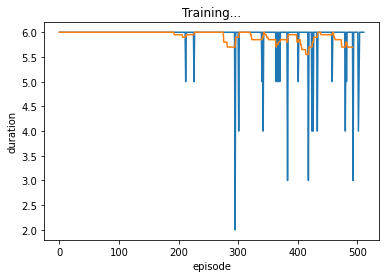

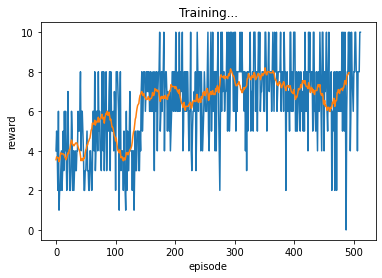

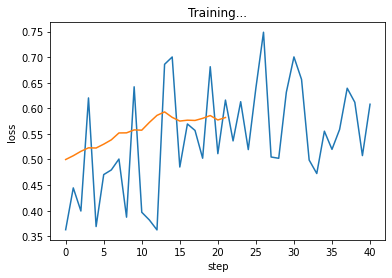

In [130]:
plot_all(*run_experiment(
    model={'name': 'nn'},
    value_function='hybrid',
    eps=[0.9, 0.05, 500],
    gamma=0.0,
    num_episodes=512,
    batch_size=64
    ))

=========================episode 0 cream======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 2801 esses [1.         0.4        0.72554745 1.         1.        ]-------
=======esses (cream) => [1. 0. 0. 0. 0.]= 0 =======
reward 1.0 done False 
returning random index 9354
------guess 1 9354 tiros [0.         0.8        0.60373074 0.         1.        ]-------
=======tiros (cream) => [0. 0. 1. 0. 0.]= 1.0 =======
reward 0 done False 
returning random index 1496
------guess 2 1496 ceric [0.5        0.2        0.60940795 0.33333333 1.        ]-------
=======ceric (cream) => [2. 1. 1. 0. 0.]= 1.0 =======
reward 3.0 done False 
returning random index 12416
------guess 3 12416 owing [0.         0.6        0.40648824 0.         0.        ]-------
=======owing (cream) => [0. 0. 0. 0. 0.]= 4.0 =======
reward 0 done False 
returning random index 944
------guess 4 944 blatt [0.25       0.6        0.55750203 0.33333333 1.        ]-------
=======blatt (cream) => [0. 0

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 9014 taata [0.2        0.         0.71289538 1.         1.        ]-------
=======taata (bayou) => [0. 2. 0. 0. 0.]= 2.0 =======
reward 0 done True 
episode finished.  reward [2.] eps 0.842534746920056
hybrid rewards [array([0.]), array([1.6]), array([0.]), array([0.]), array([0.]), array([0.])] vs. [array([0]), array([2.]), array([0]), array([0]), array([0]), array([0])]
=========================episode 6 smoky======================
returning random index 11883
------guess 0 11883 caper [1.         1.         0.64152474 0.         0.        ]-------
=======caper (smoky) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
returning random index 11908
------guess 1 11908 beard [0.         0.4        0.61394972 0.         0.        ]-------
=======beard (smoky) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
returning random index 2457
------guess 2 2457 doura [0.         0.4        0.56642336 0.   

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 9014 taata [0.5        0.2        0.71289538 1.         1.        ]-------
=======taata (prowl) => [0. 0. 0. 0. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 2801 esses [0.33333333 0.         0.72554745 1.         1.        ]-------
=======esses (prowl) => [0. 0. 0. 0. 0.]= 1.0 =======
reward 0 done False 
returning random index 1800
------guess 4 1800 conky [0.75       0.8        0.39594485 0.         1.        ]-------
=======conky (prowl) => [0. 1. 0. 0. 0.]= 1.0 =======
reward 0 done False 
returning random index 7035
------guess 5 7035 poult [0.4        0.6        0.49245742 0.         1.        ]-------
=======poult (prowl) => [2. 1. 0. 1. 0.]= 1.0 =======
reward 3.0 done True 
episode finished.  reward [4.] eps 0.787478068013027
hybrid rewards [array([0.]), array([0.8]), array([0.]), array([0.]), array([0.]), array([2.4])] vs. [array([0]), 

reward 4.0 done False 
returning random index 6862
------guess 1 6862 pises [0.         0.6        0.58540146 0.33333333 1.        ]-------
=======pises (bagel) => [0. 0. 0. 2. 0.]= 4.0 =======
reward 0 done False 
returning random index 5233
------guess 2 5233 loams [0.         0.6        0.55750203 0.         1.        ]-------
=======loams (bagel) => [1. 0. 1. 0. 0.]= 4.0 =======
reward 0 done False 
returning random index 6988
------guess 3 6988 poops [0.         0.         0.47218167 0.66666667 1.        ]-------
=======poops (bagel) => [0. 0. 0. 0. 0.]= 4.0 =======
reward 0 done False 
returning random index 5918
------guess 4 5918 mudir [0.25       0.6        0.44541768 0.         1.        ]-------
=======mudir (bagel) => [0. 0. 0. 0. 0.]= 4.0 =======
reward 0 done False 
returning random index 11913
------guess 5 11913 glare [0.2        0.2        0.67169505 0.         0.        ]-------
=======glare (bagel) => [1. 1. 1. 0. 1.]= 4.0 =======
reward 0 done True 
episode finished

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11432 poppy [1.         0.6        0.36982968 0.66666667 0.        ]-------
=======poppy (dusky) => [0. 0. 0. 0. 2.]= 0.0 =======
reward 2.0 done False 
returning random index 10082
------guess 2 10082 wands [0.         0.8        0.45596107 0.         1.        ]-------
=======wands (dusky) => [0. 0. 0. 1. 1.]= 2.0 =======
reward 0 done False 
returning random index 9337
------guess 3 9337 tinas [0.         0.4        0.58767234 0.         1.        ]-------
=======tinas (dusky) => [0. 0. 0. 0. 1.]= 2.0 =======
reward 0 done False 
returning random index 7513
------guess 4 7513 reney [0.5        0.4        0.7080292  0.33333333 1.        ]-------
=======reney (dusky) => [0. 0. 0. 0. 2.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12695 slyly [0.8        0.2        0.47964315 0.66666667 0.        ]-------
=======slyly (dusky) => [1. 0. 0. 0. 2.]= 2.0 

reward 4.0 done False 
returning random index 7463
------guess 1 7463 reefs [0.         0.8        0.69164639 0.33333333 1.        ]-------
=======reefs (filmy) => [0. 0. 0. 1. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11290 filmy [1.         0.4        0.38296837 0.         0.        ]-------
=======filmy (filmy) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.6537959740028007
hybrid rewards [array([4.792]), array([0.]), array([7.188])] vs. [array([4.]), array([0]), array([6.])]
=========================episode 30 gecko======================
returning random index 12120
------guess 0 12120 feast [1.         1.         0.62287105 0.         0.        ]-------
=======feast (gecko) => [0. 2. 0. 0. 0.]= 0 =======
reward 2.0 done False 
returning random index 11858
------guess 1 11858 timer [0.         0.6        0.62416869 0.         0.        ]-------
=======timer (gecko) => [0. 0. 0. 

reward 0 done False 
returning random index 7706
------guess 2 7706 rosin [0.         0.6        0.57875101 0.         1.        ]-------
=======rosin (cache) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11215 daddy [1.         0.4        0.4189781  0.66666667 0.        ]-------
=======daddy (cache) => [0. 2. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11215 daddy [0.75       0.         0.4189781  0.66666667 0.        ]-------
=======daddy (cache) => [0. 2. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12794 mamma [0.6        0.         0.47137064 1.         0.        ]-------
=======mamma (cache) => [0. 2. 0. 0. 0.]= 2.0 =======
reward 0 done True 
episode finished.  reward [2.] eps 0.6141027126158716
hybrid rewards [array([1.6]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]

reward 2.0 done False 
returning random index 5056
------guess 1 5056 leafs [0.         0.8        0.62124899 0.         1.        ]-------
=======leafs (bitty) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
returning random index 9829
------guess 2 9829 usure [0.         0.4        0.60583942 0.33333333 1.        ]-------
=======usure (bitty) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
returning random index 6197
------guess 3 6197 nixie [0.         0.4        0.51695053 0.33333333 1.        ]-------
=======nixie (bitty) => [0. 2. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11977 ditty [1.         0.2        0.47802109 0.33333333 0.        ]-------
=======ditty (bitty) => [0. 2. 2. 2. 2.]= 2.0 =======
reward 6.0 done False 
returning random index 6171
------guess 5 6171 nimbi [0.4        0.2        0.40778589 0.33333333 1.        ]-------
=======nimbi (bitty) => [0. 2. 0. 1. 0.]= 8.0 =======
reward 0 done 

reward 0 done False 
returning random index 6942
------guess 2 6942 pokal [0.         0.6        0.49132198 0.         1.        ]-------
=======pokal (guilt) => [0. 0. 0. 0. 1.]= 0.0 =======
reward 1.0 done False 
returning random index 2916
------guess 3 2916 farms [0.         0.2        0.50170316 0.         1.        ]-------
=======farms (guilt) => [0. 0. 0. 0. 0.]= 1.0 =======
reward 0 done False 
returning random index 7636
------guess 4 7636 rizas [0.         0.4        0.52846715 0.         1.        ]-------
=======rizas (guilt) => [0. 1. 0. 0. 0.]= 1.0 =======
reward 0 done False 
returning random index 9681
------guess 5 9681 ugali [0.2        0.4        0.51046229 0.         1.        ]-------
=======ugali (guilt) => [1. 1. 0. 2. 1.]= 1.0 =======
reward 4.0 done True 
episode finished.  reward [5.] eps 0.5453360145178912
hybrid rewards [array([0.]), array([0.]), array([0.8]), array([0.]), array([0.]), array([3.2])] vs. [array([0]), array([0]), array([1.]), array([0]), arra

reward 0 done False 
returning random index 7170
------guess 5 7170 pulka [0.         0.6        0.44476886 0.         1.        ]-------
=======pulka (sheep) => [1. 0. 0. 0. 0.]= 8.0 =======
reward 0 done True 
episode finished.  reward [8.] eps 0.5164898906799225
hybrid rewards [array([1.6]), array([0.]), array([4.8]), array([0.]), array([0.]), array([0.])] vs. [array([2.]), array([0]), array([6.]), array([0]), array([0]), array([0])]
=========================episode 55 piggy======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (piggy) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (piggy) => [0. 0. 0. 1. 0.]= 0.0 =======
reward 1.0 done False 
returning random index 5124
------guess 2 5124 leves [0.5        0.

reward 2.0 done False 
returning random index 3490
------guess 3 3490 gibed [0.         0.6        0.46861314 0.         1.        ]-------
=======gibed (vault) => [0. 0. 0. 0. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11200 vault [1.         0.6        0.49424169 0.         0.        ]-------
=======vault (vault) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.48669558454549855
hybrid rewards [array([1.066]), array([0.]), array([2.132]), array([0.]), array([7.462])] vs. [array([1.]), array([0]), array([2.]), array([0]), array([7.])]
=========================episode 61 aloft======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (aloft) => [0. 1. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12212 cocoa [1.

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (obese) => [1. 0. 0. 0. 2.]= 0.0 =======
reward 3.0 done False 
returning random index 5269
------guess 2 5269 lolog [0.5        0.6        0.52830495 0.66666667 1.        ]-------
=======lolog (obese) => [0. 1. 0. 0. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12116 obese [1.         0.4        0.67639903 0.33333333 0.        ]-------
=======obese (obese) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.4588042149929113
hybrid rewards [array([0.]), array([3.396]), array([0.]), array([7.924])] vs. [array([0]), array([3.]), array([0]), array([7.])]
=========================episode 67 maize======================
returning random index 7973
------guess 0 7973 scats [1.         0.8        0.57145174 0.33333333 1.        

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12604 mealy [1.         0.2        0.59562044 0.         0.        ]-------
=======mealy (mealy) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.43422808571990246
hybrid rewards [array([3.396]), array([0.]), array([0.]), array([7.924])] vs. [array([3.]), array([0]), array([0]), array([7.])]
=========================episode 73 robot======================
returning random index 5187
------guess 0 5187 lined [1.         1.         0.58248175 0.         1.        ]-------
=======lined (robot) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (robot) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12821 rotor [1.         0.6        0.65450122 0.

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (three) => [1. 0. 2. 0. 2.]= 0.0 =======
reward 5.0 done False 
returning random index 953
------guess 2 953 blent [0.5        0.8        0.57372263 0.         1.        ]-------
=======blent (three) => [0. 0. 1. 0. 1.]= 5.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12145 terse [1.         0.2        0.77258719 0.33333333 0.        ]-------
=======terse (three) => [2. 1. 2. 0. 2.]= 5.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11861 three [1.         0.2        0.72716951 0.33333333 0.        ]-------
=======three (three) => [2. 2. 2. 2. 2.]= 7.0 =======
reward 3.0 done True 
episode finished.  reward [10.] eps 0.4089691133263423
hybrid rewards [array([0.]), array([5.33]), array([0.]), array([2.132]), array([3.198])

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11917 swamp [1.         0.6        0.40973236 0.         0.        ]-------
=======swamp (clamp) => [0. 0. 2. 2. 2.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10839 champ [1.         0.4        0.41005677 0.         0.        ]-------
=======champ (clamp) => [2. 0. 2. 2. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12474 clamp [1.         0.2        0.46358475 0.         0.        ]-------
=======clamp (clamp) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.3873889265020001
hybrid rewards [array([3.198]), array([0.]), array([3.198]), array([2.132]), array([2.132])] vs. [array([3.]), array([0]), array([3.]), array([2.]), array([2.])]
=========================episode 86 woven======================
returning random index 10902
------guess 0 10902 pu

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11191 baker [1.         0.4        0.58426602 0.         0.        ]-------
=======baker (taker) => [0. 2. 2. 2. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12391 maker [1.         0.2        0.58994323 0.         0.        ]-------
=======maker (taker) => [0. 2. 2. 2. 2.]= 8.0 =======
reward 0 done True 
episode finished.  reward [8.] eps 0.3671060782120464
hybrid rewards [array([3.2]), array([0.]), array([1.6]), array([0.]), array([1.6]), array([0.])] vs. [array([4.]), array([0]), array([2.]), array([0]), array([2.]), array([0])]
=========================episode 92 stuck======================
returning random index 9915
------guess 0 9915 verts [1.        1.        0.5974047 0.        1.       ]-------
=======verts (stuck) => [0. 0. 0. 1. 1.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12076

reward 2.0 done False 
returning random index 6478
------guess 2 6478 ouphe [0.         0.4        0.52068127 0.         1.        ]-------
=======ouphe (steam) => [0. 0. 0. 0. 1.]= 4.0 =======
reward 0 done False 
returning random index 3543
------guess 3 3543 glams [0.33333333 0.4        0.48564477 0.         1.        ]-------
=======glams (steam) => [0. 0. 1. 1. 1.]= 4.0 =======
reward 0 done False 
returning random index 7196
------guess 4 7196 purda [0.         0.4        0.50364964 0.         1.        ]-------
=======purda (steam) => [0. 0. 0. 0. 1.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12598 steam [1.         0.2        0.63682076 0.         0.        ]-------
=======steam (steam) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.34625967480459935
hybrid rewards [array([2.]), array([2.]), array([0.]), array([0.]), array([0.]), array([6.])] vs. [array([2.]), array([2.]), array

reward 0 done False 
returning random index 7617
------guess 3 7617 rioja [0.         0.6        0.54014599 0.         1.        ]-------
=======rioja (actor) => [1. 0. 1. 0. 1.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12331 actor [1.         0.         0.62254663 0.         0.        ]-------
=======actor (actor) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.32900685446217465
hybrid rewards [array([2.132]), array([2.132]), array([0.]), array([0.]), array([6.396])] vs. [array([2.]), array([2.]), array([0]), array([0]), array([6.])]
=========================episode 105 arose======================
returning random index 6785
------guess 0 6785 pibal [1.         1.         0.48937551 0.         1.        ]-------
=======pibal (arose) => [0. 0. 0. 1. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12794 mamma [1.         0.2        0.4

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12713 state [1.         0.2        0.70381184 0.33333333 0.        ]-------
=======state (shave) => [2. 0. 2. 0. 2.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12971 shave [1.         0.4        0.55523114 0.         0.        ]-------
=======shave (shave) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.3117098243888625
hybrid rewards [array([1.066]), array([2.132]), array([0.]), array([3.198]), array([4.264])] vs. [array([1.]), array([2.]), array([0]), array([3.]), array([4.])]
=========================episode 111 ghoul======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (ghoul) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
returning random index 11670
------guess 1 11670 donut

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12695 slyly [1.         0.6        0.47964315 0.66666667 0.        ]-------
=======slyly (spoof) => [2. 0. 0. 0. 0.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12215 shush [1.         0.4        0.4189781  0.66666667 0.        ]-------
=======shush (spoof) => [2. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11772 snoop [1.         0.6        0.50592052 0.33333333 0.        ]-------
=======snoop (spoof) => [2. 0. 2. 2. 1.]= 2.0 =======
reward 5.0 done False 
returning random index 10242
------guess 5 10242 wifie [0.2        0.2        0.486618   0.33333333 1.        ]-------
=======wifie (spoof) => [0. 0. 1. 0. 0.]= 7.0 =======
reward 0 done True 
episode finished.  reward [7.] eps 0.2949946440987537
hybrid rewards [array([0.]), array([0.]), array([1.6]), array([0.]), array([4.]), arra

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (skiff) => [0. 0. 0. 1. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11317 onion [1.         0.4        0.53998378 0.66666667 0.        ]-------
=======onion (skiff) => [0. 0. 2. 0. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11671 stilt [1.         0.6        0.57047851 0.33333333 0.        ]-------
=======stilt (skiff) => [2. 0. 2. 0. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11967 swish [1.         0.4        0.42060016 0.33333333 0.        ]-------
=======swish (skiff) => [2. 0. 2. 0. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12316 skiff [1.         0.4        0.32603406 0.333333

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11478 brain [1.         0.4        0.55231144 0.         0.        ]-------
=======brain (inlay) => [0. 0. 1. 1. 1.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11390 inlay [1.         0.4        0.54647202 0.         0.        ]-------
=======inlay (inlay) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.2668566095158936
hybrid rewards [array([1.]), array([0.]), array([0.]), array([2.]), array([0.]), array([7.])] vs. [array([1.]), array([0]), array([0]), array([2.]), array([0]), array([7.])]
=========================episode 130 arose======================
returning random index 4958
------guess 0 4958 laigh [1.         1.         0.49781022 0.         1.        ]-------
=======laigh (arose) => [0. 1. 0. 0. 0.]= 0 =======
reward 1.0 done False 
returning random index 6157
------guess 1 6157 nidus [0.      

reward 6.0 done True 
episode finished.  reward [10.] eps 0.2542278637153971
hybrid rewards [array([0.]), array([2.264]), array([2.264]), array([6.792])] vs. [array([0]), array([2.]), array([2.]), array([6.])]
=========================episode 136 abbot======================
returning random index 5643
------guess 0 5643 merse [1.         0.8        0.70559611 0.33333333 1.        ]-------
=======merse (abbot) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12775 allay [1.         0.6        0.61978913 0.66666667 0.        ]-------
=======allay (abbot) => [2. 0. 0. 0. 0.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12911 attic [1.         0.6        0.58150852 0.33333333 0.        ]-------
=======attic (abbot) => [2. 1. 0. 0. 0.]= 2.0 =======
reward 1.0 done False 
returning random index 7210
------guess 3 7210 puton [0.33333333 0.8        0.46909976 0.         1.   

reward 5.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 10791 click [0.75       0.6        0.41427413 0.33333333 0.        ]-------
=======click (flunk) => [0. 2. 0. 0. 2.]= 6.0 =======
reward 0 done False 
returning random index 4649
------guess 5 4649 kauri [0.         0.2        0.52327656 0.         1.        ]-------
=======kauri (flunk) => [1. 0. 2. 0. 0.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.24118400657232558
hybrid rewards [array([0.]), array([0.8]), array([0.]), array([4.]), array([0.]), array([0.])] vs. [array([0]), array([1.]), array([0]), array([5.]), array([0]), array([0])]
=========================episode 143 basil======================
returning random index 5291
------guess 0 5291 loped [1.       1.       0.562206 0.       1.      ]-------
=======loped (basil) => [1. 0. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12266 salsa [1.         0.4      

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 10667 heath [1.         0.4        0.60324412 0.33333333 0.        ]-------
=======heath (heavy) => [2. 2. 2. 0. 0.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11811 heady [1.         0.4        0.55458232 0.         0.        ]-------
=======heady (heavy) => [2. 2. 2. 0. 2.]= 6.0 =======
reward 2.0 done True 
episode finished.  reward [8.] eps 0.22933155399515726
hybrid rewards [array([0.8]), array([0.]), array([1.6]), array([0.]), array([2.4]), array([1.6])] vs. [array([1.]), array([0]), array([2.]), array([0]), array([3.]), array([2.])]
=========================episode 149 aloft======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (aloft) => [0. 1. 0. 0. 0.]= 0 =======
reward 1.0 done False 
returning random index 4040
------g

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (flier) => [1. 0. 1. 1. 0.]= 0.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12954 riser [1.         0.2        0.70900243 0.33333333 0.        ]-------
=======riser (flier) => [0. 1. 0. 2. 2.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11665 inner [1.         0.2        0.64120032 0.33333333 0.        ]-------
=======inner (flier) => [1. 0. 0. 2. 2.]= 5.0 =======
reward 0 done False 
returning random index 1297
------guess 4 1297 burps [0.25      0.6       0.4351987 0.        1.       ]-------
=======burps (flier) => [0. 0. 1. 0. 0.]= 5.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11415 flier [1.         0.4        0.60859692 0.         0.        ]-------
=======

reward 2.0 done False 
returning random index 7819
------guess 2 7819 sabha [0.5        0.6        0.53479319 0.33333333 1.        ]-------
=======sabha (lumpy) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12309 lumpy [1.         0.8        0.37210057 0.         0.        ]-------
=======lumpy (lumpy) => [2. 2. 2. 2. 2.]= 2.0 =======
reward 8.0 done True 
episode finished.  reward [10.] eps 0.20810136049887246
hybrid rewards [array([0.]), array([2.264]), array([0.]), array([9.056])] vs. [array([0]), array([2.]), array([0]), array([8.])]
=========================episode 162 chute======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (chute) => [0. 0. 0. 0. 2.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12824 latte [1.         0.6        0.711922

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12824 latte [1.         0.6        0.71192214 0.33333333 0.        ]-------
=======latte (cache) => [0. 2. 0. 0. 2.]= 2.0 =======
reward 2.0 done False 
returning random index 7330
------guess 2 7330 rakee [0.5        0.2        0.73868613 0.33333333 1.        ]-------
=======rakee (cache) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10833 masse [1.         0.4        0.6270884  0.33333333 0.        ]-------
=======masse (cache) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11994 cache [1.         0.4        0.57664234 0.33333333 0.        ]-------
=======cache (cache) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.1982998665805526
hybrid rewards [array([2.132]), array([2.132]), array([0.]), array([0.]), array([6.39

reward 6.0 done True 
episode finished.  reward [10.] eps 0.19022332769923672
hybrid rewards [array([2.264]), array([2.264]), array([0.]), array([6.792])] vs. [array([2.]), array([2.]), array([0]), array([6.])]
=========================episode 176 shoal======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (shoal) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (shoal) => [0. 1. 0. 0. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12212 cocoa [1.         0.4        0.55815085 0.66666667 0.        ]-------
=======cocoa (shoal) => [0. 1. 0. 0. 1.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11010 atoll [1.  

reward 0 done False 
returning random index 4150
------guess 4 4150 hooky [0.         0.6        0.4107056  0.33333333 1.        ]-------
=======hooky (rouge) => [0. 2. 0. 0. 0.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 10813 rouge [1.         0.2        0.59432279 0.         0.        ]-------
=======rouge (rouge) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.18126738495293337
hybrid rewards [array([3.]), array([0.]), array([5.]), array([0.]), array([0.]), array([2.])] vs. [array([3.]), array([0]), array([5.]), array([0]), array([0]), array([2.])]
=========================episode 182 cross======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (cross) => [0. 0. 1. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11039 retro [1.         0.4        0.73219789 0.33333333 0.        ]-------
=======retro (react) => [2. 2. 1. 0. 0.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10685 react [1.         0.4        0.70024331 0.         0.        ]-------
=======react (react) => [2. 2. 2. 2. 2.]= 5.0 =======
reward 5.0 done True 
episode finished.  reward [10.] eps 0.17362296756502332
hybrid rewards [array([3.594]), array([2.396]), array([5.99])] vs. [array([3.]), array([2.]), array([5.])]
=========================episode 189 shush======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (shush) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12794 mamma [1.         0.4        0.471370

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11069 trite [1.         0.2        0.69115977 0.33333333 0.        ]-------
=======trite (irate) => [0. 2. 1. 2. 2.]= 4.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11529 irate [1.         0.2        0.73171127 0.         0.        ]-------
=======irate (irate) => [2. 2. 2. 2. 2.]= 7.0 =======
reward 3.0 done True 
episode finished.  reward [10.] eps 0.16619111162869526
hybrid rewards [array([4.792]), array([3.594]), array([3.594])] vs. [array([4.]), array([3.]), array([3.])]
=========================episode 196 trump======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (trump) => [0. 0. 1. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11853 radar [1.         0.4        0.672

reward 2.0 done True 
episode finished.  reward [8.] eps 0.1594246680496336
hybrid rewards [array([2.4]), array([0.]), array([0.]), array([0.]), array([2.4]), array([1.6])] vs. [array([3.]), array([0]), array([0]), array([0]), array([3.]), array([2.])]
=========================episode 202 horde======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (horde) => [0. 0. 2. 0. 2.]= 0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10861 gorge [1.         0.4        0.56901865 0.33333333 0.        ]-------
=======gorge (horde) => [0. 2. 2. 0. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12659 horse [1.         0.4        0.63974047 0.         0.        ]-------
=======horse (horde) => [2. 2. 2. 0. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shap

reward 4.0 done False 
returning random index 5837
------guess 2 5837 moola [0.5        0.4        0.57128954 0.33333333 1.        ]-------
=======moola (vaunt) => [0. 0. 0. 0. 1.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11120 taunt [1.         0.4        0.56431468 0.33333333 0.        ]-------
=======taunt (vaunt) => [0. 2. 2. 2. 2.]= 4.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12052 haunt [1.         0.2        0.50916464 0.         0.        ]-------
=======haunt (vaunt) => [0. 2. 2. 2. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11763 gaunt [1.         0.2        0.49651257 0.         0.        ]-------
=======gaunt (vaunt) => [0. 2. 2. 2. 2.]= 8.0 =======
reward 0 done True 
episode finished.  reward [8.] eps 0.15243580907612697
hybrid rewards [array([0.]), array([3.2]), array([0.]), array([3.2]), array([0.]), arra

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11324 evoke [1.         0.6        0.5811841  0.33333333 0.        ]-------
=======evoke (evoke) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.1468570663980747
hybrid rewards [array([4.528]), array([0.]), array([0.]), array([6.792])] vs. [array([4.]), array([0]), array([0]), array([6.])]
=========================episode 216 solar======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (solar) => [0. 0. 1. 0. 0.]= 0 =======
reward 1.0 done False 
returning random index 10176
------guess 1 10176 wents [0.         0.8        0.55166261 0.         1.        ]-------
=======wents (solar) => [0. 0. 0. 0. 1.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11145 usurp [1.         0.4        0.4653690

reward 6.0 done True 
episode finished.  reward [10.] eps 0.14121654996072142
hybrid rewards [array([1.132]), array([0.]), array([3.396]), array([6.792])] vs. [array([1.]), array([0]), array([3.]), array([6.])]
=========================episode 223 inept======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (inept) => [1. 0. 0. 1. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11495 title [1.         0.4        0.66196269 0.33333333 0.        ]-------
=======title (inept) => [1. 1. 0. 0. 1.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10974 heist [1.         0.4        0.59870235 0.         0.        ]-------
=======heist (inept) => [0. 1. 1. 0. 2.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11181 inept [1.

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11668 level [1.         0.4        0.65806975 0.66666667 0.        ]-------
=======level (given) => [0. 0. 2. 2. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11262 given [1.         0.6        0.47737226 0.         0.        ]-------
=======given (given) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.1355615799031013
hybrid rewards [array([2.264]), array([0.]), array([2.264]), array([6.792])] vs. [array([2.]), array([0]), array([2.]), array([6.])]
=========================episode 230 prize======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (prize) => [0. 0. 1. 1. 2.]= 0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11069 trite [1.   

reward 4.0 done True 
episode finished.  reward [10.] eps 0.13074018037817095
hybrid rewards [array([2.264]), array([0.]), array([4.528]), array([4.528])] vs. [array([2.]), array([0]), array([4.]), array([4.])]
=========================episode 236 elder======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (elder) => [2. 1. 1. 0. 0.]= 0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11394 eater [1.         0.4        0.82287105 0.33333333 0.        ]-------
=======eater (elder) => [2. 0. 0. 2. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10890 elder [1.         0.4        0.72619627 0.33333333 0.        ]-------
=======elder (elder) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.130257189716857
hybrid rewards [array([4.

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11777 array [1.         0.4        0.67818329 0.66666667 0.        ]-------
=======array (harsh) => [1. 0. 2. 0. 0.]= 2.0 =======
reward 1.0 done False 
returning random index 9628
------guess 2 9628 tutus [0.         0.6        0.49651257 0.66666667 1.        ]-------
=======tutus (harsh) => [0. 0. 0. 0. 1.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12371 harsh [1.         0.2        0.53933496 0.33333333 0.        ]-------
=======harsh (harsh) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.12543235915681963
hybrid rewards [array([2.264]), array([1.132]), array([0.]), array([7.924])] vs. [array([2.]), array([1.]), array([0]), array([7.])]
=========================episode 243 miner======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11777 array [1.         0.4        0.67818329 0.66666667 0.        ]-------
=======array (forty) => [0. 0. 2. 0. 2.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12060 burly [1.         0.6        0.45271695 0.         0.        ]-------
=======burly (forty) => [0. 0. 2. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12468 wordy [1.        0.6       0.4324412 0.        0.       ]-------
=======wordy (forty) => [0. 2. 2. 0. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11964 forty [1.         0.4        0.49261963 0.         0.        ]-------
=======forty (forty) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.12061455957302938
hybrid rewards [array([2.132]), array([2.132]), array([0.]), arra

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12748 mower [1.         0.2        0.55101379 0.         0.        ]-------
=======mower (cower) => [0. 2. 2. 2. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11073 power [1.         0.2        0.55928629 0.         0.        ]-------
=======power (cower) => [0. 2. 2. 2. 2.]= 8.0 =======
reward 0 done True 
episode finished.  reward [8.] eps 0.11650228776055116
hybrid rewards [array([1.6]), array([0.]), array([4.]), array([0.8]), array([0.]), array([0.])] vs. [array([2.]), array([0]), array([5.]), array([1.]), array([0]), array([0])]
=========================episode 254 fungi======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (fungi) => [0. 0. 0. 1. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (1

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12618 sinew [1.         0.2        0.54225466 0.         0.        ]-------
=======sinew (sinew) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.11275488034967096
hybrid rewards [array([2.264]), array([1.132]), array([0.]), array([7.924])] vs. [array([2.]), array([1.]), array([0]), array([7.])]
=========================episode 261 noble======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (noble) => [0. 0. 0. 0. 2.]= 0 =======
reward 2.0 done False 
returning random index 2378
------guess 1 2378 dolce [1.         0.8        0.58004866 0.         1.        ]-------
=======dolce (noble) => [0. 2. 1. 0. 2.]= 2.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11269 loose [1.         0.2        0.66

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12324 cubic [1.         0.6        0.38491484 0.33333333 0.        ]-------
=======cubic (basis) => [0. 0. 1. 2. 0.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12317 basis [1.         0.4        0.53025142 0.33333333 0.        ]-------
=======basis (basis) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.1088643915129441
hybrid rewards [array([2.132]), array([0.]), array([0.]), array([1.066]), array([7.462])] vs. [array([2.]), array([0]), array([0]), array([1.]), array([7.])]
=========================episode 267 radar======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (radar) => [0. 0. 1. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------g

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (twang) => [0. 1. 0. 0. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12212 cocoa [1.         0.4        0.55815085 0.66666667 0.        ]-------
=======cocoa (twang) => [0. 0. 0. 0. 1.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10691 staff [1.         0.6        0.46017843 0.33333333 0.        ]-------
=======staff (twang) => [0. 1. 2. 0. 0.]= 1.0 =======
reward 2.0 done False 
returning random index 11163
------guess 4 11163 catch [0.25       0.2        0.49489051 0.33333333 0.        ]-------
=======catch (twang) => [0. 1. 1. 0. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11098 twang [1.         0.6        0.45239254 0.         0.        ]-------


reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11317 onion [1.         0.4        0.53998378 0.66666667 0.        ]-------
=======onion (silly) => [0. 0. 1. 0. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10659 sissy [1.         0.4        0.50332522 0.66666667 0.        ]-------
=======sissy (silly) => [2. 2. 0. 0. 2.]= 1.0 =======
reward 5.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11678 silly [1.         0.2        0.51954582 0.33333333 0.        ]-------
=======silly (silly) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.10210372011058236
hybrid rewards [array([1.132]), array([0.]), array([5.66]), array([4.528])] vs. [array([1.]), array([0]), array([5.]), array([4.])]
=========================episode 282 curvy======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1. 

reward 0 done False 
returning random index 1627
------guess 2 1627 cions [0.         0.6        0.51030008 0.         1.        ]-------
=======cions (poser) => [0. 0. 1. 0. 1.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10699 sower [1.         0.2        0.60827251 0.         0.        ]-------
=======sower (poser) => [1. 2. 0. 2. 2.]= 2.0 =======
reward 5.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11563 poser [1.         0.2        0.63617194 0.         0.        ]-------
=======poser (poser) => [2. 2. 2. 2. 2.]= 7.0 =======
reward 3.0 done True 
episode finished.  reward [10.] eps 0.09897139487008905
hybrid rewards [array([2.132]), array([0.]), array([0.]), array([5.33]), array([3.198])] vs. [array([2.]), array([0]), array([0]), array([5.]), array([3.])]
=========================episode 288 dandy======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11413 decay [1.         0.6        0.56885645 0.         0.        ]-------
=======decay (pecan) => [0. 2. 2. 2. 0.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12739 pecan [1.         0.4        0.58896999 0.         0.        ]-------
=======pecan (pecan) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.09611952284879949
hybrid rewards [array([2.]), array([2.]), array([0.]), array([0.]), array([2.]), array([4.])] vs. [array([2.]), array([2.]), array([0]), array([0]), array([2.]), array([4.])]
=========================episode 294 jumpy======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (jumpy) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (1

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12398 sense [1.         0.4        0.71030008 0.66666667 0.        ]-------
=======sense (these) => [0. 1. 0. 2. 2.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12116 obese [1.         0.4        0.67639903 0.33333333 0.        ]-------
=======obese (these) => [0. 0. 2. 2. 2.]= 5.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12176 these [1.         0.4        0.68986212 0.33333333 0.        ]-------
=======these (these) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.09334695027255724
hybrid rewards [array([3.396]), array([2.264]), array([1.132]), array([4.528])] vs. [array([3.]), array([2.]), array([1.]), array([4.])]
=========================episode 302 store======================
returning random index 12206
------guess 0 12206 glade [1.         1.   

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12663 fizzy [1.         0.4        0.22806164 0.33333333 0.        ]-------
=======fizzy (fifty) => [2. 2. 0. 0. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12397 fifty [1.         0.2        0.37064071 0.33333333 0.        ]-------
=======fifty (fifty) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.0908226204057345
hybrid rewards [array([1.066]), array([0.]), array([3.198]), array([2.132]), array([4.264])] vs. [array([1.]), array([0]), array([3.]), array([2.]), array([4.])]
=========================episode 308 liner======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (liner) => [1. 0. 1. 1. 0.]= 0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
-

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11853 radar [1.         0.4        0.6729927  0.66666667 0.        ]-------
=======radar (snarl) => [1. 1. 0. 0. 0.]= 1.0 =======
reward 1.0 done False 
returning random index 3625
------guess 2 3625 gogga [0.         0.4        0.4324412  0.66666667 1.        ]-------
=======gogga (snarl) => [0. 0. 0. 0. 1.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12822 crack [1.         0.4        0.49343066 0.33333333 0.        ]-------
=======crack (snarl) => [0. 1. 2. 0. 0.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 10741 start [1.         0.4        0.64963504 0.33333333 0.        ]-------
=======start (snarl) => [2. 0. 2. 2. 0.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11803 swarm [1.         0.4        0.49602595 0.         0.        ]------

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11994 cache [1.         0.4        0.57664234 0.33333333 0.        ]-------
=======cache (gauze) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done False 
returning random index 7543
------guess 4 7543 rests [0.         0.         0.681103   0.33333333 1.        ]-------
=======rests (gauze) => [0. 1. 0. 0. 0.]= 4.0 =======
reward 0 done False 
returning random index 3943
------guess 5 3943 haufs [0.         0.4        0.44347121 0.         1.        ]-------
=======haufs (gauze) => [0. 2. 2. 0. 0.]= 4.0 =======
reward 0 done True 
episode finished.  reward [4.] eps 0.0859179205095246
hybrid rewards [array([1.6]), array([1.6]), array([0.]), array([0.]), array([0.]), array([0.])] vs. [array([2.]), array([2.]), array([0]), array([0]), array([0]), array([0])]
=========================episode 321 chore======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12736 leech [1.         0.4        0.65709651 0.33333333 0.        ]-------
=======leech (leech) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.083893943800852
hybrid rewards [array([3.396]), array([0.]), array([1.132]), array([6.792])] vs. [array([3.]), array([0]), array([1.]), array([6.])]
=========================episode 327 kayak======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (kayak) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (kayak) => [0. 2. 0. 0. 1.]= 0.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11030 cacao [1.    

reward 3.0 done True 
episode finished.  reward [10.] eps 0.0819201141749401
hybrid rewards [array([2.]), array([0.]), array([2.]), array([0.]), array([3.]), array([3.])] vs. [array([2.]), array([0]), array([2.]), array([0]), array([3.]), array([3.])]
=========================episode 333 dairy======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (dairy) => [0. 0. 1. 1. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11007 tiara [1.         0.4        0.69051095 0.33333333 0.        ]-------
=======tiara (dairy) => [0. 1. 1. 2. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12343 cairn [1.         0.4        0.58410381 0.         0.        ]-------
=======cairn (dairy) => [0. 2. 2. 2. 0.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape

reward 0 done False 
returning random index 9068
------guess 1 9068 talus [1.         1.         0.57793998 0.         1.        ]-------
=======talus (stunt) => [1. 0. 0. 1. 1.]= 0.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11874 stunt [1.         0.2        0.51403082 0.33333333 0.        ]-------
=======stunt (stunt) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.08000116905744387
hybrid rewards [array([0.]), array([3.594]), array([8.386])] vs. [array([0]), array([3.]), array([7.])]
=========================episode 341 slime======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (slime) => [0. 0. 0. 1. 2.]= 0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11495 title [1.         0.4        0.66196269 0.33333333 0.        ]

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12197 femme [1.         0.4        0.53982157 0.66666667 0.        ]-------
=======femme (hedge) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12712 deuce [1.         0.6        0.61686942 0.33333333 0.        ]-------
=======deuce (hedge) => [1. 2. 0. 0. 2.]= 4.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12721 hedge [1.         0.4        0.57729116 0.33333333 0.        ]-------
=======hedge (hedge) => [2. 2. 2. 2. 2.]= 5.0 =======
reward 5.0 done True 
episode finished.  reward [10.] eps 0.0780850203195039
hybrid rewards [array([4.]), array([0.]), array([0.]), array([0.]), array([1.]), array([5.])] vs. [array([4.]), array([0]), array([0]), array([0]), array([1.]), array([5.])]
=========================episode 347 rebel======================
states shape (12972, 3) actions shape (1

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12963 untie [1.         0.6        0.59610706 0.         0.        ]-------
=======untie (movie) => [0. 0. 0. 2. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10930 movie [1.         0.6        0.50721817 0.         0.        ]-------
=======movie (movie) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.07650242794826127
hybrid rewards [array([4.528]), array([0.]), array([0.]), array([6.792])] vs. [array([4.]), array([0]), array([0]), array([6.])]
=========================episode 354 throw======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (throw) => [0. 0. 2. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11777 array [1.        

reward 4.0 done True 
episode finished.  reward [10.] eps 0.07505908282119644
hybrid rewards [array([7.188]), array([0.]), array([4.792])] vs. [array([6.]), array([0]), array([4.])]
=========================episode 361 mange======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (mange) => [0. 0. 0. 0. 2.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12824 latte [1.         0.6        0.71192214 0.33333333 0.        ]-------
=======latte (mange) => [0. 2. 0. 0. 2.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10833 masse [1.         0.4        0.6270884  0.33333333 0.        ]-------
=======masse (mange) => [2. 2. 0. 0. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11925 mange [1.         0.4        0.5537712

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12695 slyly [1.         0.6        0.47964315 0.66666667 0.        ]-------
=======slyly (swung) => [2. 0. 0. 0. 0.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11743 snuff [1.         0.6        0.35214923 0.33333333 0.        ]-------
=======snuff (swung) => [2. 1. 2. 0. 0.]= 2.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12021 skunk [1.         0.2        0.34566099 0.33333333 0.        ]-------
=======skunk (swung) => [2. 0. 2. 2. 0.]= 5.0 =======
reward 1.0 done True 
episode finished.  reward [6.] eps 0.0734585808597619
hybrid rewards [array([0.]), array([0.]), array([0.]), array([1.6]), array([2.4]), array([0.8])] vs. [array([0]), array([0]), array([0]), array([2.]), array([3.]), array([1.])]
=========================episode 368 gaffe======================
states shape (12972, 3) actions shap

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11697 piggy [1.         0.4        0.33819951 0.33333333 0.        ]-------
=======piggy (picky) => [2. 2. 0. 0. 2.]= 4.0 =======
reward 2.0 done True 
episode finished.  reward [6.] eps 0.0721366885952562
hybrid rewards [array([0.8]), array([0.]), array([2.4]), array([0.]), array([0.]), array([1.6])] vs. [array([1.]), array([0]), array([3.]), array([0]), array([0]), array([2.])]
=========================episode 374 utter======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (utter) => [1. 0. 1. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11672 arena [1.         0.4        0.756691   0.33333333 0.        ]-------
=======arena (utter) => [0. 1. 1. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (1

reward 6.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12529 belie [1.         0.4        0.67104623 0.33333333 0.        ]-------
=======belie (belie) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.07080589478090477
hybrid rewards [array([7.584]), array([5.056])] vs. [array([6.]), array([4.])]
=========================episode 381 livid======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (livid) => [0. 0. 0. 2. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12425 minim [1.         0.4        0.4134631  0.66666667 0.        ]-------
=======minim (livid) => [0. 2. 0. 2. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10753 civic [1.         0.4        0.3972425  0.66666667 0.        ]-

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11779 vapid [1.         0.6        0.41573398 0.         0.        ]-------
=======vapid (avoid) => [1. 1. 0. 2. 2.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12639 avoid [1.        0.2       0.4785077 0.        0.       ]-------
=======avoid (avoid) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.06951603332419899
hybrid rewards [array([2.132]), array([0.]), array([1.066]), array([3.198]), array([4.264])] vs. [array([2.]), array([0]), array([1.]), array([3.]), array([4.])]
=========================episode 387 bleak======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (bleak) => [1. 0. 0. 0. 0.]= 0 =======
reward 1.0 done False 
returning random index 10267
------guess 1 10267 winns

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12548 wreak [1.        0.4       0.5703163 0.        0.       ]-------
=======wreak (cream) => [0. 2. 2. 2. 0.]= 5.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11684 bread [1.         0.4        0.61394972 0.         0.        ]-------
=======bread (cream) => [0. 2. 2. 2. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11302 cream [1.         0.4        0.63325223 0.         0.        ]-------
=======cream (cream) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.06834278573945923
hybrid rewards [array([2.132]), array([3.198]), array([1.066]), array([0.]), array([4.264])] vs. [array([2.]), array([3.]), array([1.]), array([0]), array([4.])]
=========================episode 394 basis======================
states shape (12972, 3) actions shape (12972, 5)
-----

reward 2.0 done True 
episode finished.  reward [10.] eps 0.06734382177791097
hybrid rewards [array([2.132]), array([0.]), array([4.264]), array([2.132]), array([2.132])] vs. [array([2.]), array([0]), array([4.]), array([2.]), array([2.])]
=========================episode 400 downy======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (downy) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (downy) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
returning random index 10938
------guess 2 10938 chest [0.5        0.8        0.56723439 0.         0.        ]-------
=======chest (downy) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11432 poppy 

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11372 freer [1.         0.2        0.72895377 0.66666667 0.        ]-------
=======freer (freer) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.06630116128061311
hybrid rewards [array([3.792]), array([8.848])] vs. [array([3.]), array([7.])]
=========================episode 407 augur======================
returning random index 4312
------guess 0 4312 imide [1.         0.8        0.53268451 0.33333333 1.        ]-------
=======imide (augur) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11777 array [1.         0.6        0.67818329 0.66666667 0.        ]-------
=======array (augur) => [2. 1. 0. 0. 0.]= 0.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11063 augur [1.         0.4        0.50656934 0.33333333 0.        ]-------
=======augur (aug

reward 0 done True 
episode finished.  reward [6.] eps 0.06535185555031822
hybrid rewards [array([0.8]), array([1.6]), array([0.8]), array([1.6]), array([0.]), array([0.])] vs. [array([1.]), array([2.]), array([1.]), array([2.]), array([0]), array([0])]
=========================episode 414 chafe======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (chafe) => [0. 0. 0. 0. 2.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12824 latte [1.         0.6        0.71192214 0.33333333 0.        ]-------
=======latte (chafe) => [0. 1. 0. 0. 2.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11538 amaze [1.         0.4        0.57534469 0.33333333 0.        ]-------
=======amaze (chafe) => [0. 0. 2. 0. 2.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions sha

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12597 stall [1.         0.6        0.6188159  0.33333333 0.        ]-------
=======stall (blank) => [0. 0. 2. 1. 0.]= 1.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12780 flaky [1.         0.6        0.41573398 0.         0.        ]-------
=======flaky (blank) => [0. 2. 2. 1. 0.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11694 blank [1.         0.4        0.44833739 0.         0.        ]-------
=======blank (blank) => [2. 2. 2. 2. 2.]= 5.0 =======
reward 5.0 done True 
episode finished.  reward [10.] eps 0.06437134580479949
hybrid rewards [array([0.]), array([1.]), array([0.]), array([2.]), array([2.]), array([5.])] vs. [array([0]), array([1.]), array([0]), array([2.]), array([2.]), array([5.])]
=========================episode 421 noose======================
states shape (12972, 3) actions shap

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12597 stall [1.         0.6        0.6188159  0.33333333 0.        ]-------
=======stall (shank) => [2. 0. 2. 0. 0.]= 1.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12046 shaky [1.         0.6        0.43341444 0.         0.        ]-------
=======shaky (shank) => [2. 2. 2. 1. 0.]= 4.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11696 shank [1.         0.2        0.45774534 0.         0.        ]-------
=======shank (shank) => [2. 2. 2. 2. 2.]= 7.0 =======
reward 3.0 done True 
episode finished.  reward [10.] eps 0.06353442377883495
hybrid rewards [array([0.]), array([1.]), array([0.]), array([3.]), array([3.]), array([3.])] vs. [array([0]), array([1.]), array([0]), array([3.]), array([3.]), array([3.])]
=========================episode 428 brave======================
returning random index 9744
------gu

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12936 hello [1.         0.2        0.61865369 0.33333333 0.        ]-------
=======hello (cello) => [0. 2. 2. 2. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12553 cello [1.         0.2        0.63292782 0.33333333 0.        ]-------
=======cello (cello) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.06274624029740605
hybrid rewards [array([2.]), array([2.]), array([2.]), array([0.]), array([2.]), array([2.])] vs. [array([2.]), array([2.]), array([2.]), array([0]), array([2.]), array([2.])]
=========================episode 434 ember======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (ember) => [2. 1. 1. 0. 0.]= 0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape

reward 5.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11610 check [1.         0.2        0.45190592 0.33333333 0.        ]-------
=======check (check) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.06202798898666403
hybrid rewards [array([1.066]), array([0.]), array([0.]), array([5.33]), array([4.264])] vs. [array([1.]), array([0]), array([0]), array([5.]), array([4.])]
=========================episode 441 elope======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (elope) => [2. 0. 0. 0. 2.]= 0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11324 evoke [1.         0.6        0.5811841  0.33333333 0.        ]-------
=======evoke (elope) => [2. 0. 2. 0. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
-----

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12630 tonic [1.         0.2        0.52003244 0.         0.        ]-------
=======tonic (tonic) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.061327533437982126
hybrid rewards [array([2.264]), array([2.264]), array([4.528]), array([2.264])] vs. [array([2.]), array([2.]), array([4.]), array([2.])]
=========================episode 448 thief======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (thief) => [1. 0. 0. 1. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11495 title [1.         0.4        0.66196269 0.33333333 0.        ]-------
=======title (thief) => [2. 1. 0. 0. 1.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11953 thie

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11688 quill [1.         0.2        0.42254663 0.33333333 0.        ]-------
=======quill (quill) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.06064655482791323
hybrid rewards [array([1.]), array([1.]), array([0.]), array([4.]), array([0.]), array([4.])] vs. [array([1.]), array([1.]), array([0]), array([4.]), array([0]), array([4.])]
=========================episode 454 thump======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (thump) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (thump) => [0. 0. 0. 2. 0.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (1

reward 6.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 10699 sower [1.         0.2        0.60827251 0.         0.        ]-------
=======sower (sower) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.06002654774178883
hybrid rewards [array([2.132]), array([0.]), array([0.]), array([6.396]), array([2.132])] vs. [array([2.]), array([0]), array([0]), array([6.]), array([2.])]
=========================episode 461 marsh======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (marsh) => [0. 0. 2. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11777 array [1.         0.4        0.67818329 0.66666667 0.        ]-------
=======array (marsh) => [1. 0. 2. 0. 0.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
----

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 10905 tacit [1.         0.4        0.58150852 0.33333333 0.        ]-------
=======tacit (tacit) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.05944264705750596
hybrid rewards [array([2.132]), array([0.]), array([2.132]), array([0.]), array([6.396])] vs. [array([2.]), array([0]), array([2.]), array([0]), array([6.])]
=========================episode 468 essay======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (essay) => [2. 0. 0. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10762 essay [1.         0.6        0.64476886 0.33333333 0.        ]-------
=======essay (essay) => [2. 2. 2. 2. 2.]= 2.0 =======
reward 8.0 done True 
episode finished.  reward [10.] eps 0.05940495190983148


reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12824 latte [1.         0.6        0.71192214 0.33333333 0.        ]-------
=======latte (dwelt) => [1. 0. 1. 0. 1.]= 1.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11282 spelt [1.         0.4        0.60291971 0.         0.        ]-------
=======spelt (dwelt) => [0. 0. 2. 2. 2.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11534 dwelt [1.         0.4        0.53025142 0.         0.        ]-------
=======dwelt (dwelt) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.058874982375358084
hybrid rewards [array([1.132]), array([2.264]), array([3.396]), array([4.528])] vs. [array([1.]), array([2.]), array([3.]), array([4.])]
=========================episode 476 bosom======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 ee

reward 6.0 done True 
episode finished.  reward [10.] eps 0.05839164316623858
hybrid rewards [array([0.]), array([2.264]), array([2.264]), array([6.792])] vs. [array([0]), array([2.]), array([2.]), array([6.])]
=========================episode 482 juicy======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (juicy) => [0. 0. 0. 1. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11317 onion [1.         0.4        0.53998378 0.66666667 0.        ]-------
=======onion (juicy) => [0. 0. 2. 0. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12519 amiss [1.         0.6        0.53592863 0.33333333 0.        ]-------
=======amiss (juicy) => [0. 0. 2. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12213 guilt [1.  

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11853 radar [1.         0.4        0.6729927  0.66666667 0.        ]-------
=======radar (satyr) => [0. 2. 0. 0. 2.]= 1.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10677 major [1.         0.6        0.48256285 0.         0.        ]-------
=======major (satyr) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12513 satyr [1.         0.6        0.60032441 0.         0.        ]-------
=======satyr (satyr) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.057839980518581045
hybrid rewards [array([1.132]), array([3.396]), array([0.]), array([6.792])] vs. [array([1.]), array([3.]), array([0]), array([6.])]
=========================episode 490 coyly======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1

reward 3.0 done True 
episode finished.  reward [10.] eps 0.05741300840493666
hybrid rewards [array([0.]), array([1.066]), array([3.198]), array([3.198]), array([3.198])] vs. [array([0]), array([1.]), array([3.]), array([3.]), array([3.])]
=========================episode 496 dying======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (dying) => [0. 0. 0. 1. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11317 onion [1.         0.4        0.53998378 0.66666667 0.        ]-------
=======onion (dying) => [0. 1. 2. 0. 0.]= 1.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12627 avian [1.         0.4        0.54452555 0.33333333 0.        ]-------
=======avian (dying) => [0. 0. 2. 0. 1.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
--

reward 5.0 done True 
episode finished.  reward [10.] eps 0.05696735973943847
hybrid rewards [array([2.]), array([1.]), array([1.]), array([0.]), array([1.]), array([5.])] vs. [array([2.]), array([1.]), array([1.]), array([0]), array([1.]), array([5.])]
=========================episode 502 dicey======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (dicey) => [1. 0. 0. 1. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11495 title [1.         0.4        0.66196269 0.33333333 0.        ]-------
=======title (dicey) => [0. 2. 0. 0. 1.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12618 sinew [1.         0.6        0.54225466 0.         0.        ]-------
=======sinew (dicey) => [0. 2. 0. 2. 0.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions sha

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12824 latte [1.         0.6        0.71192214 0.33333333 0.        ]-------
=======latte (snake) => [0. 1. 0. 0. 2.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10683 abase [1.         0.4        0.67169505 0.33333333 0.        ]-------
=======abase (snake) => [0. 0. 2. 1. 2.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11888 space [1.         0.4        0.60421736 0.         0.        ]-------
=======space (snake) => [2. 0. 2. 0. 2.]= 5.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12971 shave [1.         0.4        0.55523114 0.         0.        ]-------
=======shave (snake) => [2. 0. 2. 0. 2.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12247 snake [1.        0.4       0.5946472 0.       

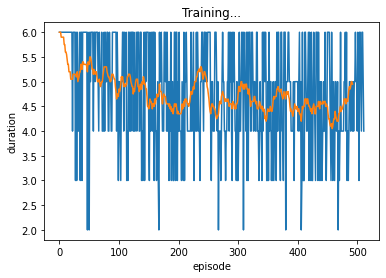

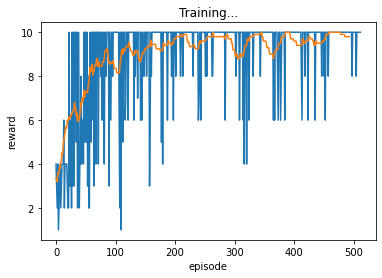

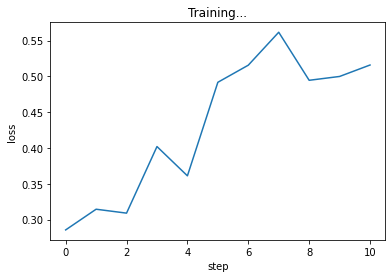

In [131]:
plot_all(*run_experiment(
    model={'name': 'nn'},
    value_function='hybrid',
    eps=[0.9, 0.05, 500],
    gamma=0.2,
    num_episodes=512,
    batch_size=64
    ))

=========================episode 0 brief======================
returning random index 6420
------guess 0 6420 oozes [1.         0.8        0.55961071 0.33333333 1.        ]-------
=======oozes (brief) => [0. 0. 0. 2. 0.]= 0 =======
reward 2.0 done False 
returning random index 7276
------guess 1 7276 quipu [0.         0.8        0.32457421 0.33333333 1.        ]-------
=======quipu (brief) => [0. 0. 2. 0. 0.]= 2.0 =======
reward 0 done False 
returning random index 7298
------guess 2 7298 racon [0.         0.8        0.59756691 0.         1.        ]-------
=======racon (brief) => [1. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
returning random index 4244
------guess 3 4244 huzzy [0.         0.4        0.22076237 0.33333333 1.        ]-------
=======huzzy (brief) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
returning random index 7580
------guess 4 7580 ribby [0.         0.2        0.41476075 0.33333333 1.        ]-------
=======ribby (brief) => [1. 1. 1. 0. 0.]= 2.0 ======

reward 0 done False 
returning random index 6526
------guess 5 6526 pacha [0.         0.6        0.51759935 0.33333333 1.        ]-------
=======pacha (grand) => [0. 1. 0. 0. 0.]= 2.0 =======
reward 0 done True 
episode finished.  reward [2.] eps 0.842534746920056
hybrid rewards [array([1.2]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])] vs. [array([2.]), array([0]), array([0]), array([0]), array([0]), array([0])]
=========================episode 6 corer======================
returning random index 11113
------guess 0 11113 onset [1.         1.         0.64233577 0.         0.        ]-------
=======onset (corer) => [1. 0. 0. 2. 0.]= 0 =======
reward 3.0 done False 
returning random index 2808
------guess 1 2808 etens [0.         0.         0.72003244 0.33333333 1.        ]-------
=======etens (corer) => [1. 0. 0. 0. 0.]= 3.0 =======
reward 0 done False 
returning random index 4101
------guess 2 4101 hohed [1.         0.4        0.51224655 0.33333333 1.        ]----

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 9014 taata [0.33333333 0.         0.71289538 1.         1.        ]-------
=======taata (staid) => [1. 0. 2. 0. 0.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 9014 taata [0.25       0.         0.71289538 1.         1.        ]-------
=======taata (staid) => [1. 0. 2. 0. 0.]= 3.0 =======
reward 0 done False 
returning random index 2914
------guess 5 2914 farle [0.         0.4        0.65855637 0.         1.        ]-------
=======farle (staid) => [0. 1. 0. 0. 0.]= 3.0 =======
reward 0 done True 
episode finished.  reward [3.] eps 0.787478068013027
hybrid rewards [array([0.6]), array([0.]), array([0.6]), array([0.6]), array([0.]), array([0.])] vs. [array([1.]), array([0]), array([1.]), array([1.]), array([0]), array([0])]
=========================episode 12 clink======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 2

reward 4.0 done False 
returning random index 11825
------guess 1 11825 suing [0.         0.8        0.43682076 0.         0.        ]-------
=======suing (taffy) => [0. 0. 0. 0. 0.]= 4.0 =======
reward 0 done False 
returning random index 3622
------guess 2 3622 goety [0.         0.8        0.55993512 0.         1.        ]-------
=======goety (taffy) => [0. 0. 0. 1. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 9014 taata [0.33333333 0.         0.71289538 1.         1.        ]-------
=======taata (taffy) => [2. 2. 0. 0. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 9109 tarry [0.75       0.         0.63763179 0.33333333 1.        ]-------
=======tarry (taffy) => [2. 2. 0. 0. 2.]= 4.0 =======
reward 2.0 done False 
returning random index 12699
------guess 5 12699 sheep [0.         0.4        0.63114355 0.33333333 0.        ]-------
=======sheep (taffy) => [0. 0. 0. 0. 0.]= 6.

reward 0 done False 
returning random index 7591
------guess 5 7591 ridic [0.         0.         0.50462287 0.33333333 1.        ]-------
=======ridic (filth) => [0. 2. 0. 0. 0.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.6962822639717497
hybrid rewards [array([2.4]), array([0.]), array([1.2]), array([0.]), array([0.]), array([0.])] vs. [array([4.]), array([0]), array([2.]), array([0]), array([0]), array([0])]
=========================episode 23 matey======================
returning random index 11036
------guess 0 11036 smite [1.         1.         0.58686131 0.         0.        ]-------
=======smite (matey) => [0. 1. 0. 1. 1.]= 0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 7508 remet [1.         0.2        0.71532847 0.33333333 1.        ]-------
=======remet (matey) => [0. 0. 1. 2. 1.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 5543 mated [1.         

reward 0 done False 
returning random index 5562
------guess 2 5562 mavie [0.         0.4        0.54371452 0.         1.        ]-------
=======mavie (mourn) => [2. 0. 0. 0. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 5866 morro [0.66666667 0.         0.58751014 0.66666667 1.        ]-------
=======morro (mourn) => [2. 2. 0. 2. 0.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 5791 mohrs [0.75       0.4        0.49099757 0.         1.        ]-------
=======mohrs (mourn) => [2. 2. 0. 2. 0.]= 6.0 =======
reward 0 done False 
returning random index 4963
------guess 5 4963 lairy [0.         0.         0.59902676 0.         1.        ]-------
=======lairy (mourn) => [0. 0. 0. 2. 0.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.6513856140405265
hybrid rewards [array([2.4]), array([0.]), array([0.]), array([1.2]), array([0.]), array([0.])] vs. [array([4.]), 

reward 1.0 done True 
episode finished.  reward [2.] eps 0.6163636423111535
hybrid rewards [array([0.]), array([0.6]), array([0.]), array([0.]), array([0.]), array([0.6])] vs. [array([0]), array([1.]), array([0]), array([0]), array([0]), array([1.])]
=========================episode 34 creek======================
returning random index 3441
------guess 0 3441 gelds [1.         1.         0.53933496 0.         1.        ]-------
=======gelds (creek) => [0. 1. 0. 0. 0.]= 0 =======
reward 1.0 done False 
returning random index 7397
------guess 1 7397 rawin [0.         1.         0.53836172 0.         1.        ]-------
=======rawin (creek) => [1. 0. 0. 0. 0.]= 1.0 =======
reward 0 done False 
returning random index 10990
------guess 2 10990 butch [0.         1.         0.38004866 0.         0.        ]-------
=======butch (creek) => [0. 0. 0. 1. 0.]= 1.0 =======
reward 0 done False 
returning random index 12143
------guess 3 12143 welsh [0.         0.         0.51987024 0.         0.     

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 8189 shirr [0.66666667 0.         0.57210057 0.33333333 1.        ]-------
=======shirr (rhino) => [0. 2. 2. 1. 0.]= 5.0 =======
reward 0 done False 
returning random index 8514
------guess 4 8514 snoep [0.         0.6        0.58361719 0.         1.        ]-------
=======snoep (rhino) => [0. 1. 1. 0. 0.]= 5.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 8189 shirr [0.4        0.         0.57210057 0.33333333 1.        ]-------
=======shirr (rhino) => [0. 2. 2. 1. 0.]= 5.0 =======
reward 0 done True 
episode finished.  reward [5.] eps 0.577018867434695
hybrid rewards [array([1.2]), array([0.]), array([1.8]), array([0.]), array([0.]), array([0.])] vs. [array([2.]), array([0]), array([3.]), array([0]), array([0]), array([0])]
=========================episode 40 hymen======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 2801 

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 401 arear [1.         0.4        0.80924574 0.66666667 1.        ]-------
=======arear (thyme) => [0. 0. 1. 0. 0.]= 1.0 =======
reward 0 done False 
returning random index 8508
------guess 2 8508 snipy [0.         0.8        0.43909165 0.         1.        ]-------
=======snipy (thyme) => [0. 0. 0. 0. 1.]= 1.0 =======
reward 0 done False 
returning random index 11719
------guess 3 11719 relay [0.33333333 0.2        0.69018654 0.         0.        ]-------
=======relay (thyme) => [0. 1. 0. 0. 1.]= 1.0 =======
reward 1.0 done False 
returning random index 10835
------guess 4 10835 vital [0.         0.4        0.52733171 0.         0.        ]-------
=======vital (thyme) => [0. 0. 1. 0. 0.]= 2.0 =======
reward 0 done False 
returning random index 2922
------guess 5 2922 fasti [0.         0.2        0.53171127 0.         1.        ]-------
=======fasti (thyme) => [0. 0. 0. 1. 0.]= 2.0 =======
reward 0 don

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 8085 semee [0.5        0.         0.75977291 0.66666667 1.        ]-------
=======semee (pygmy) => [0. 0. 1. 0. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 5526 marra [0.6        0.         0.66050284 0.66666667 1.        ]-------
=======marra (pygmy) => [1. 0. 0. 0. 0.]= 4.0 =======
reward 0 done True 
episode finished.  reward [4.] eps 0.5118482387133249
hybrid rewards [array([0.]), array([0.6]), array([1.8]), array([0.]), array([0.]), array([0.])] vs. [array([0]), array([1.]), array([3.]), array([0]), array([0]), array([0])]
=========================episode 51 piano======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 2801 esses [1.         0.4        0.72554745 1.         1.        ]-------
=======esses (piano) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
-

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (tithe) => [0. 0. 0. 2. 0.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10095 waqfs [0.5        1.         0.34095702 0.         1.        ]-------
=======waqfs (tithe) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 6900 plink [0.66666667 1.         0.41232766 0.         1.        ]-------
=======plink (tithe) => [0. 0. 1. 0. 0.]= 2.0 =======
reward 0 done False 
returning random index 6749
------guess 4 6749 pervy [0.25       0.4        0.49910787 0.         1.        ]-------
=======pervy (tithe) => [0. 1. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 2277 didie [0.8        0.         0.54517437 0.66666667 1.        ]-------
======

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 6468 ottos [1.         0.2        0.58961882 0.66666667 1.        ]-------
=======ottos (cross) => [1. 0. 0. 0. 2.]= 2.0 =======
reward 1.0 done False 
returning random index 2996
------guess 5 2996 ferny [0.         0.4        0.54533658 0.         1.        ]-------
=======ferny (cross) => [0. 0. 1. 0. 0.]= 3.0 =======
reward 0 done True 
episode finished.  reward [3.] eps 0.45473654508969097
hybrid rewards [array([0.]), array([0.6]), array([0.6]), array([0.]), array([0.6]), array([0.])] vs. [array([0]), array([1.]), array([1.]), array([0]), array([1.]), array([0])]
=========================episode 62 booty======================
returning random index 5387
------guess 0 5387 lurry [1.         0.8        0.55296026 0.33333333 1.        ]-------
=======lurry (booty) => [0. 0. 0. 0. 2.]= 0 =======
reward 2.0 done False 
returning random index 2145
------guess 1 2145 deary [0.         0.6        0.6373073

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 245 allel [1.         0.4        0.70867802 0.66666667 1.        ]-------
=======allel (tamer) => [1. 0. 0. 2. 0.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 7380 rater [1.         0.4        0.76869424 0.33333333 1.        ]-------
=======rater (tamer) => [0. 2. 1. 2. 2.]= 3.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 9015 taber [1.         0.2        0.66845093 0.         1.        ]-------
=======taber (tamer) => [2. 2. 0. 2. 2.]= 7.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 9140 tawer [1.         0.2        0.65450122 0.         1.        ]-------
=======tawer (tamer) => [2. 2. 0. 2. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 9136 taver [1.         0.2        0.64768856 0.         1

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 4796 klick [1.         0.2        0.37096513 0.33333333 1.        ]-------
=======klick (click) => [0. 2. 2. 2. 2.]= 4.0 =======
reward 4.0 done False 
returning random index 7218
------guess 5 7218 pygal [0.         0.4        0.45433901 0.         1.        ]-------
=======pygal (click) => [0. 0. 0. 0. 1.]= 8.0 =======
reward 0 done True 
episode finished.  reward [8.] eps 0.40468722666888746
hybrid rewards [array([1.2]), array([1.2]), array([0.]), array([0.]), array([2.4]), array([0.])] vs. [array([2.]), array([2.]), array([0]), array([0]), array([4.]), array([0])]
=========================episode 73 knock======================
returning random index 12923
------guess 0 12923 spied [1.        1.        0.5406326 0.        0.       ]-------
=======spied (knock) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
returning random index 5250
------guess 1 5250 lodes [0.         0.4        0.61119221 0. 

reward 4.0 done False 
returning random index 7300
------guess 1 7300 radix [0.         1.         0.48321168 0.         1.        ]-------
=======radix (maybe) => [0. 2. 0. 0. 0.]= 4.0 =======
reward 0 done False 
returning random index 6548
------guess 2 6548 paire [0.        0.4       0.6729927 0.        1.       ]-------
=======paire (maybe) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done False 
returning random index 7775
------guess 3 7775 rumal [0.         0.2        0.54825629 0.         1.        ]-------
=======rumal (maybe) => [0. 0. 1. 1. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 5432 mache [0.75       0.4        0.55052717 0.         1.        ]-------
=======mache (maybe) => [2. 2. 0. 0. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 5500 manse [0.8        0.4        0.61184104 0.         1.        ]-------
=======manse (maybe) => [2. 2. 0. 0. 2.]= 6.0 =======

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 3642 gonif [1.         0.8        0.41216545 0.         1.        ]-------
=======gonif (doing) => [1. 2. 1. 1. 0.]= 1.0 =======
reward 4.0 done True 
episode finished.  reward [5.] eps 0.36082695716095603
hybrid rewards [array([0.]), array([0.]), array([0.]), array([0.]), array([0.6]), array([2.4])] vs. [array([0]), array([0]), array([0]), array([0]), array([1.]), array([4.])]
=========================episode 84 creep======================
returning random index 10580
------guess 0 10580 zeins [1.         1.         0.51711273 0.         1.        ]-------
=======zeins (creep) => [0. 1. 0. 0. 0.]= 0 =======
reward 1.0 done False 
returning random index 9228
------guess 1 9228 tesla [0.         0.6        0.70218978 0.         1.        ]-------
=======tesla (creep) => [0. 1. 0. 0. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 4558 juked [1.      

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 244 allee [1.         0.4        0.79205191 0.66666667 1.        ]-------
=======allee (plane) => [1. 2. 0. 0. 2.]= 1.0 =======
reward 4.0 done False 
returning random index 7500
------guess 2 7500 rekey [0.         0.         0.64882401 0.33333333 1.        ]-------
=======rekey (plane) => [0. 1. 0. 0. 0.]= 5.0 =======
reward 0 done False 
returning random index 1473
------guess 3 1473 ceder [0.         0.4        0.68694242 0.33333333 1.        ]-------
=======ceder (plane) => [0. 1. 0. 0. 0.]= 5.0 =======
reward 0 done False 
returning random index 1190
------guess 4 1190 brins [0.         0.8        0.50202758 0.         1.        ]-------
=======brins (plane) => [0. 0. 0. 2. 0.]= 5.0 =======
reward 0 done False 
returning random index 1263
------guess 5 1263 bunde [0.4       0.2       0.4783455 0.        1.       ]-------
=======bunde (plane) => [0. 0. 1. 0. 2.]= 5.0 =======
reward 0 done True 
e

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 6918 pluot [1.         0.4        0.49245742 0.         1.        ]-------
=======pluot (flout) => [0. 2. 1. 1. 2.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 3583 glout [1.         0.2        0.48337388 0.         1.        ]-------
=======glout (flout) => [0. 2. 2. 2. 2.]= 6.0 =======
reward 2.0 done True 
episode finished.  reward [8.] eps 0.32239040493592597
hybrid rewards [array([0.]), array([0.6]), array([1.2]), array([0.]), array([1.8]), array([1.2])] vs. [array([0]), array([1.]), array([2.]), array([0]), array([3.]), array([2.])]
=========================episode 95 annul======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 399 areae [1.         0.6        0.86342255 0.66666667 1.        ]-------
=======areae (annul) => [2. 0. 0. 0. 0.]= 0 =======
reward 2.0 done False 
returning random index 11720
------guess

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 245 allel [1.         0.4        0.70867802 0.66666667 1.        ]-------
=======allel (rower) => [0. 0. 0. 2. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 2552 duded [1.         0.4        0.46699108 0.66666667 1.        ]-------
=======duded (rower) => [0. 0. 0. 2. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 9522 trier [1.         0.6        0.71873479 0.33333333 1.        ]-------
=======trier (rower) => [0. 1. 0. 2. 2.]= 2.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 7001 porer [1.         0.4        0.67347932 0.33333333 1.        ]-------
=======porer (rower) => [0. 2. 1. 2. 2.]= 5.0 =======
reward 2.0 done False 
returning random index 2037
------guess 5 2037 cuvee [0.2        0.4        0.57793998 0.33333333 1.        ]-------
=====

reward 4.0 done False 
returning random index 9634
------guess 4 9634 twank [0.         0.6        0.43600973 0.         1.        ]-------
=======twank (ahead) => [0. 0. 1. 0. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 1348 caeca [0.8        0.2        0.67234388 0.66666667 1.        ]-------
=======caeca (ahead) => [0. 1. 2. 0. 1.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.2887068785116228
hybrid rewards [array([0.]), array([0.6]), array([0.6]), array([2.4]), array([0.]), array([0.])] vs. [array([0]), array([1.]), array([1.]), array([4.]), array([0]), array([0])]
=========================episode 106 worse======================
returning random index 8827
------guess 0 8827 stops [1.         0.8        0.51711273 0.33333333 1.        ]-------
=======stops (worse) => [1. 0. 1. 0. 0.]= 0 =======
reward 2.0 done False 
returning random index 2007
------guess 1 2007 cured [0.         1.         0.5626926

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 402 areas [1.         0.4        0.77193836 0.33333333 1.        ]-------
=======areas (copse) => [0. 0. 1. 0. 1.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 8591 soote [1.         0.4        0.67137064 0.33333333 1.        ]-------
=======soote (copse) => [1. 2. 0. 0. 2.]= 2.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 1860 cosie [1.         0.4        0.61703163 0.         1.        ]-------
=======cosie (copse) => [2. 2. 1. 0. 2.]= 5.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 1853 corse [0.75      0.        0.6540146 0.        1.       ]-------
=======corse (copse) => [2. 2. 0. 2. 2.]= 7.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 9230 teste [0.2        0.         0.74501217 0.66666667 1.    

reward 3.0 done False 
returning random index 3275
------guess 4 3275 fuffy [0.         0.2        0.25660989 0.66666667 1.        ]-------
=======fuffy (joker) => [0. 0. 0. 0. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 1810 cooer [1.         0.2        0.66780211 0.33333333 1.        ]-------
=======cooer (joker) => [0. 2. 0. 2. 2.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.2591886234471666
hybrid rewards [array([1.2]), array([0.6]), array([0.]), array([1.8]), array([0.]), array([0.])] vs. [array([2.]), array([1.]), array([0]), array([3.]), array([0]), array([0])]
=========================episode 117 relay======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 2801 esses [1.         0.4        0.72554745 1.         1.        ]-------
=======esses (relay) => [1. 0. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 4

reward 4.0 done False 
returning random index 12864
------guess 1 12864 fussy [0.         0.6        0.39902676 0.33333333 0.        ]-------
=======fussy (speed) => [0. 0. 1. 0. 0.]= 4.0 =======
reward 0 done False 
returning random index 1550
------guess 2 1550 chias [0.5        0.8        0.51662612 0.         1.        ]-------
=======chias (speed) => [0. 0. 0. 0. 1.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 8112 serer [1.         0.2        0.80016221 0.66666667 1.        ]-------
=======serer (speed) => [2. 1. 0. 2. 0.]= 4.0 =======
reward 1.0 done False 
returning random index 11276
------guess 4 11276 sheen [0.75       0.2        0.6648824  0.33333333 0.        ]-------
=======sheen (speed) => [2. 0. 2. 2. 0.]= 5.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 8683 speel [1.         0.4        0.68467153 0.33333333 1.        ]-------
=======speel (speed) => [2. 2. 2. 2. 0.]= 

reward 0 done False 
returning random index 1451
------guess 4 1451 cauda [0.25       0.6        0.53446878 0.33333333 1.        ]-------
=======cauda (tramp) => [0. 1. 0. 0. 0.]= 4.0 =======
reward 0 done False 
returning random index 7912
------guess 5 7912 sared [0.         0.         0.67688564 0.         1.        ]-------
=======sared (tramp) => [0. 1. 1. 0. 0.]= 4.0 =======
reward 0 done True 
episode finished.  reward [4.] eps 0.23332056643097432
hybrid rewards [array([0.]), array([2.4]), array([0.]), array([0.]), array([0.]), array([0.])] vs. [array([0]), array([4.]), array([0]), array([0]), array([0]), array([0])]
=========================episode 128 trice======================
returning random index 7828
------guess 0 7828 saddo [1.         0.8        0.51711273 0.33333333 1.        ]-------
=======saddo (trice) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 6689 peepe [1.         0.4        0.71905921 1.   

reward 1.0 done False 
returning random index 5864
------guess 1 5864 morns [0.         0.8        0.52116788 0.         1.        ]-------
=======morns (perky) => [0. 0. 2. 0. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 445 arret [1.         0.4        0.76869424 0.33333333 1.        ]-------
=======arret (perky) => [0. 0. 2. 1. 0.]= 2.0 =======
reward 1.0 done False 
returning random index 2268
------guess 3 2268 dices [0.         0.6        0.55847526 0.         1.        ]-------
=======dices (perky) => [0. 0. 0. 1. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 3802 gurge [1.         0.4        0.52246553 0.33333333 1.        ]-------
=======gurge (perky) => [0. 0. 2. 0. 1.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 4703 kerky [1.         0.4        0.48288727 0.33333333 1.        ]-------
=======kerky (perky) => [0

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 8519 snool [1.         0.4        0.56301703 0.33333333 1.        ]-------
=======snool (scowl) => [2. 0. 2. 0. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7989 scoog [0.8        0.4        0.48094079 0.33333333 1.        ]-------
=======scoog (scowl) => [2. 2. 2. 0. 0.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.2106513276046344
hybrid rewards [array([0.6]), array([0.]), array([0.]), array([1.8]), array([1.2]), array([0.])] vs. [array([1.]), array([0]), array([0]), array([3.]), array([2.]), array([0])]
=========================episode 139 unfit======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 2801 esses [1.         0.4        0.72554745 1.         1.        ]-------
=======esses (unfit) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (1297

reward 0 done True 
episode finished.  reward [8.] eps 0.20129572261126882
hybrid rewards [array([0.6]), array([1.2]), array([0.]), array([0.6]), array([2.4]), array([0.])] vs. [array([1.]), array([2.]), array([0]), array([1.]), array([4.]), array([0])]
=========================episode 144 throb======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 2801 esses [1.         0.4        0.72554745 1.         1.        ]-------
=======esses (throb) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 9014 taata [1.         0.4        0.71289538 1.         1.        ]-------
=======taata (throb) => [2. 0. 0. 0. 0.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 9534 trior [1.         0.6        0.64103812 0.33333333 1.        ]-------
=======trior (throb) => [2. 1. 0. 2. 0.]= 2.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (1

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 2817 etwee [1.         0.4        0.74987835 0.66666667 1.        ]-------
=======etwee (inert) => [1. 1. 0. 0. 0.]= 1.0 =======
reward 1.0 done False 
returning random index 3651
------guess 2 3651 googs [0.         0.4        0.4540146  0.66666667 1.        ]-------
=======googs (inert) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10479 yitie [1.         0.4        0.60486618 0.33333333 1.        ]-------
=======yitie (inert) => [0. 1. 1. 0. 1.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 7503 relit [1.         0.4        0.68953771 0.         1.        ]-------
=======relit (inert) => [1. 1. 0. 1. 2.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 4283 ident [0.8        0.4        0.58410381 0.         1.        ]-------
=

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 3754 grrrl [1.         0.6        0.60454177 0.66666667 1.        ]-------
=======grrrl (frill) => [0. 2. 0. 0. 2.]= 0.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 7088 prill [1.         0.4        0.54744526 0.33333333 1.        ]-------
=======prill (frill) => [0. 2. 2. 2. 2.]= 4.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 1188 brill [1.         0.2        0.53349554 0.33333333 1.        ]-------
=======brill (frill) => [0. 2. 2. 2. 2.]= 8.0 =======
reward 0 done True 
episode finished.  reward [8.] eps 0.18258664410441217
hybrid rewards [array([0.]), array([0.]), array([0.]), array([2.4]), array([2.4]), array([0.])] vs. [array([0]), array([0]), array([0]), array([4.]), array([4.]), array([0])]
=========================episode 155 infer======================
returning random index 10009
------guess 0

reward 0 done True 
episode finished.  reward [6.] eps 0.1748653990444925
hybrid rewards [array([0.6]), array([0.6]), array([0.]), array([0.6]), array([1.8]), array([0.])] vs. [array([1.]), array([1.]), array([0]), array([1.]), array([3.]), array([0])]
=========================episode 160 taste======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 2801 esses [1.         0.4        0.72554745 1.         1.        ]-------
=======esses (taste) => [1. 0. 2. 0. 0.]= 0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 7369 raser [1.         0.4        0.75896188 0.33333333 1.        ]-------
=======raser (taste) => [0. 2. 2. 1. 0.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 4643 kasme [1.         0.4        0.55263585 0.         1.        ]-------
=======kasme (taste) => [0. 2. 2. 0. 2.]= 5.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 9014 taata [1.         0.4        0.71289538 1.         1.        ]-------
=======taata (party) => [0. 2. 0. 2. 0.]= 0.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 3873 haith [1.         0.4        0.51208435 0.33333333 1.        ]-------
=======haith (party) => [0. 2. 0. 2. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10414 yarto [1.         0.6        0.61411192 0.         1.        ]-------
=======yarto (party) => [1. 2. 2. 2. 0.]= 4.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 666 bantu [0.75       0.6        0.49164639 0.         1.        ]-------
=======bantu (party) => [0. 2. 0. 2. 0.]= 7.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 5478 malty [0.8        0.4        0.51386861 0.         1.  

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 5636 merer [0.66666667 0.         0.74290349 0.66666667 1.        ]-------
=======merer (meter) => [2. 2. 0. 2. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 5636 merer [0.5        0.         0.74290349 0.66666667 1.        ]-------
=======merer (meter) => [2. 2. 0. 2. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 5636 merer [0.4        0.         0.74290349 0.66666667 1.        ]-------
=======merer (meter) => [2. 2. 0. 2. 2.]= 8.0 =======
reward 0 done True 
episode finished.  reward [8.] eps 0.1594246680496336
hybrid rewards [array([1.2]), array([2.4]), array([0.]), array([1.2]), array([0.]), array([0.])] vs. [array([2.]), array([4.]), array([0]), array([2.]), array([0]), array([0])]
=========================episode 171 bused======================
returning random index 7585
------guess 0 7

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 9495 trant [0.8        0.         0.63438767 0.33333333 1.        ]-------
=======trant (trait) => [2. 2. 2. 0. 2.]= 8.0 =======
reward 0 done True 
episode finished.  reward [8.] eps 0.1530522714683744
hybrid rewards [array([0.]), array([0.6]), array([4.2]), array([0.]), array([0.]), array([0.])] vs. [array([0]), array([1.]), array([7.]), array([0]), array([0]), array([0])]
loss 0.32103973627090454
=========================episode 176 bluer======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 2801 esses [1.         0.4        0.72554745 1.         1.        ]-------
=======esses (bluer) => [0. 0. 0. 2. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 245 allel [1.         0.4        0.70867802 0.66666667 1.        ]-------
=======allel (bluer) => [0. 2. 0. 2. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 9014 taata [1.         0.4        0.71289538 1.         1.        ]-------
=======taata (mafia) => [0. 2. 0. 0. 2.]= 0.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 1370 calla [1.         0.4        0.62822384 0.66666667 1.        ]-------
=======calla (mafia) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 5537 massa [1.         0.4        0.58588808 0.66666667 1.        ]-------
=======massa (mafia) => [2. 2. 0. 0. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 5483 mamba [1.         0.2        0.46569343 0.66666667 1.        ]-------
=======mamba (mafia) => [2. 2. 0. 0. 2.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 5448 mahua [1.         0.4        0.50770479 0.33333333 1.  

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 8117 serin [1.         0.4        0.65644769 0.         1.        ]-------
=======serin (surge) => [2. 1. 2. 0. 0.]= 5.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 8733 sprue [1.         0.4        0.58961882 0.         1.        ]-------
=======sprue (surge) => [2. 0. 2. 1. 2.]= 5.0 =======
reward 2.0 done False 
returning random index 8247
------guess 5 8247 sicky [0.         0.6        0.39772912 0.         1.        ]-------
=======sicky (surge) => [2. 0. 0. 0. 0.]= 7.0 =======
reward 0 done True 
episode finished.  reward [7.] eps 0.14030893012378493
hybrid rewards [array([1.2]), array([0.6]), array([1.2]), array([0.]), array([1.2]), array([0.])] vs. [array([2.]), array([1.]), array([2.]), array([0]), array([2.]), array([0])]
loss 0.231346994638443
=========================episode 187 worse======================
states shape (12972, 3) actions shap

reward 1.0 done False 
returning random index 481
------guess 5 481 asses [0.         0.         0.68434712 0.66666667 1.        ]-------
=======asses (hussy) => [0. 1. 2. 0. 0.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.13504974745651882
hybrid rewards [array([1.2]), array([0.]), array([1.2]), array([0.6]), array([0.6]), array([0.])] vs. [array([2.]), array([0]), array([2.]), array([1.]), array([1.]), array([0])]
=========================episode 192 roger======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 2801 esses [1.         0.4        0.72554745 1.         1.        ]-------
=======esses (roger) => [0. 0. 0. 2. 0.]= 0 =======
reward 2.0 done False 
returning random index 12735
------guess 1 12735 cabal [0.         0.8        0.55717762 0.33333333 0.        ]-------
=======cabal (roger) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
returning random index 531
------guess 2 531 autos [0.         0.6        0.583617

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 9014 taata [1.         0.4        0.71289538 1.         1.        ]-------
=======taata (lingo) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 1728 cocco [1.         0.4        0.47672344 1.         1.        ]-------
=======cocco (lingo) => [0. 0. 0. 0. 2.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 1299 burro [1.         0.6        0.53527981 0.33333333 1.        ]-------
=======burro (lingo) => [0. 0. 0. 0. 2.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 4061 hillo [1.         0.6        0.52749392 0.33333333 1.        ]-------
=======hillo (lingo) => [0. 2. 1. 0. 2.]= 2.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 3835 gyppo [0.8        0.6        0.36074615 0.33333333 1.  

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 5229 llano [1.         0.4        0.60762368 0.33333333 1.        ]-------
=======llano (clamp) => [0. 2. 2. 0. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 1644 clach [1.         0.4        0.49326845 0.33333333 1.        ]-------
=======clach (clamp) => [2. 2. 2. 0. 0.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 1656 clary [1.        0.4       0.5675588 0.        1.       ]-------
=======clary (clamp) => [2. 2. 2. 0. 0.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.12468179464251683
hybrid rewards [array([0.]), array([1.2]), array([1.2]), array([0.]), array([1.2]), array([0.])] vs. [array([0]), array([2.]), array([2.]), array([0]), array([2.]), array([0])]
=========================episode 203 tried======================
states shape (12972, 3) actions shape (12972,

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7609 rimer [1.         0.2        0.65174371 0.33333333 1.        ]-------
=======rimer (river) => [2. 2. 0. 2. 2.]= 8.0 =======
reward 0 done True 
episode finished.  reward [8.] eps 0.12033266549874451
hybrid rewards [array([1.2]), array([0.]), array([0.]), array([2.4]), array([1.2]), array([0.])] vs. [array([2.]), array([0]), array([0]), array([4.]), array([2.]), array([0])]
=========================episode 208 aider======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 2801 esses [1.         0.4        0.72554745 1.         1.        ]-------
=======esses (aider) => [0. 0. 0. 2. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 245 allel [1.         0.4        0.70867802 0.66666667 1.        ]-------
=======allel (aider) => [2. 0. 0. 2. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 7365 raree [1.         0.4        0.85044607 0.66666667 1.        ]-------
=======raree (cheer) => [1. 0. 0. 2. 1.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 2221 dered [1.         0.2        0.67331711 0.66666667 1.        ]-------
=======dered (cheer) => [0. 1. 1. 2. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 9507 treen [1.         0.4        0.75733982 0.33333333 1.        ]-------
=======treen (cheer) => [0. 1. 2. 2. 0.]= 4.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 3109 fleer [1.         0.4        0.69975669 0.33333333 1.        ]-------
=======fleer (cheer) => [0. 0. 2. 2. 2.]= 5.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 6767 pheer [1.         0.4        0.66845093 0.33333333 

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 8763 starr [1.         0.4        0.67721006 0.33333333 1.        ]-------
=======starr (smart) => [2. 1. 2. 2. 0.]= 4.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 8406 slart [1.         0.2        0.64801298 0.         1.        ]-------
=======slart (smart) => [2. 0. 2. 2. 2.]= 7.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7971 scart [1.         0.2        0.60875912 0.         1.        ]-------
=======scart (smart) => [2. 0. 2. 2. 2.]= 8.0 =======
reward 0 done True 
episode finished.  reward [8.] eps 0.11163539806975445
hybrid rewards [array([0.6]), array([0.6]), array([1.2]), array([1.8]), array([0.6]), array([0.])] vs. [array([1.]), array([1.]), array([2.]), array([3.]), array([1.]), array([0])]
=========================episode 219 viral======================
states shape (12972, 3) actions sh

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 159 ahent [1.         0.2        0.63341444 0.         1.        ]-------
=======ahent (agent) => [2. 0. 2. 2. 2.]= 8.0 =======
reward 0 done True 
episode finished.  reward [8.] eps 0.1080460319154418
hybrid rewards [array([0.]), array([1.2]), array([0.6]), array([1.2]), array([1.8]), array([0.])] vs. [array([0]), array([2.]), array([1.]), array([2.]), array([3.]), array([0])]
=========================episode 224 cheek======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 2801 esses [1.         0.4        0.72554745 1.         1.        ]-------
=======esses (cheek) => [1. 0. 0. 2. 0.]= 0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 7365 raree [1.         0.4        0.85044607 0.66666667 1.        ]-------
=======raree (cheek) => [0. 0. 0. 2. 1.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (129

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 9014 taata [1.         0.4        0.71289538 1.         1.        ]-------
=======taata (idiom) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 1728 cocco [1.         0.4        0.47672344 1.         1.        ]-------
=======cocco (idiom) => [0. 1. 0. 0. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 4347 inion [1.         0.4        0.52652068 0.66666667 1.        ]-------
=======inion (idiom) => [2. 0. 2. 2. 0.]= 1.0 =======
reward 5.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 3578 glogg [0.75       0.4        0.39026764 0.66666667 1.        ]-------
=======glogg (idiom) => [0. 0. 1. 0. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 1299 burro [0.8        0.6        0.53527981 0.33333333 1.  

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 9529 trill [1.         0.6        0.60616383 0.33333333 1.        ]-------
=======trill (thrum) => [2. 1. 0. 0. 0.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 9121 tatar [0.75       0.         0.6999189  0.66666667 1.        ]-------
=======tatar (thrum) => [2. 0. 0. 0. 1.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 9621 turrs [0.8        0.2        0.59416058 0.33333333 1.        ]-------
=======turrs (thrum) => [2. 1. 2. 0. 0.]= 3.0 =======
reward 2.0 done True 
episode finished.  reward [5.] eps 0.10086811736918735
hybrid rewards [array([0.]), array([1.2]), array([0.]), array([0.6]), array([0.]), array([1.2])] vs. [array([0]), array([2.]), array([0]), array([1.]), array([0]), array([2.])]
=========================episode 235 taken======================
states shape (12972, 3) actions shape (1

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 5079 leeze [0.8        0.2        0.72311436 0.66666667 1.        ]-------
=======leeze (leech) => [2. 2. 2. 0. 0.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.09790578882850154
hybrid rewards [array([1.2]), array([1.2]), array([0.]), array([1.2]), array([0.]), array([0.])] vs. [array([2.]), array([2.]), array([0]), array([2.]), array([0]), array([0])]
=========================episode 240 wiser======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 2801 esses [1.         0.4        0.72554745 1.         1.        ]-------
=======esses (wiser) => [0. 0. 2. 2. 0.]= 0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 7369 raser [1.         0.4        0.75896188 0.33333333 1.        ]-------
=======raser (wiser) => [0. 0. 2. 2. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (129

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 8930 susus [1.         0.4        0.47704785 1.         1.        ]-------
=======susus (lusty) => [0. 2. 2. 0. 0.]= 0.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 1304 busby [1.         0.4        0.34436334 0.33333333 1.        ]-------
=======busby (lusty) => [0. 2. 2. 0. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 4239 hushy [1.         0.2        0.37939984 0.33333333 1.        ]-------
=======hushy (lusty) => [0. 2. 2. 0. 2.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 9624 tusky [1.       0.4      0.405515 0.       1.      ]-------
=======tusky (lusty) => [1. 2. 2. 0. 2.]= 6.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 3311 fusty [1.         0.2        0.40875912 0.         1.        ]-

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 6689 peepe [1.         0.4        0.71905921 1.         1.        ]-------
=======peepe (meter) => [0. 2. 1. 0. 0.]= 0.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 5670 mezze [1.         0.4        0.46423358 0.66666667 1.        ]-------
=======mezze (meter) => [2. 2. 0. 0. 1.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 5636 merer [1.         0.2        0.74290349 0.66666667 1.        ]-------
=======merer (meter) => [2. 2. 0. 2. 2.]= 5.0 =======
reward 3.0 done True 
episode finished.  reward [8.] eps 0.09198180665203136
hybrid rewards [array([0.]), array([0.]), array([0.]), array([1.8]), array([1.2]), array([1.8])] vs. [array([0]), array([0]), array([0]), array([3.]), array([2.]), array([3.])]
=========================episode 251 spicy======================
states shape (12972, 3) actions shape 

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 6540 pager [1.         0.2        0.61459854 0.         1.        ]-------
=======pager (wager) => [0. 2. 2. 2. 2.]= 8.0 =======
reward 0 done True 
episode finished.  reward [8.] eps 0.08953697656067441
hybrid rewards [array([0.]), array([1.2]), array([1.2]), array([1.2]), array([1.2]), array([0.])] vs. [array([0]), array([2.]), array([2.]), array([2.]), array([2.]), array([0])]
=========================episode 256 fraud======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 1728 cocco [1.         0.4        0.47672344 1.         1.        ]-------
=======cocco (fraud) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 8930 susus [1.         0.4        0.47704785 1.         1.        ]-------
=======susus (fraud) => [0. 0. 0. 2. 0.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (1

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 8930 susus [1.         0.4        0.47704785 1.         1.        ]-------
=======susus (small) => [2. 0. 0. 0. 0.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 7864 salal [1.         0.4        0.6593674  0.66666667 1.        ]-------
=======salal (small) => [2. 1. 1. 0. 2.]= 2.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 8660 spall [1.         0.2        0.56009732 0.33333333 1.        ]-------
=======spall (small) => [2. 0. 2. 2. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 8085 semee [0.5        0.4        0.75977291 0.66666667 1.        ]-------
=======semee (small) => [2. 0. 1. 0. 0.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 8868 stymy [0.6        0.4        0.41589619 0.33333333 1.

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 6689 peepe [1.         0.2        0.71905921 1.         1.        ]-------
=======peepe (apple) => [1. 0. 0. 1. 2.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 2277 didie [0.75       0.4        0.54517437 0.66666667 1.        ]-------
=======didie (apple) => [0. 0. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 4457 jeeze [0.8        0.4        0.6108678  0.66666667 1.        ]-------
=======jeeze (apple) => [0. 0. 0. 0. 2.]= 4.0 =======
reward 0 done True 
episode finished.  reward [4.] eps 0.08464787338161128
hybrid rewards [array([0.]), array([0.]), array([1.2]), array([1.2]), array([0.]), array([0.])] vs. [array([0]), array([0]), array([2.]), array([2.]), array([0]), array([0])]
=========================episode 267 worth======================
states shape (12972, 3) actions shape (129

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 1063 boogy [1.         0.4        0.40957015 0.33333333 1.        ]-------
=======boogy (boozy) => [2. 2. 2. 0. 2.]= 6.0 =======
reward 2.0 done True 
episode finished.  reward [8.] eps 0.08263013831491926
hybrid rewards [array([1.8]), array([1.8]), array([0.]), array([0.]), array([0.]), array([1.2])] vs. [array([3.]), array([3.]), array([0]), array([0]), array([0]), array([2.])]
=========================episode 272 homer======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 1728 cocco [1.         0.4        0.47672344 1.         1.        ]-------
=======cocco (homer) => [0. 2. 0. 0. 0.]= 0 =======
reward 2.0 done False 
returning random index 9254
------guess 1 9254 tharm [0.         1.         0.53722628 0.         1.        ]-------
=======tharm (homer) => [0. 1. 0. 1. 1.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 4197 howff [1.         0.8        0.29164639 0.33333333 1.        ]-------
=======howff (title) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 4319 immix [1.         0.6        0.32619627 0.66666667 1.        ]-------
=======immix (title) => [1. 0. 0. 0. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 4496 jinks [1.         0.8        0.34906732 0.         1.        ]-------
=======jinks (title) => [0. 2. 0. 0. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 9980 vivda [1.         0.6        0.3810219  0.33333333 1.        ]-------
=======vivda (title) => [0. 2. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 5158 ligge [1.         0.6        0.52635848 0.33333333 1.  

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 8702 spiff [1.         0.6        0.35150041 0.33333333 1.        ]-------
=======spiff (skiff) => [2. 0. 2. 2. 2.]= 4.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 3726 griff [0.75       0.4        0.37972425 0.33333333 1.        ]-------
=======griff (skiff) => [0. 0. 2. 2. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 8702 spiff [0.8        0.         0.35150041 0.33333333 1.        ]-------
=======spiff (skiff) => [2. 0. 2. 2. 2.]= 8.0 =======
reward 0 done True 
episode finished.  reward [8.] eps 0.07859512788047393
hybrid rewards [array([0.]), array([2.4]), array([0.]), array([2.4]), array([0.]), array([0.])] vs. [array([0]), array([4.]), array([0]), array([4.]), array([0]), array([0])]
=========================episode 283 ninny======================
returning random index 8344
------guess 0 83

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 9179 teiid [1.         0.2        0.59967559 0.33333333 1.        ]-------
=======teiid (tepid) => [2. 2. 0. 2. 2.]= 6.0 =======
reward 2.0 done True 
episode finished.  reward [8.] eps 0.07692987727113648
hybrid rewards [array([0.]), array([0.]), array([0.6]), array([1.2]), array([1.8]), array([1.2])] vs. [array([0]), array([0]), array([1.]), array([2.]), array([3.]), array([2.])]
=========================episode 288 cider======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 1320 buzzy [1.         0.8        0.20324412 0.33333333 1.        ]-------
=======buzzy (cider) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 4197 howff [1.         0.8        0.29164639 0.33333333 1.        ]-------
=======howff (cider) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (1

reward 0 done False 
returning random index 12411
------guess 1 12411 covey [0.         0.8        0.49343066 0.         0.        ]-------
=======covey (alter) => [0. 0. 0. 2. 0.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 3084 fixed [1.         0.8        0.41589619 0.         1.        ]-------
=======fixed (alter) => [0. 0. 0. 2. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 8202 shmek [1.         0.8        0.45693431 0.         1.        ]-------
=======shmek (alter) => [0. 0. 0. 2. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 4407 jager [1.        0.8       0.5594485 0.        1.       ]-------
=======jager (alter) => [0. 1. 0. 2. 2.]= 2.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7365 raree [0.8        0.         0.85044607 0.66666667 1.        ]-------
=======ra

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 1379 caman [1.         0.6        0.53949716 0.33333333 1.        ]-------
=======caman (cater) => [2. 2. 0. 0. 0.]= 1.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 1405 capex [1.         0.6        0.50170316 0.         1.        ]-------
=======capex (cater) => [2. 2. 0. 2. 0.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 1460 caved [1.         0.4        0.52473642 0.         1.        ]-------
=======caved (cater) => [2. 2. 0. 2. 0.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.07359975544515314
hybrid rewards [array([0.]), array([0.]), array([0.6]), array([1.8]), array([1.2]), array([0.])] vs. [array([0]), array([0]), array([1.]), array([3.]), array([2.]), array([0])]
=========================episode 299 grail======================
states shape (12972, 3) actions shape 

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 1976 cuffo [0.6        0.6        0.35004055 0.33333333 1.        ]-------
=======cuffo (ought) => [0. 2. 0. 0. 1.]= 8.0 =======
reward 0 done True 
episode finished.  reward [8.] eps 0.07222541267950698
hybrid rewards [array([1.2]), array([0.]), array([2.4]), array([1.2]), array([0.]), array([0.])] vs. [array([2.]), array([0]), array([4.]), array([2.]), array([0]), array([0])]
=========================episode 304 stash======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 1320 buzzy [1.         0.8        0.20324412 0.33333333 1.        ]-------
=======buzzy (stash) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 4197 howff [1.         0.8        0.29164639 0.33333333 1.        ]-------
=======howff (stash) => [1. 0. 0. 0. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 4556 jugum [1.         0.6        0.25758313 0.33333333 1.        ]-------
=======jugum (outdo) => [0. 2. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 7265 quich [1.        0.8       0.3297648 0.        1.       ]-------
=======quich (outdo) => [0. 2. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 3294 funks [1.         0.8        0.34890511 0.         1.        ]-------
=======funks (outdo) => [0. 2. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 5399 luxed [1.        0.8       0.4621249 0.        1.       ]-------
=======luxed (outdo) => [0. 2. 0. 0. 1.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7145 pudor [1.         0.6        0.46715328 0.         1.        ]---

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 3703 gramp [1.         1.         0.46585564 0.         1.        ]-------
=======gramp (renal) => [0. 1. 1. 0. 0.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 7400 raxed [1.         0.6        0.57437145 0.         1.        ]-------
=======raxed (renal) => [2. 1. 0. 1. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7530 reran [1.         0.2        0.74371452 0.33333333 1.        ]-------
=======reran (renal) => [2. 2. 0. 2. 1.]= 4.0 =======
reward 3.0 done True 
episode finished.  reward [7.] eps 0.06947704026360887
hybrid rewards [array([0.]), array([0.]), array([0.]), array([1.2]), array([1.2]), array([1.8])] vs. [array([0]), array([0]), array([0]), array([2.]), array([2.]), array([3.])]
=========================episode 315 freer======================
states shape (12972, 3) actions shape 

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 9493 tranq [0.8        0.8        0.52084347 0.         1.        ]-------
=======tranq (wharf) => [0. 1. 2. 0. 0.]= 4.0 =======
reward 0 done True 
episode finished.  reward [4.] eps 0.06834278573945923
hybrid rewards [array([0.]), array([2.4]), array([0.]), array([0.]), array([0.]), array([0.])] vs. [array([0]), array([4.]), array([0]), array([0]), array([0]), array([0])]
loss 0.3308680057525635
=========================episode 320 deter======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 6306 oater [1.         1.         0.74517437 0.         1.        ]-------
=======oater (deter) => [0. 0. 2. 2. 2.]= 0 =======
reward 6.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 5984 muter [1.         0.4        0.59107867 0.         1.        ]-------
=======muter (deter) => [0. 0. 2. 2. 2.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) 

reward 4.0 done False 
returning random index 1364
------guess 3 1364 cakey [0.         0.4        0.53917275 0.         1.        ]-------
=======cakey (crush) => [2. 0. 0. 0. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 3262 frush [0.75       0.4        0.43049473 0.         1.        ]-------
=======frush (crush) => [0. 2. 2. 2. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 1632 cirri [0.4        0.         0.58669911 0.66666667 1.        ]-------
=======cirri (crush) => [2. 0. 1. 0. 0.]= 8.0 =======
reward 0 done True 
episode finished.  reward [8.] eps 0.06717124786779595
hybrid rewards [array([0.6]), array([0.6]), array([2.4]), array([0.]), array([1.2]), array([0.])] vs. [array([1.]), array([1.]), array([4.]), array([0]), array([2.]), array([0])]
=========================episode 326 flick======================
states shape (12972, 3) actions shape (12972, 5)
------gues

reward 4.0 done True 
episode finished.  reward [10.] eps 0.06620364714786989
hybrid rewards [array([1.132]), array([3.396]), array([2.264]), array([0.]), array([4.528])] vs. [array([1.]), array([3.]), array([2.]), array([0]), array([4.])]
=========================episode 331 champ======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 6306 oater [1.         1.         0.74517437 0.         1.        ]-------
=======oater (champ) => [0. 1. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 7960 scail [1.        0.8       0.5701541 0.        1.       ]-------
=======scail (champ) => [0. 1. 2. 0. 0.]= 1.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 1532 chawk [1.        0.6       0.3649635 0.        1.       ]-------
=======chawk (champ) => [2. 2. 2. 0. 0.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 6673 peaty [1.       0.6      0.605515 0.       1.      ]-------
=======peaty (puffy) => [2. 0. 0. 0. 2.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 6917 plumy [1.         0.6        0.37210057 0.         1.        ]-------
=======plumy (puffy) => [2. 0. 1. 0. 2.]= 4.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 7188 punky [1.         0.4        0.33154907 0.         1.        ]-------
=======punky (puffy) => [2. 2. 0. 0. 2.]= 5.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7208 pussy [1.         0.2        0.42124899 0.33333333 1.        ]-------
=======pussy (puffy) => [2. 2. 0. 0. 2.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.06510818046061052
hybrid rewards [array([0.]), array([1.8]), array([0.6]), array([0.6]), arra

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11891 slurp [1.         0.2        0.50624493 0.         0.        ]-------
=======slurp (usurp) => [1. 0. 2. 2. 2.]= 5.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 7203 purrs [0.6        0.         0.53544201 0.33333333 1.        ]-------
=======purrs (usurp) => [1. 1. 0. 2. 1.]= 7.0 =======
reward 0 done True 
episode finished.  reward [7.] eps 0.06422834852479353
hybrid rewards [array([0.]), array([1.2]), array([0.6]), array([1.2]), array([1.2]), array([0.])] vs. [array([0]), array([2.]), array([1.]), array([2.]), array([2.]), array([0])]
=========================episode 342 wheel======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (wheel) => [0. 0. 0. 1. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shap

reward 0 done True 
episode finished.  reward [8.] eps 0.06339975401212632
hybrid rewards [array([0.]), array([1.2]), array([1.8]), array([1.2]), array([0.6]), array([0.])] vs. [array([0]), array([2.]), array([3.]), array([2.]), array([1.]), array([0])]
loss 0.21258176863193512
=========================episode 347 boxer======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (boxer) => [0. 0. 0. 1. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 1322 bwazi [1.        0.8       0.3513382 0.        1.       ]-------
=======bwazi (boxer) => [2. 0. 0. 0. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 1004 bocks [1.         0.8        0.38783455 0.         1.        ]-------
=======bocks (boxer) => [2. 2. 0. 0. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3)

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10230 whump [1.         0.6        0.28126521 0.         1.        ]-------
=======whump (minus) => [0. 0. 1. 1. 0.]= 2.0 =======
reward 0 done False 
returning random index 8090
------guess 2 8090 sends [0.         0.8        0.57404704 0.33333333 1.        ]-------
=======sends (minus) => [0. 0. 2. 0. 2.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 5505 manus [1.         0.2        0.48759124 0.         1.        ]-------
=======manus (minus) => [2. 0. 2. 2. 2.]= 4.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12450 minus [1.         0.2        0.43763179 0.         0.        ]-------
=======minus (minus) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.06249384782916652
hybrid rewards [array([2.264]), array([0.]), array([2.264]), array([4.528]), array(

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11548 cover [1.        0.2       0.5703163 0.        0.       ]-------
=======cover (cover) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.06178981884727634
hybrid rewards [array([0.]), array([3.396]), array([3.396]), array([2.264]), array([2.264])] vs. [array([0]), array([3.]), array([3.]), array([2.]), array([2.])]
=========================episode 358 enjoy======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (enjoy) => [1. 0. 0. 0. 2.]= 0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11157 enjoy [1.         0.6        0.48888889 0.         0.        ]-------
=======enjoy (enjoy) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.061742753764805605
hybr

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 9360 titty [0.75       0.         0.5325223  0.66666667 1.        ]-------
=======titty (witty) => [0. 2. 2. 2. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12261 witty [1.         0.         0.4459043  0.33333333 0.        ]-------
=======witty (witty) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.06105890902230683
hybrid rewards [array([2.]), array([2.]), array([0.]), array([4.]), array([0.]), array([2.])] vs. [array([2.]), array([2.]), array([0]), array([4.]), array([0]), array([2.])]
=========================episode 364 sheik======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (sheik) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 3018 fibro [1.         0.6        0.45985401 0.         1.        ]-------
=======fibro (fibre) => [2. 2. 2. 2. 0.]= 3.0 =======
reward 5.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10952 fibre [1.         0.2        0.53755069 0.         0.        ]-------
=======fibre (fibre) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.06039407933664576
hybrid rewards [array([2.528]), array([1.264]), array([6.32]), array([2.528])] vs. [array([2.]), array([1.]), array([5.]), array([2.])]
=========================episode 370 dryer======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (dryer) => [0. 0. 0. 0. 1.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 4927 kylix [1.     

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (idler) => [0. 0. 0. 0. 1.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 2071 daine [1.         0.8        0.62465531 0.         1.        ]-------
=======daine (idler) => [1. 0. 1. 0. 1.]= 1.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 7589 rides [1.        0.4       0.6269262 0.        1.       ]-------
=======rides (idler) => [1. 1. 1. 2. 0.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 4747 kidel [0.75       0.4        0.52327656 0.         1.        ]-------
=======kidel (idler) => [0. 1. 1. 2. 1.]= 5.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 4285 idles [0.8        0.         0.59772912 0.         1.    

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 7494 reist [1.         0.8        0.68142741 0.         1.        ]-------
=======reist (spiel) => [0. 1. 2. 1. 0.]= 1.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 8419 slipe [1.         0.4        0.59351176 0.         1.        ]-------
=======slipe (spiel) => [2. 1. 2. 1. 1.]= 4.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 8419 slipe [0.8        0.         0.59351176 0.         1.        ]-------
=======slipe (spiel) => [2. 1. 2. 1. 1.]= 7.0 =======
reward 0 done True 
episode finished.  reward [7.] eps 0.059126993574134465
hybrid rewards [array([0.]), array([0.]), array([0.6]), array([1.8]), array([1.8]), array([0.])] vs. [array([0]), array([0]), array([1.]), array([3.]), array([3.]), array([0])]
=========================episode 381 credo======================
states shape (12972, 3) actions shape

reward 0 done True 
episode finished.  reward [8.] eps 0.05861268700648799
hybrid rewards [array([0.6]), array([1.2]), array([0.6]), array([1.2]), array([1.2]), array([0.])] vs. [array([1.]), array([2.]), array([1.]), array([2.]), array([2.]), array([0])]
=========================episode 386 realm======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (realm) => [0. 0. 1. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 5451 maiko [1.         0.8        0.47526358 0.         1.        ]-------
=======maiko (realm) => [1. 1. 0. 0. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 9512 trema [1.         0.6        0.67412814 0.         1.        ]-------
=======trema (realm) => [0. 1. 1. 1. 1.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 6448 orles [1.         0.2        0.69326845 0.         1.        ]-------
=======orles (snore) => [1. 1. 0. 1. 1.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 8530 soare [0.8        0.2        0.73544201 0.         1.        ]-------
=======soare (snore) => [2. 1. 0. 2. 2.]= 4.0 =======
reward 3.0 done True 
episode finished.  reward [7.] eps 0.05806260213125679
hybrid rewards [array([0.]), array([0.6]), array([1.2]), array([0.]), array([0.6]), array([1.8])] vs. [array([0]), array([1.]), array([2.]), array([0]), array([1.]), array([3.])]
=========================episode 392 dense======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (dense) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972,

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 34 abore [1.         0.4        0.67250608 0.         1.        ]-------
=======abore (abort) => [2. 2. 2. 2. 0.]= 5.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 33 abord [1.         0.2        0.53625304 0.         1.        ]-------
=======abord (abort) => [2. 2. 2. 2. 0.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12012 abort [1.         0.2        0.59075426 0.         0.        ]-------
=======abort (abort) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.05756276110834598
hybrid rewards [array([1.132]), array([4.528]), array([3.396]), array([0.]), array([2.264])] vs. [array([1.]), array([4.]), array([3.]), array([0]), array([2.])]
=========================episode 398 guppy======================
states shape (12972, 3) actions shape (12972, 5)
------

reward 5.0 done True 
episode finished.  reward [10.] eps 0.05713659912236775
hybrid rewards [array([0.]), array([2.]), array([3.]), array([0.]), array([0.]), array([5.])] vs. [array([0]), array([2.]), array([3.]), array([0]), array([0]), array([5.])]
=========================episode 403 macaw======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (macaw) => [0. 0. 1. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 6625 pashm [1.         0.8        0.44120032 0.         1.        ]-------
=======pashm (macaw) => [0. 2. 0. 0. 1.]= 1.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 5544 mater [1.         0.6        0.67412814 0.         1.        ]-------
=======mater (macaw) => [2. 2. 0. 0. 0.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972,

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10019 vozhd [1.         1.         0.28045418 0.         1.        ]-------
=======vozhd (final) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10341 wrick [1.         1.         0.39772912 0.         1.        ]-------
=======wrick (final) => [0. 0. 1. 0. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 9187 telia [1.         0.8        0.70251419 0.         1.        ]-------
=======telia (final) => [0. 0. 1. 1. 1.]= 1.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 5204 lipas [1.         0.4        0.55231144 0.         1.        ]-------
=======lipas (final) => [1. 2. 0. 2. 0.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 5135 liang [0.8        0.4        0.52798054 0.         

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 6625 pashm [1.         0.8        0.44120032 0.         1.        ]-------
=======pashm (smite) => [0. 0. 1. 0. 1.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 5786 moers [1.         0.6        0.62789943 0.         1.        ]-------
=======moers (smite) => [1. 0. 1. 0. 1.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 8799 stime [1.         0.4        0.58686131 0.         1.        ]-------
=======stime (smite) => [2. 1. 2. 1. 2.]= 3.0 =======
reward 5.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11036 smite [1.         0.         0.58686131 0.         0.        ]-------
=======smite (smite) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.056241598687479716
hybrid rewards [array([1.132]), array([1.132]), array([1.132

reward 0 done True 
episode finished.  reward [6.] eps 0.0559016758295342
hybrid rewards [array([0.]), array([0.6]), array([1.2]), array([1.2]), array([0.6]), array([0.])] vs. [array([0]), array([1.]), array([2.]), array([2.]), array([1.]), array([0])]
=========================episode 420 skulk======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 4563 jumby [1.        1.        0.2459043 0.        1.       ]-------
=======jumby (skulk) => [0. 1. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 3867 haiku [1.        0.8       0.4405515 0.        1.       ]-------
=======haiku (skulk) => [0. 0. 0. 1. 1.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 9750 unket [1.         0.6        0.52133009 0.         1.        ]-------
=======unket (skulk) => [1. 0. 1. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
--

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 959 bling [1.         0.8        0.41476075 0.         1.        ]-------
=======bling (clink) => [0. 2. 2. 2. 0.]= 1.0 =======
reward 5.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 237 aline [1.         0.4        0.67753447 0.         1.        ]-------
=======aline (clink) => [0. 2. 2. 2. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 1680 clint [1.         0.4        0.51435523 0.         1.        ]-------
=======clint (clink) => [2. 2. 2. 2. 0.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 1679 cline [0.75       0.         0.59610706 0.         1.        ]-------
=======cline (clink) => [2. 2. 2. 2. 0.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 1680 clint [0.8        0.         0.51435523 0.         1.  

reward 0 done True 
episode finished.  reward [6.] eps 0.055203005032220184
hybrid rewards [array([0.6]), array([1.2]), array([1.8]), array([0.]), array([0.]), array([0.])] vs. [array([1.]), array([2.]), array([3.]), array([0]), array([0]), array([0])]
=========================episode 431 brawl======================
returning random index 10894
------guess 0 10894 ulcer [1.         1.         0.61557178 0.         0.        ]-------
=======ulcer (brawl) => [0. 1. 0. 0. 1.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 5211 lirot [1.         0.6        0.61184104 0.         1.        ]-------
=======lirot (brawl) => [1. 0. 1. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 461 aryls [1.         0.6        0.59870235 0.         1.        ]-------
=======aryls (brawl) => [1. 2. 0. 1. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 5415 lysin [1.         1.         0.49618816 0.         1.        ]-------
=======lysin (silly) => [1. 1. 1. 1. 0.]= 0.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 4288 idyls [1.         0.2        0.46666667 0.         1.        ]-------
=======idyls (silly) => [1. 0. 1. 2. 1.]= 4.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 8185 shily [1.         0.2        0.46601784 0.         1.        ]-------
=======shily (silly) => [2. 0. 1. 2. 2.]= 5.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 8185 shily [0.75       0.         0.46601784 0.         1.        ]-------
=======shily (silly) => [2. 0. 1. 2. 2.]= 7.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11678 silly [1.         0.         0.51954582 0.33333333 0

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12915 hound [1.         0.2        0.41816707 0.         0.        ]-------
=======hound (hound) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.05457788155930551
hybrid rewards [array([1.]), array([1.]), array([0.]), array([3.]), array([1.]), array([4.])] vs. [array([1.]), array([1.]), array([0]), array([3.]), array([1.]), array([4.])]
=========================episode 443 goody======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 6306 oater [1.         1.         0.74517437 0.         1.        ]-------
=======oater (goody) => [1. 0. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 5198 linos [1.         0.8        0.54955393 0.         1.        ]-------
=======linos (goody) => [0. 0. 0. 1. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 585 azoic [1.         0.4        0.47380373 0.         1.        ]-------
=======azoic (avoid) => [2. 0. 2. 2. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 569 axoid [1.         0.4        0.45969181 0.         1.        ]-------
=======axoid (avoid) => [2. 0. 2. 2. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12639 avoid [1.        0.2       0.4785077 0.        0.       ]-------
=======avoid (avoid) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.054285496220737334
hybrid rewards [array([2.264]), array([4.528]), array([0.]), array([2.264]), array([2.264])] vs. [array([2.]), array([4.]), array([0]), array([2.]), array([2.])]
=========================episode 449 alloy======================
states shape (12972, 3) actions shape (12972, 5)
------gu

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 326 anils [1.         0.8        0.58605028 0.         1.        ]-------
=======anils (annul) => [2. 2. 0. 1. 0.]= 1.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 335 annal [1.         0.         0.62076237 0.66666667 1.        ]-------
=======annal (annul) => [2. 2. 2. 0. 2.]= 5.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11334 annul [1.         0.2        0.5377129  0.33333333 0.        ]-------
=======annul (annul) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.05401981688052167
hybrid rewards [array([1.264]), array([5.056]), array([3.792]), array([2.528])] vs. [array([1.]), array([4.]), array([3.]), array([2.])]
=========================episode 455 uncut======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 6306 oater [1

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 2804 estro [1.         0.8        0.69489051 0.         1.        ]-------
=======estro (dusky) => [0. 1. 0. 0. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 5415 lysin [1.         0.8        0.49618816 0.         1.        ]-------
=======lysin (dusky) => [0. 1. 2. 0. 0.]= 1.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 2022 cushy [1.         0.6        0.39367397 0.         1.        ]-------
=======cushy (dusky) => [0. 2. 2. 0. 2.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 1307 busky [1.         0.4        0.33284672 0.         1.        ]-------
=======busky (dusky) => [0. 2. 2. 2. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12392 dusky [1.         0.2        0.35101379 0.        

reward 2.0 done False 
returning random index 10257
------guess 1 10257 wimps [0.         1.         0.35977291 0.         1.        ]-------
=======wimps (clout) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 3583 glout [1.         0.6        0.48337388 0.         1.        ]-------
=======glout (clout) => [0. 2. 2. 2. 2.]= 2.0 =======
reward 6.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 1133 boxty [0.66666667 0.6        0.36107056 0.         1.        ]-------
=======boxty (clout) => [0. 1. 0. 1. 0.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 9282 thoft [0.75       0.4        0.45920519 0.33333333 1.        ]-------
=======thoft (clout) => [0. 0. 2. 0. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 4818 knout [0.8        0.4        0.44363341 0.         1.        ]-------
====

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 326 anils [1.         0.8        0.58605028 0.         1.        ]-------
=======anils (flask) => [1. 0. 0. 1. 1.]= 1.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 8158 shaul [1.         0.4        0.52278994 0.         1.        ]-------
=======shaul (flask) => [1. 0. 2. 0. 1.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 6882 plasm [1.        0.4       0.4947283 0.        1.       ]-------
=======plasm (flask) => [0. 2. 2. 2. 0.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12720 flask [1.         0.4        0.45531225 0.         0.        ]-------
=======flask (flask) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.05331758248157334
hybrid rewards [array([1.132]), array([2.264]), array([1.132]), arr

reward 1.0 done False 
returning random index 9339
------guess 1 9339 tinds [0.         0.6        0.49261963 0.         1.        ]-------
=======tinds (pinto) => [1. 2. 2. 0. 0.]= 1.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 5200 linty [1.         0.4        0.50592052 0.         1.        ]-------
=======linty (pinto) => [0. 2. 2. 2. 0.]= 5.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11043 pinto [1.         0.4        0.50218978 0.         0.        ]-------
=======pinto (pinto) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.05312438151838619
hybrid rewards [array([1.264]), array([5.056]), array([1.264]), array([5.056])] vs. [array([1.]), array([4.]), array([1.]), array([4.])]
=========================episode 479 skier======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 6306 oater [1.         1.       

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 7416 realo [1.         0.8        0.74355231 0.         1.        ]-------
=======realo (email) => [0. 1. 2. 1. 0.]= 1.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 2687 elain [1.         0.4        0.67753447 0.         1.        ]-------
=======elain (email) => [2. 1. 2. 2. 0.]= 4.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 6878 plage [0.66666667 0.4        0.58540146 0.         1.        ]-------
=======plage (email) => [0. 1. 2. 0. 1.]= 7.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12850 email [1.         0.2        0.63552311 0.         0.        ]-------
=======email (email) => [2. 2. 2. 2. 2.]= 7.0 =======
reward 3.0 done True 
episode finished.  reward [10.] eps 0.05293068548468766
hybrid rewards [array([1.132]), array([3.396]), array([3.396]),

reward 2.0 done True 
episode finished.  reward [10.] eps 0.0527710778207581
hybrid rewards [array([6.32]), array([3.792]), array([0.]), array([2.528])] vs. [array([5.]), array([3.]), array([0]), array([2.])]
=========================episode 490 avian======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 6306 oater [1.         1.         0.74517437 0.         1.        ]-------
=======oater (avian) => [0. 1. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 326 anils [1.         0.8        0.58605028 0.         1.        ]-------
=======anils (avian) => [2. 1. 2. 0. 0.]= 1.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 61 acing [1.         0.4        0.48872668 0.         1.        ]-------
=======acing (avian) => [2. 0. 2. 1. 0.]= 5.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 365 apian [1.         0.2

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 7856 saith [1.         0.2        0.55750203 0.         1.        ]-------
=======saith (waist) => [1. 2. 2. 1. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 5461 maist [1.         0.2        0.54566099 0.         1.        ]-------
=======maist (waist) => [0. 2. 2. 2. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11958 waist [1.         0.2        0.52603406 0.         0.        ]-------
=======waist (waist) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.05259409147536562
hybrid rewards [array([3.396]), array([3.396]), array([0.]), array([2.264]), array([2.264])] vs. [array([3.]), array([3.]), array([0]), array([2.]), array([2.])]
=========================episode 497 pansy======================
returning random index 1973
------guess 0 1973 cube

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 9385 toils [1.         0.6        0.57453366 0.         1.        ]-------
=======toils (moist) => [1. 2. 2. 0. 1.]= 2.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10624 zoist [1.         0.2        0.46439578 0.         1.        ]-------
=======zoist (moist) => [0. 2. 2. 2. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11663 hoist [1.         0.2        0.52100568 0.         0.        ]-------
=======hoist (moist) => [0. 2. 2. 2. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 10885 moist [1.         0.2        0.50916464 0.         0.        ]-------
=======moist (moist) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.05242840909488553
hybrid rewards [array([2.264]), array([4.528]), array([2.264]

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 9191 teloi [1.         0.4        0.66601784 0.         1.        ]-------
=======teloi (stone) => [1. 1. 0. 1. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 8784 steno [1.         0.4        0.64233577 0.         1.        ]-------
=======steno (stone) => [2. 2. 1. 2. 1.]= 3.0 =======
reward 5.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 1788 comte [0.66666667 0.4        0.56918086 0.         1.        ]-------
=======comte (stone) => [0. 1. 0. 1. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 8826 stope [0.75       0.2        0.60859692 0.         1.        ]-------
=======stope (stone) => [2. 2. 2. 0. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12567 stone [1.         0.         0.64233577 0.         0. 

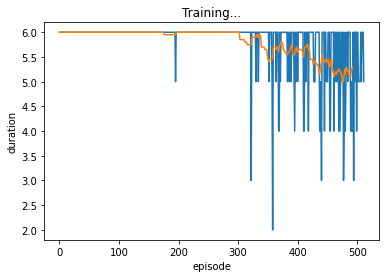

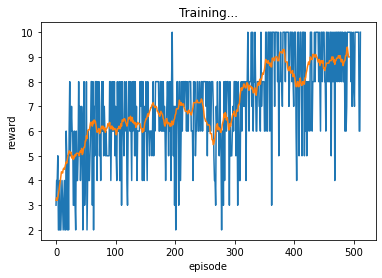

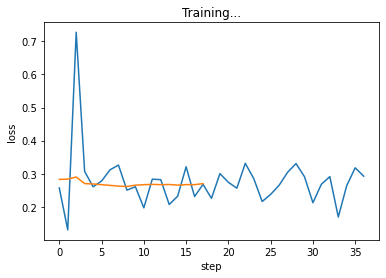

In [132]:
plot_all(*run_experiment(
    model={'name': 'nn'},
    value_function='hybrid',
    eps=[0.9, 0.05, 500],
    gamma=0.4,
    num_episodes=512,
    batch_size=64
    ))

=========================episode 0 habit======================
returning random index 5621
------guess 0 5621 menge [1.         0.8        0.59497161 0.33333333 1.        ]-------
=======menge (habit) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
returning random index 11927
------guess 1 11927 ninth [0.         0.6        0.47672344 0.33333333 0.        ]-------
=======ninth (habit) => [0. 1. 0. 1. 1.]= 0.0 =======
reward 3.0 done False 
returning random index 10646
------guess 2 10646 zowie [0.         0.6        0.46926196 0.         1.        ]-------
=======zowie (habit) => [0. 0. 0. 2. 0.]= 3.0 =======
reward 0 done False 
returning random index 8728
------guess 3 8728 spred [0.         0.8        0.57761557 0.         1.        ]-------
=======spred (habit) => [0. 0. 0. 0. 0.]= 3.0 =======
reward 0 done False 
returning random index 5825
------guess 4 5825 mongs [0.         0.         0.42579075 0.         1.        ]-------
=======mongs (habit) => [0. 0. 0. 0. 0.]= 3.0 ==

reward 0 done False 
returning random index 7876
------guess 5 7876 salps [0.         0.         0.55198702 0.33333333 1.        ]-------
=======salps (reply) => [0. 0. 1. 1. 0.]= 5.0 =======
reward 0 done True 
episode finished.  reward [5.] eps 0.842534746920056
hybrid rewards [array([0.8]), array([1.2]), array([0.]), array([0.]), array([0.]), array([0.])] vs. [array([2.]), array([3.]), array([0]), array([0]), array([0]), array([0])]
=========================episode 6 yield======================
returning random index 1423
------guess 0 1423 cares [1.         1.         0.69051095 0.         1.        ]-------
=======cares (yield) => [0. 0. 0. 1. 0.]= 0 =======
reward 1.0 done False 
returning random index 4376
------guess 1 4376 iroko [0.         0.6        0.53333333 0.33333333 1.        ]-------
=======iroko (yield) => [1. 0. 0. 0. 0.]= 1.0 =======
reward 0 done False 
returning random index 5562
------guess 2 5562 mavie [0.5        0.4        0.54371452 0.         1.        ]----

reward 0 done False 
returning random index 1031
------guess 2 1031 bokos [0.         0.4        0.43276561 0.33333333 1.        ]-------
=======bokos (moody) => [0. 2. 0. 1. 0.]= 2.0 =======
reward 1.0 done False 
returning random index 2165
------guess 3 2165 dedal [0.         0.8        0.60291971 0.33333333 1.        ]-------
=======dedal (moody) => [1. 0. 0. 0. 0.]= 3.0 =======
reward 0 done False 
returning random index 7588
------guess 4 7588 ricks [0.         0.6        0.47461476 0.         1.        ]-------
=======ricks (moody) => [0. 0. 0. 0. 0.]= 3.0 =======
reward 0 done False 
returning random index 4433
------guess 5 4433 jarks [0.         0.2        0.45158151 0.         1.        ]-------
=======jarks (moody) => [0. 0. 0. 0. 0.]= 3.0 =======
reward 0 done True 
episode finished.  reward [3.] eps 0.787478068013027
hybrid rewards [array([0.8]), array([0.]), array([0.4]), array([0.]), array([0.]), array([0.])] vs. [array([2.]), array([0]), array([1.]), array([0]), array(

reward 3.0 done False 
returning random index 9595
------guess 1 9595 tulpa [0.         0.6        0.52895377 0.         1.        ]-------
=======tulpa (parka) => [0. 0. 0. 1. 2.]= 3.0 =======
reward 0 done False 
returning random index 11346
------guess 2 11346 gusto [0.         0.4        0.47526358 0.         0.        ]-------
=======gusto (parka) => [0. 0. 0. 0. 0.]= 3.0 =======
reward 0 done False 
returning random index 6652
------guess 3 6652 pawed [0.33333333 0.4        0.51370641 0.         1.        ]-------
=======pawed (parka) => [2. 2. 0. 0. 0.]= 3.0 =======
reward 1.0 done False 
returning random index 4225
------guess 4 4225 hully [0.         0.4        0.44103812 0.33333333 1.        ]-------
=======hully (parka) => [0. 0. 0. 0. 0.]= 4.0 =======
reward 0 done False 
returning random index 10094
------guess 5 10094 wanze [0.4        0.4        0.49018654 0.         1.        ]-------
=======wanze (parka) => [0. 2. 0. 0. 0.]= 4.0 =======
reward 0 done True 
episode fini

reward 0 done False 
returning random index 7309
------guess 5 7309 rages [0.2        0.2        0.66358475 0.         1.        ]-------
=======rages (swore) => [1. 0. 0. 1. 1.]= 2.0 =======
reward 1.0 done True 
episode finished.  reward [3.] eps 0.6962822639717497
hybrid rewards [array([0.4]), array([0.]), array([0.]), array([0.4]), array([0.]), array([0.4])] vs. [array([1.]), array([0]), array([0]), array([1.]), array([0]), array([1.])]
=========================episode 23 yield======================
returning random index 235
------guess 0 235 alias [1.         0.8        0.65158151 0.33333333 1.        ]-------
=======alias (yield) => [0. 1. 1. 0. 0.]= 0 =======
reward 2.0 done False 
returning random index 12423
------guess 1 12423 ebony [0.         1.         0.53008921 0.         0.        ]-------
=======ebony (yield) => [1. 0. 0. 0. 1.]= 2.0 =======
reward 0 done False 
returning random index 2073
------guess 2 2073 daker [0.         0.6        0.60243309 0.         1.       

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12113 hippo [0.         0.         0.41330089 0.33333333 0.        ]-------
=======hippo (assay) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12113 hippo [0.         0.         0.41330089 0.33333333 0.        ]-------
=======hippo (assay) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12113 hippo [0.         0.         0.41330089 0.33333333 0.        ]-------
=======hippo (assay) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done False 
returning random index 3713
------guess 5 3713 greek [0.6        0.6        0.63033252 0.33333333 1.        ]-------
=======greek (assay) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done True 
episode finished.  reward [2.] eps 0.6513856140405265
hybrid rewards [array([0.4]), array([0.4]), array([0.]), array([0.]), array([0.]), array([

reward 0 done True 
episode finished.  reward [4.] eps 0.6163636423111535
hybrid rewards [array([1.6]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])] vs. [array([4.]), array([0]), array([0]), array([0]), array([0]), array([0])]
=========================episode 34 brand======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 411 arete [1.         0.8        0.82287105 0.33333333 1.        ]-------
=======arete (brand) => [1. 2. 0. 0. 0.]= 0 =======
reward 3.0 done False 
returning random index 10206
------guess 1 10206 whigs [0.         1.         0.36253041 0.         1.        ]-------
=======whigs (brand) => [0. 0. 0. 0. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 6097 neele [0.5        0.4        0.80989457 0.66666667 1.        ]-------
=======neele (brand) => [1. 0. 0. 0. 0.]= 3.0 =======
reward 0 done False 
returning random index 10724
------guess 3 10724 crass [0.33333333 0.2

reward 0 done False 
returning random index 7644
------guess 3 7644 robes [0.33333333 0.4        0.62222222 0.         1.        ]-------
=======robes (eclat) => [0. 0. 0. 1. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 313 anana [0.         0.2        0.66293593 1.         1.        ]-------
=======anana (eclat) => [1. 0. 0. 0. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 2292 dilli [0.         0.6        0.51467964 0.66666667 1.        ]-------
=======dilli (eclat) => [0. 0. 2. 0. 0.]= 3.0 =======
reward 0 done True 
episode finished.  reward [3.] eps 0.577018867434695
hybrid rewards [array([1.2]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])] vs. [array([3.]), array([0]), array([0]), array([0]), array([0]), array([0])]
=========================episode 40 peril======================
returning random index 9590
------guess 0 9590 tuile [1.         1.      

reward 2.0 done False 
returning random index 9509
------guess 1 9509 trefa [0.         0.8        0.66017843 0.         1.        ]-------
=======trefa (faint) => [1. 0. 0. 1. 1.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
=======mamma (faint) => [0. 2. 0. 0. 0.]= 3.0 =======
reward 0 done False 
returning random index 4515
------guess 3 4515 jodel [0.         0.8        0.50705596 0.         1.        ]-------
=======jodel (faint) => [0. 0. 0. 0. 0.]= 3.0 =======
reward 0 done False 
returning random index 3805
------guess 4 3805 gurns [0.25       0.8        0.47380373 0.         1.        ]-------
=======gurns (faint) => [0. 0. 0. 2. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12794 mamma [0.2        0.         0.47137064 1.         0.        ]-------
=======mamma (faint) => [0. 2. 0. 0. 0.]= 3.0 

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
=======mamma (croup) => [0. 0. 0. 0. 0.]= 5.0 =======
reward 0 done True 
episode finished.  reward [5.] eps 0.5118482387133249
hybrid rewards [array([0.]), array([0.]), array([2.]), array([0.]), array([0.]), array([0.])] vs. [array([0]), array([0]), array([5.]), array([0]), array([0]), array([0])]
=========================episode 51 mural======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (mural) => [2. 1. 0. 0. 0.]= 0 =======
reward 3.0 done False 
returning random index 4660
------guess 1 4660 kazoo [0.         0.6        0.44395783 0.33333333 1.        ]-------
=======kazoo (mural) => [0. 1. 0. 0. 0.]= 3.0 =======
reward 0 done False 
returning random index 9156
------guess 2 9156 teads [0.5        0.8  

reward 1.0 done False 
returning random index 3670
------guess 1 3670 goris [0.         1.         0.53592863 0.         1.        ]-------
=======goris (trail) => [0. 0. 1. 2. 0.]= 1.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12794 mamma [0.         0.         0.47137064 1.         0.        ]-------
=======mamma (trail) => [0. 1. 0. 0. 0.]= 3.0 =======
reward 0 done False 
returning random index 1171
------guess 3 1171 breer [0.         0.4        0.73722628 0.66666667 1.        ]-------
=======breer (trail) => [0. 2. 0. 0. 0.]= 3.0 =======
reward 0 done False 
returning random index 5683
------guess 4 5683 micra [0.         0.2        0.54209246 0.         1.        ]-------
=======micra (trail) => [0. 1. 0. 1. 1.]= 3.0 =======
reward 0 done False 
returning random index 12349
------guess 5 12349 scale [0.4        0.2        0.66131387 0.         0.        ]-------
=======scale (trail) => [0. 0. 2. 1. 0.]= 3.0 =======
reward 0 don

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12410 ninny [0.4        0.         0.45758313 0.66666667 0.        ]-------
=======ninny (trope) => [0. 0. 0. 0. 0.]= 2.0 =======
reward 0 done True 
episode finished.  reward [2.] eps 0.45473654508969097
hybrid rewards [array([0.8]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])] vs. [array([2.]), array([0]), array([0]), array([0]), array([0]), array([0])]
=========================episode 62 blurt======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (blurt) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
returning random index 8330
------guess 1 8330 skald [0.         0.8        0.48175182 0.         1.        ]-------
=======skald (blurt) => [0. 0. 0. 1. 0.]= 0.0 =======
reward 1.0 done False 
returning random index 4130
------guess 2 4130 homie [0.         0.8

reward 5.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12908 snore [0.         0.8        0.66991079 0.         0.        ]-------
=======snore (saute) => [2. 0. 0. 0. 2.]= 5.0 =======
reward 0 done False 
returning random index 3822
------guess 2 3822 gwine [0.         0.6        0.48418491 0.         1.        ]-------
=======gwine (saute) => [0. 0. 0. 0. 2.]= 5.0 =======
reward 0 done False 
returning random index 10858
------guess 3 10858 banal [0.         0.4        0.5730738  0.33333333 0.        ]-------
=======banal (saute) => [0. 2. 0. 0. 0.]= 5.0 =======
reward 0 done False 
returning random index 1347
------guess 4 1347 cadre [0.5        0.4        0.64574209 0.         1.        ]-------
=======cadre (saute) => [0. 2. 0. 0. 2.]= 5.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11041 gawky [0.2        0.4        0.34387672 0.         0.        ]-------
=======gawky (saute) => [0. 2. 0. 0. 0.]= 5.0 

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 10878 whack [0.5       0.8       0.3649635 0.        0.       ]-------
=======whack (kappa) => [0. 0. 1. 0. 1.]= 2.0 =======
reward 0 done False 
returning random index 180
------guess 5 180 aioli [0.         0.2        0.61540957 0.33333333 1.        ]-------
=======aioli (kappa) => [1. 0. 0. 0. 0.]= 2.0 =======
reward 0 done True 
episode finished.  reward [2.] eps 0.40468722666888746
hybrid rewards [array([0.8]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])] vs. [array([2.]), array([0]), array([0]), array([0]), array([0]), array([0])]
=========================episode 73 ledge======================
returning random index 12020
------guess 0 12020 clear [1.         1.         0.69862125 0.         0.        ]-------
=======clear (ledge) => [0. 1. 1. 0. 0.]= 0 =======
reward 2.0 done False 
returning random index 9175
------guess 1 9175 teggs [0.         0.6        0.52765612 0.333333

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11057 berth [1.         0.6        0.57274939 0.         0.        ]-------
=======berth (tenth) => [0. 2. 0. 2. 2.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12738 tenth [1.         0.2        0.59286294 0.33333333 0.        ]-------
=======tenth (tenth) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.3826983918851055
hybrid rewards [array([1.198]), array([2.396]), array([0.]), array([3.594]), array([4.792])] vs. [array([1.]), array([2.]), array([0]), array([3.]), array([4.])]
=========================episode 79 cacti======================
returning random index 11749
------guess 0 11749 steel [1.         0.8        0.74339011 0.33333333 0.        ]-------
=======steel (cacti) => [0. 1. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12491 rati

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11358 sorry [1.         0.8        0.59140308 0.33333333 0.        ]-------
=======sorry (fjord) => [0. 1. 0. 2. 0.]= 0.0 =======
reward 3.0 done False 
returning random index 7256
------guess 2 7256 quayd [0.         0.6        0.37193836 0.         1.        ]-------
=======quayd (fjord) => [0. 0. 0. 0. 2.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10763 fjord [1.         0.4        0.37356042 0.         0.        ]-------
=======fjord (fjord) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.3620727549240629
hybrid rewards [array([0.]), array([4.188]), array([0.]), array([9.772])] vs. [array([0]), array([3.]), array([0]), array([7.])]
=========================episode 87 sauna======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12222 elate [1.         0.8        0.79367397

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11038 rusty [1.         0.2        0.51727494 0.         0.        ]-------
=======rusty (rusty) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.3438990524854116
hybrid rewards [array([2.396]), array([0.]), array([4.792]), array([0.]), array([4.792])] vs. [array([2.]), array([0]), array([4.]), array([0]), array([4.])]
=========================episode 93 scorn======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12222 elate [1.         0.8        0.79367397 0.33333333 0.        ]-------
=======elate (scorn) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11358 sorry [1.         0.8        0.59140308 0.33333333 0.        ]-------
=======sorry (scorn) => [2. 1. 0. 2. 0.]= 0.0 =======
reward 5.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------gues

reward 5.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 10770 hatch [1.         0.         0.48061638 0.33333333 0.        ]-------
=======hatch (watch) => [0. 2. 2. 2. 2.]= 8.0 =======
reward 0 done False 
returning random index 2365
------guess 5 2365 doeth [0.         0.4        0.56739659 0.         1.        ]-------
=======doeth (watch) => [0. 0. 0. 1. 2.]= 8.0 =======
reward 0 done True 
episode finished.  reward [8.] eps 0.3256787805886604
hybrid rewards [array([0.8]), array([0.]), array([0.4]), array([2.]), array([0.]), array([0.])] vs. [array([2.]), array([0]), array([1.]), array([5.]), array([0]), array([0])]
=========================episode 100 shift======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12222 elate [1.         0.8        0.79367397 0.33333333 0.        ]-------
=======elate (shift) => [0. 0. 0. 1. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 

reward 2.0 done True 
episode finished.  reward [10.] eps 0.3101442668119301
hybrid rewards [array([4.782]), array([7.97]), array([3.188])] vs. [array([3.]), array([5.]), array([2.])]
=========================episode 107 bugle======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12222 elate [1.         0.8        0.79367397 0.33333333 0.        ]-------
=======elate (bugle) => [0. 1. 0. 0. 2.]= 0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11198 louse [1.         0.6        0.62319546 0.         0.        ]-------
=======louse (bugle) => [1. 0. 1. 0. 2.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11245 guile [1.         0.4        0.55166261 0.         0.        ]-------
=======guile (bugle) => [1. 2. 0. 2. 2.]= 4.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12117 bugle [1.         0.2        0.48840

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10774 ought [1.        0.4       0.4298459 0.        0.       ]-------
=======ought (quoth) => [1. 2. 0. 1. 1.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10846 picky [0.33333333 1.         0.3487429  0.         0.        ]-------
=======picky (quoth) => [0. 0. 0. 0. 0.]= 5.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11815 quoth [1.         0.2        0.38410381 0.         0.        ]-------
=======quoth (quoth) => [2. 2. 2. 2. 2.]= 5.0 =======
reward 5.0 done True 
episode finished.  reward [10.] eps 0.2930425059101108
hybrid rewards [array([0.]), array([3.594]), array([2.396]), array([0.]), array([5.99])] vs. [array([0]), array([3.]), array([2.]), array([0]), array([5.])]
=========================episode 114 spawn======================
returning random index 11795
------guess 0 11795 young [1.  

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12925 intro [1.         0.8        0.58848337 0.         0.        ]-------
=======intro (crypt) => [0. 0. 1. 1. 0.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10680 crust [1.         0.6        0.52570965 0.         0.        ]-------
=======crust (crypt) => [2. 2. 0. 0. 2.]= 2.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11985 crypt [1.         0.4        0.46991079 0.         0.        ]-------
=======crypt (crypt) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.2779750856421607
hybrid rewards [array([1.396]), array([1.396]), array([5.584]), array([5.584])] vs. [array([1.]), array([1.]), array([4.]), array([4.])]
=========================episode 121 easel======================
returning random index 166
------guess 0 166 ahuru [1.         0.8       

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11031 loser [1.         0.8        0.69326845 0.         0.        ]-------
=======loser (unset) => [0. 0. 2. 2. 0.]= 1.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11161 unset [1.         0.6        0.59578264 0.         0.        ]-------
=======unset (unset) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.2646988501986187
hybrid rewards [array([1.594]), array([4.782]), array([9.564])] vs. [array([1.]), array([3.]), array([6.])]
=========================episode 128 augur======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12222 elate [1.         0.8        0.79367397 0.33333333 0.        ]-------
=======elate (augur) => [0. 0. 1. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11316 arson [1.         0.8        0.6287

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11523 scope [1.         0.2        0.56772101 0.         0.        ]-------
=======scope (scope) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.2521957625183766
hybrid rewards [array([2.792]), array([5.584]), array([0.]), array([5.584])] vs. [array([2.]), array([4.]), array([0]), array([4.])]
=========================episode 135 canal======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12222 elate [1.         0.8        0.79367397 0.33333333 0.        ]-------
=======elate (canal) => [0. 1. 1. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10868 solar [1.         0.6        0.65206813 0.         0.        ]-------
=======solar (canal) => [0. 0. 1. 2. 0.]= 2.0 =======
reward 1.0 done False 
returning random index 2962
------guess 2 2962 feebs [0.         0.4        0.591

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11662 spore [1.         0.6        0.63617194 0.         0.        ]-------
=======spore (spine) => [2. 2. 0. 0. 2.]= 3.0 =======
reward 3.0 done False 
returning random index 11998
------guess 3 11998 logic [0.       0.8      0.475588 0.       0.      ]-------
=======logic (spine) => [0. 0. 0. 1. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12508 spine [1.        0.2       0.5701541 0.        0.       ]-------
=======spine (spine) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.23928169392243082
hybrid rewards [array([1.198]), array([2.396]), array([3.594]), array([0.]), array([4.792])] vs. [array([1.]), array([2.]), array([3.]), array([0]), array([4.])]
=========================episode 141 rivet======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mamma [1.      

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11372 freer [1.         0.4        0.72895377 0.66666667 0.        ]-------
=======freer (fewer) => [2. 0. 1. 2. 2.]= 1.0 =======
reward 6.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12526 fever [1.         0.2        0.60794809 0.33333333 0.        ]-------
=======fever (fewer) => [2. 2. 0. 2. 2.]= 7.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 10949 fewer [1.         0.2        0.61476075 0.33333333 0.        ]-------
=======fewer (fewer) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.2275471752188854
hybrid rewards [array([0.]), array([1.198]), array([7.188]), array([1.198]), array([2.396])] vs. [array([0]), array([1.]), array([6.]), array([1.]), array([2.])]
=========================episode 147 foamy======================
states shape (12972, 3) actions shape (12972, 5)

reward 2.0 done False 
returning random index 8667
------guess 5 8667 spars [0.         0.4        0.5811841  0.33333333 1.        ]-------
=======spars (taffy) => [0. 0. 1. 0. 0.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.2172076326592145
hybrid rewards [array([0.8]), array([0.8]), array([0.]), array([0.]), array([0.8]), array([0.])] vs. [array([2.]), array([2.]), array([0]), array([0]), array([2.]), array([0])]
=========================episode 152 whelp======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (whelp) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (whelp) => [1. 0. 0. 0. 0.]= 0.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12212 cocoa [1.         0.4        0.55815085 0.66666667 0.        ]-------
=======cocoa (ultra) => [0. 0. 0. 0. 2.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12439 terra [1.         0.6        0.76869424 0.33333333 0.        ]-------
=======terra (ultra) => [1. 0. 0. 2. 2.]= 2.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12794 mamma [0.33333333 0.         0.47137064 1.         0.        ]-------
=======mamma (ultra) => [0. 0. 0. 0. 2.]= 5.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11894 pizza [0.75       0.6        0.34014599 0.33333333 0.        ]-------
=======pizza (ultra) => [0. 0. 0. 0. 2.]= 5.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12794 mamma [0.4        0.         0.47137064 1.        

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11295 nanny [0.4        0.4        0.50754258 0.66666667 0.        ]-------
=======nanny (leash) => [0. 1. 0. 0. 0.]= 8.0 =======
reward 0 done True 
episode finished.  reward [8.] eps 0.1968242582530999
hybrid rewards [array([0.4]), array([0.]), array([1.6]), array([1.2]), array([0.]), array([0.])] vs. [array([1.]), array([0]), array([4.]), array([3.]), array([0]), array([0])]
=========================episode 164 scion======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (scion) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
returning random index 2200
------guess 1 2200 delos [1.         1.         0.61119221 0.         1.        ]-------
=======delos (scion) => [0. 0. 0. 2. 1.]= 0.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 1

reward 0 done False 
returning random index 8635
------guess 5 8635 sowle [0.         0.4        0.57907543 0.         1.        ]-------
=======sowle (ratio) => [0. 1. 0. 0. 0.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.18799760769788387
hybrid rewards [array([0.8]), array([0.8]), array([0.]), array([0.8]), array([0.]), array([0.])] vs. [array([2.]), array([2.]), array([0]), array([2.]), array([0]), array([0])]
=========================episode 170 intro======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (intro) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (intro) => [0. 0. 1. 1. 0.]= 0.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11451 ozone [1.         0.4        0.54436334 0.33333333 0.        ]-------
=======ozone (shove) => [0. 0. 2. 0. 2.]= 4.0 =======
reward 0 done False 
returning random index 10005
------guess 4 10005 volta [0.         0.6        0.54079481 0.         1.        ]-------
=======volta (shove) => [1. 1. 0. 0. 0.]= 4.0 =======
reward 0 done False 
returning random index 12174
------guess 5 12174 idiom [0.         0.2        0.45498783 0.33333333 0.        ]-------
=======idiom (shove) => [0. 0. 0. 1. 0.]= 4.0 =======
reward 0 done True 
episode finished.  reward [4.] eps 0.17892571032034754
hybrid rewards [array([0.8]), array([0.8]), array([0.]), array([0.]), array([0.]), array([0.])] vs. [array([2.]), array([2.]), array([0]), array([0]), array([0]), array([0])]
=========================episode 176 cream======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mamma [1.     

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12215 shush [1.         0.4        0.4189781  0.66666667 0.        ]-------
=======shush (shoot) => [2. 2. 0. 0. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12006 shoot [1.         0.4        0.53446878 0.33333333 0.        ]-------
=======shoot (shoot) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.17141766144686005
hybrid rewards [array([0.]), array([1.198]), array([1.198]), array([2.396]), array([7.188])] vs. [array([0]), array([1.]), array([1.]), array([2.]), array([6.])]
=========================episode 182 setup======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (setup) => [0. 2. 0. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)


reward 8.0 done True 
episode finished.  reward [10.] eps 0.16457576984222846
hybrid rewards [array([2.792]), array([0.]), array([0.]), array([11.168])] vs. [array([2.]), array([0]), array([0]), array([8.])]
=========================episode 189 sappy======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (sappy) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (sappy) => [0. 2. 0. 0. 0.]= 0.0 =======
reward 2.0 done False 
returning random index 3842
------guess 2 3842 gyrus [0.         0.8        0.44947283 0.         1.        ]-------
=======gyrus (sappy) => [0. 1. 0. 0. 1.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11735 sassy [1.         0.         0.5532846

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12398 sense [1.         0.4        0.71030008 0.66666667 0.        ]-------
=======sense (fence) => [0. 2. 2. 0. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11818 penne [1.         0.2        0.6460665  0.66666667 0.        ]-------
=======penne (fence) => [0. 2. 2. 0. 2.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11802 venue [1.         0.4        0.59383617 0.33333333 0.        ]-------
=======venue (fence) => [0. 2. 2. 0. 2.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12545 fence [1.         0.4        0.60794809 0.33333333 0.        ]-------
=======fence (fence) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.15682973971186015
hybrid rewards [array([4.792]), array([2.396]), array([0.]), a

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11432 poppy [1.         0.2        0.36982968 0.66666667 0.        ]-------
=======poppy (folly) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12512 dodgy [1.         0.4        0.36918086 0.33333333 0.        ]-------
=======dodgy (folly) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done True 
episode finished.  reward [4.] eps 0.1506084599926667
hybrid rewards [array([0.]), array([0.]), array([0.]), array([1.6]), array([0.]), array([0.])] vs. [array([0]), array([0]), array([0]), array([4.]), array([0]), array([0])]
=========================episode 202 drape======================
returning random index 4755
------guess 0 4755 kikoi [1.         0.6        0.4081103  0.66666667 1.        ]-------
=======kikoi (drape) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12794

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12794 mamma [0.2        0.         0.47137064 1.         0.        ]-------
=======mamma (maize) => [2. 2. 0. 0. 0.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.1447494793996233
hybrid rewards [array([1.2]), array([0.]), array([0.]), array([1.2]), array([0.]), array([0.])] vs. [array([3.]), array([0]), array([0]), array([3.]), array([0]), array([0])]
=========================episode 208 ghost======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (ghost) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (ghost) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 

reward 6.0 done True 
episode finished.  reward [10.] eps 0.1392316992741366
hybrid rewards [array([6.376]), array([0.]), array([9.564])] vs. [array([4.]), array([0]), array([6.])]
=========================episode 215 eaten======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (eaten) => [2. 1. 0. 0. 0.]= 0 =======
reward 3.0 done False 
returning random index 11039
------guess 1 11039 retro [0.         0.4        0.73219789 0.33333333 0.        ]-------
=======retro (eaten) => [0. 1. 2. 0. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11466 eaten [1.         0.4        0.7703163  0.33333333 0.        ]-------
=======eaten (eaten) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.1386979120415503
hybrid rewards [array([4.782]), array([0.]), array([11.158])] vs. [array([3.

reward 7.0 done True 
episode finished.  reward [10.] eps 0.1340352496478372
hybrid rewards [array([5.376]), array([12.544])] vs. [array([3.]), array([7.])]
=========================episode 222 floor======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (floor) => [0. 0. 1. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11853 radar [1.         0.4        0.6729927  0.66666667 0.        ]-------
=======radar (floor) => [0. 0. 0. 0. 2.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12443 color [1.         0.6        0.58442822 0.33333333 0.        ]-------
=======color (floor) => [0. 1. 1. 2. 2.]= 2.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11162 floor [1.         0.2        0.54436334 0.33333333 0.        ]-

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12652 thigh [1.         0.4        0.40373074 0.33333333 0.        ]-------
=======thigh (thigh) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.12882548430648424
hybrid rewards [array([1.]), array([1.]), array([0.]), array([2.]), array([0.]), array([6.])] vs. [array([1.]), array([1.]), array([0]), array([2.]), array([0]), array([6.])]
=========================episode 228 fussy======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (fussy) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (fussy) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (129

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11348 vapor [1.         0.2        0.51127332 0.         0.        ]-------
=======vapor (vapor) => [2. 2. 2. 2. 2.]= 7.0 =======
reward 3.0 done True 
episode finished.  reward [10.] eps 0.1240867237426841
hybrid rewards [array([1.198]), array([3.594]), array([2.396]), array([1.198]), array([3.594])] vs. [array([1.]), array([3.]), array([2.]), array([1.]), array([3.])]
=========================episode 234 valet======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (valet) => [1. 0. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12824 latte [1.         0.6        0.71192214 0.33333333 0.        ]-------
=======latte (valet) => [1. 2. 1. 0. 1.]= 1.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11672 arena [1.         0.4        0.756691   0.33333333 0.        ]-------
=======arena (sower) => [0. 1. 1. 0. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11039 retro [1.         0.4        0.73219789 0.33333333 0.        ]-------
=======retro (sower) => [1. 1. 0. 0. 1.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11804 offer [1.         0.2        0.54274128 0.33333333 0.        ]-------
=======offer (sower) => [1. 0. 0. 2. 2.]= 3.0 =======
reward 2.0 done False 
returning random index 7327
------guess 4 7327 rajas [0.         0.4        0.57631792 0.33333333 1.        ]-------
=======rajas (sower) => [1. 0. 0. 0. 1.]= 5.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 10735 wooer [0.8        0.2        0.62206002 0.33333333 0.        ]-------


reward 6.0 done True 
episode finished.  reward [10.] eps 0.11557774264854169
hybrid rewards [array([2.792]), array([0.]), array([2.792]), array([8.376])] vs. [array([2.]), array([0]), array([2.]), array([6.])]
=========================episode 246 haven======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (haven) => [1. 0. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12824 latte [1.         0.6        0.71192214 0.33333333 0.        ]-------
=======latte (haven) => [0. 2. 0. 0. 1.]= 1.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12062 waxen [1.         0.6        0.48969992 0.         0.        ]-------
=======waxen (haven) => [0. 2. 0. 2. 2.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11621 haven [1.

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10759 agate [1.         0.6        0.68629359 0.33333333 0.        ]-------
=======agate (avail) => [2. 0. 2. 0. 0.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11889 avail [1.         0.6        0.56788321 0.33333333 0.        ]-------
=======avail (avail) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.11151225046227164
hybrid rewards [array([2.792]), array([1.396]), array([1.396]), array([8.376])] vs. [array([2.]), array([1.]), array([1.]), array([6.])]
=========================episode 253 waist======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (waist) => [0. 2. 0. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12514 rarer

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12212 cocoa [1.         0.4        0.55815085 0.66666667 0.        ]-------
=======cocoa (toast) => [0. 2. 0. 0. 1.]= 1.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11230 total [1.         0.4        0.63422547 0.33333333 0.        ]-------
=======total (toast) => [2. 2. 1. 1. 0.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12076 toast [1.         0.2        0.62611517 0.33333333 0.        ]-------
=======toast (toast) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.10769879846599723
hybrid rewards [array([1.396]), array([2.792]), array([4.188]), array([5.584])] vs. [array([1.]), array([2.]), array([3.]), array([4.])]
=========================episode 259 pooch======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mam

reward 4.0 done True 
episode finished.  reward [10.] eps 0.10455647204345314
hybrid rewards [array([0.]), array([5.584]), array([2.792]), array([5.584])] vs. [array([0]), array([4.]), array([2.]), array([4.])]
=========================episode 265 irate======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (irate) => [0. 1. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12212 cocoa [1.         0.4        0.55815085 0.66666667 0.        ]-------
=======cocoa (irate) => [0. 0. 0. 0. 1.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12179 erase [1.         0.6        0.81313869 0.33333333 0.        ]-------
=======erase (irate) => [0. 2. 2. 0. 2.]= 1.0 =======
reward 5.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12452 titan [0.66

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (pouty) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11842 tooth [1.         0.6        0.54420114 0.66666667 0.        ]-------
=======tooth (pouty) => [0. 2. 0. 2. 0.]= 0.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12695 slyly [0.66666667 0.6        0.47964315 0.66666667 0.        ]-------
=======slyly (pouty) => [0. 0. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11866 puppy [0.75       0.4        0.32327656 0.66666667 0.        ]-------
=======puppy (pouty) => [2. 1. 0. 0. 2.]= 4.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 10711 booby [0.6        0.2        0.40470397 0.66666667

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12614 erect [1.         0.2        0.74144363 0.33333333 0.        ]-------
=======erect (erect) => [2. 2. 2. 2. 2.]= 5.0 =======
reward 5.0 done True 
episode finished.  reward [10.] eps 0.09800169628164253
hybrid rewards [array([0.]), array([4.792]), array([1.198]), array([0.]), array([5.99])] vs. [array([0]), array([4.]), array([1.]), array([0]), array([5.])]
=========================episode 278 ledge======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (ledge) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (ledge) => [0. 2. 0. 0. 2.]= 0.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------gue

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12674 tract [1.         0.4        0.61849148 0.33333333 0.        ]-------
=======tract (snack) => [0. 0. 2. 2. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12275 knack [1.         0.4        0.39756691 0.33333333 0.        ]-------
=======knack (snack) => [0. 2. 2. 2. 2.]= 4.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12540 snack [1.         0.2        0.47201946 0.         0.        ]-------
=======snack (snack) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.09493586942759782
hybrid rewards [array([1.]), array([1.]), array([2.]), array([0.]), array([4.]), array([2.])] vs. [array([1.]), array([1.]), array([2.]), array([0]), array([4.]), array([2.])]
=========================episode 284 uncle======================
states shape (12972, 3) actions sha

reward 5.0 done True 
episode finished.  reward [10.] eps 0.09248862314905451
hybrid rewards [array([0.]), array([5.584]), array([1.396]), array([6.98])] vs. [array([0]), array([4.]), array([1.]), array([5.])]
=========================episode 290 feign======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (feign) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (feign) => [0. 2. 0. 1. 0.]= 0.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 10974 heist [1.         0.6        0.59870235 0.         0.        ]-------
=======heist (feign) => [0. 2. 2. 0. 0.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11996 deign [1.   

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12212 cocoa [1.         0.4        0.55815085 0.66666667 0.        ]-------
=======cocoa (eclat) => [1. 0. 0. 0. 1.]= 1.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12956 peace [1.         0.4        0.69570154 0.33333333 0.        ]-------
=======peace (eclat) => [0. 1. 1. 1. 0.]= 2.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11129 eclat [1.         0.4        0.67104623 0.         0.        ]-------
=======eclat (eclat) => [2. 2. 2. 2. 2.]= 3.0 =======
reward 7.0 done True 
episode finished.  reward [10.] eps 0.08969544118487942
hybrid rewards [array([1.396]), array([1.396]), array([1.396]), array([9.772])] vs. [array([1.]), array([1.]), array([1.]), array([7.])]
=========================episode 297 devil======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mam

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12658 etude [1.         0.4        0.65774534 0.33333333 0.        ]-------
=======etude (etude) => [2. 2. 2. 2. 2.]= 5.0 =======
reward 5.0 done True 
episode finished.  reward [10.] eps 0.087458600987592
hybrid rewards [array([0.]), array([4.792]), array([0.]), array([1.198]), array([5.99])] vs. [array([0]), array([4.]), array([0]), array([1.]), array([5.])]
=========================episode 304 wafer======================
returning random index 12619
------guess 0 12619 skier [1.        1.        0.5972425 0.        0.       ]-------
=======skier (wafer) => [0. 0. 0. 2. 2.]= 0 =======
reward 4.0 done False 
returning random index 12136
------guess 1 12136 whale [0.        0.8       0.5701541 0.        0.       ]-------
=======whale (wafer) => [2. 0. 1. 0. 1.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11372 freer [0.5        0.2        0.72895377

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12970 rural [1.         0.4        0.64282238 0.33333333 0.        ]-------
=======rural (angry) => [1. 0. 0. 1. 0.]= 2.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11067 angry [1.         0.6        0.51727494 0.         0.        ]-------
=======angry (angry) => [2. 2. 2. 2. 2.]= 2.0 =======
reward 8.0 done True 
episode finished.  reward [10.] eps 0.08513635500178801
hybrid rewards [array([1.198]), array([0.]), array([1.198]), array([0.]), array([9.584])] vs. [array([1.]), array([0]), array([1.]), array([0]), array([8.])]
=========================episode 310 stack======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (stack) => [0. 1. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11663 hoist [1.         0.4        0.52100568 0.         0.        ]-------
=======hoist (foist) => [0. 2. 2. 2. 2.]= 5.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12328 foist [1.         0.2        0.49521492 0.         0.        ]-------
=======foist (foist) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.08302405877039704
hybrid rewards [array([0.]), array([1.]), array([2.]), array([2.]), array([3.]), array([2.])] vs. [array([0]), array([1.]), array([2.]), array([2.]), array([3.]), array([2.])]
=========================episode 316 stick======================
returning random index 2937
------guess 0 2937 faver [1.         1.         0.56674777 0.         1.        ]-------
=======faver (stick) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------gues

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11593 drawl [1.         0.6        0.51662612 0.         0.        ]-------
=======drawl (gravy) => [0. 2. 2. 0. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11840 prank [1.         0.6        0.49148418 0.         0.        ]-------
=======prank (gravy) => [0. 2. 2. 0. 0.]= 4.0 =======
reward 0 done True 
episode finished.  reward [4.] eps 0.08103874769067934
hybrid rewards [array([0.4]), array([0.]), array([1.2]), array([0.]), array([0.]), array([0.])] vs. [array([1.]), array([0]), array([3.]), array([0]), array([0]), array([0])]
loss 0.18597111105918884
=========================episode 322 breed======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (breed) => [1. 1. 1. 0. 0.]= 0 =======
reward 3.0 done False 
states shape (1297

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11393 cress [1.         0.2        0.64022709 0.33333333 0.        ]-------
=======cress (cress) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.07928971262681361
hybrid rewards [array([2.396]), array([2.396]), array([4.792]), array([0.]), array([2.396])] vs. [array([2.]), array([2.]), array([4.]), array([0]), array([2.])]
=========================episode 330 frail======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (frail) => [0. 0. 1. 2. 0.]= 0 =======
reward 3.0 done False 
returning random index 11245
------guess 1 11245 guile [0.         0.6        0.55166261 0.         0.        ]-------
=======guile (frail) => [0. 0. 1. 1. 0.]= 3.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12602 trai

reward 4.0 done True 
episode finished.  reward [10.] eps 0.07758401255080781
hybrid rewards [array([2.792]), array([0.]), array([5.584]), array([5.584])] vs. [array([2.]), array([0]), array([4.]), array([4.])]
=========================episode 336 stein======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (stein) => [1. 0. 0. 2. 0.]= 0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11814 pixie [1.         0.4        0.48321168 0.33333333 0.        ]-------
=======pixie (stein) => [0. 0. 0. 2. 1.]= 3.0 =======
reward 0 done False 
returning random index 5126
------guess 2 5126 levis [1.         0.6        0.55879968 0.         1.        ]-------
=======levis (stein) => [0. 1. 0. 2. 1.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11769 sheik [1.         0.4        0.51

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12954 riser [1.         0.2        0.70900243 0.33333333 0.        ]-------
=======riser (ripen) => [2. 2. 0. 2. 0.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11237 rivet [1.         0.4        0.59772912 0.         0.        ]-------
=======rivet (ripen) => [2. 2. 0. 2. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12909 ripen [1.         0.4        0.60746148 0.         0.        ]-------
=======ripen (ripen) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.0757191628305813
hybrid rewards [array([4.188]), array([4.188]), array([0.]), array([5.584])] vs. [array([3.]), array([3.]), array([0]), array([4.])]
=========================episode 343 moral======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1. 

reward 2.0 done False 
returning random index 7292
------guess 1 7292 rabic [0.         0.6        0.53641525 0.         1.        ]-------
=======rabic (habit) => [0. 2. 2. 2. 0.]= 2.0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12389 habit [1.        0.4       0.4945661 0.        0.       ]-------
=======habit (habit) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.07422139538731976
hybrid rewards [array([3.188]), array([6.376]), array([6.376])] vs. [array([2.]), array([4.]), array([4.])]
=========================episode 350 elder======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (elder) => [2. 1. 1. 0. 0.]= 0 =======
reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11394 eater [1.         0.4        0.82287105 0.33333333 0.        

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12646 noise [1.         0.4        0.63292782 0.         0.        ]-------
=======noise (noise) => [2. 2. 2. 2. 2.]= 5.0 =======
reward 5.0 done True 
episode finished.  reward [10.] eps 0.07281085112969886
hybrid rewards [array([3.594]), array([0.]), array([1.198]), array([1.198]), array([5.99])] vs. [array([3.]), array([0]), array([1.]), array([1.]), array([5.])]
=========================episode 357 facet======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (facet) => [1. 0. 0. 0. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12824 latte [1.         0.6        0.71192214 0.33333333 0.        ]-------
=======latte (facet) => [0. 2. 1. 0. 1.]= 1.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
-

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11557 joker [1.         0.4        0.50656934 0.         0.        ]-------
=======joker (foyer) => [0. 2. 0. 2. 2.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11885 boxer [1.         0.4        0.51970803 0.         0.        ]-------
=======boxer (foyer) => [0. 2. 0. 2. 2.]= 6.0 =======
reward 0 done True 
episode finished.  reward [6.] eps 0.07139669240320871
hybrid rewards [array([0.8]), array([0.]), array([0.4]), array([1.2]), array([0.]), array([0.])] vs. [array([2.]), array([0]), array([1.]), array([3.]), array([0]), array([0])]
=========================episode 363 sonic======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (sonic) => [0. 0. 0. 2. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11007 tiara [1.         0.4        0.69051095 0.33333333 0.        ]-------
=======tiara (right) => [1. 2. 0. 1. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12683 right [1.        0.4       0.4864558 0.        0.       ]-------
=======right (right) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.0701506460413535
hybrid rewards [array([3.188]), array([3.188]), array([9.564])] vs. [array([2.]), array([2.]), array([6.])]
=========================episode 370 lorry======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (lorry) => [0. 0. 2. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11777 array [1.         0.4        0.67818329 

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12490 think [1.         0.4        0.41751825 0.         0.        ]-------
=======think (think) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.06897716377055656
hybrid rewards [array([1.396]), array([2.792]), array([4.188]), array([5.584])] vs. [array([1.]), array([2.]), array([3.]), array([4.])]
=========================episode 376 slush======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (slush) => [0. 0. 0. 0. 0.]= 0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (slush) => [0. 0. 0. 0. 0.]= 0.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11842 tooth [1.

reward 6.0 done True 
episode finished.  reward [10.] eps 0.0678720197871301
hybrid rewards [array([2.792]), array([2.792]), array([0.]), array([8.376])] vs. [array([2.]), array([2.]), array([0]), array([6.])]
=========================episode 382 tunic======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (tunic) => [0. 0. 0. 2. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 10905 tacit [1.         0.6        0.58150852 0.33333333 0.        ]-------
=======tacit (tunic) => [2. 0. 1. 2. 0.]= 2.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12630 tonic [1.         0.4        0.52003244 0.         0.        ]-------
=======tonic (tunic) => [2. 0. 2. 2. 2.]= 5.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11388 tunic [1. 

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12514 rarer [1.         0.2        0.79626926 0.66666667 0.        ]-------
=======rarer (surer) => [0. 0. 2. 2. 2.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12600 purer [1.         0.4        0.6269262  0.33333333 0.        ]-------
=======purer (surer) => [0. 2. 2. 2. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10811 surer [1.         0.2        0.67591241 0.33333333 0.        ]-------
=======surer (surer) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.0666971216701055
hybrid rewards [array([4.188]), array([4.188]), array([2.792]), array([2.792])] vs. [array([3.]), array([3.]), array([2.]), array([2.])]
=========================episode 390 skiff======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eeri

reward 6.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11474 verve [1.         0.2        0.59545823 0.66666667 0.        ]-------
=======verve (merge) => [0. 2. 2. 0. 2.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12042 merge [1.         0.4        0.64752636 0.33333333 0.        ]-------
=======merge (merge) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.06572475700184635
hybrid rewards [array([9.564]), array([0.]), array([6.376])] vs. [array([6.]), array([0]), array([4.])]
=========================episode 398 octet======================
returning random index 7847
------guess 0 7847 saics [1.         0.8        0.5620438  0.33333333 1.        ]-------
=======saics (octet) => [0. 0. 0. 1. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11776 emcee [1.         0.4        0.72862936 0.66666667 0.        ]

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12760 tepee [1.         0.4        0.77777778 0.66666667 0.        ]-------
=======tepee (gusto) => [1. 0. 0. 0. 0.]= 1.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12187 sooty [1.         0.6        0.54030819 0.33333333 0.        ]-------
=======sooty (gusto) => [1. 1. 0. 2. 0.]= 1.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11346 gusto [1.         0.4        0.47526358 0.         0.        ]-------
=======gusto (gusto) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.06474990068413773
hybrid rewards [array([1.396]), array([0.]), array([4.188]), array([8.376])] vs. [array([1.]), array([0]), array([3.]), array([6.])]
=========================episode 405 pause======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11317 onion [1.         0.4        0.53998378 0.66666667 0.        ]-------
=======onion (joist) => [1. 0. 2. 0. 0.]= 1.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11328 idiot [1.         0.4        0.52197891 0.33333333 0.        ]-------
=======idiot (joist) => [0. 0. 2. 1. 2.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11663 hoist [1.         0.4        0.52100568 0.         0.        ]-------
=======hoist (joist) => [0. 2. 2. 2. 2.]= 5.0 =======
reward 3.0 done False 
returning random index 11894
------guess 4 11894 pizza [0.25       0.6        0.34014599 0.33333333 0.        ]-------
=======pizza (joist) => [0. 1. 0. 0. 0.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 11868 joist [1.        0.2       0.4622871 0.        0.       ]-------
=

reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11017 gloom [1.         0.6        0.46293593 0.33333333 0.        ]-------
=======gloom (smock) => [0. 0. 2. 0. 1.]= 1.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11077 stomp [1.         0.6        0.45985401 0.         0.        ]-------
=======stomp (smock) => [2. 0. 2. 1. 0.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12203 smoky [1.         0.4        0.38507705 0.         0.        ]-------
=======smoky (smock) => [2. 2. 2. 1. 0.]= 5.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 12040 smock [1.         0.2        0.39351176 0.         0.        ]-------
=======smock (smock) => [2. 2. 2. 2. 2.]= 7.0 =======
reward 3.0 done True 
episode finished.  reward [10.] eps 0.0630037314317167
hybrid rewards [array([0.]), array([1.]), array([2.]), arra

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10709 unmet [1.         0.4        0.53852393 0.         0.        ]-------
=======unmet (unmet) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.06232015266273499
hybrid rewards [array([1.396]), array([1.396]), array([5.584]), array([5.584])] vs. [array([1.]), array([1.]), array([4.]), array([4.])]
=========================episode 425 tripe======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (tripe) => [0. 0. 1. 1. 2.]= 0 =======
reward 4.0 done False 
returning random index 12669
------guess 1 12669 salvo [0.         1.         0.53106245 0.         0.        ]-------
=======salvo (tripe) => [0. 0. 0. 0. 0.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11069 trite [1.         0.2      

reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12514 rarer [1.         0.2        0.79626926 0.66666667 0.        ]-------
=======rarer (purer) => [0. 0. 2. 2. 2.]= 3.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12600 purer [1.         0.4        0.6269262  0.33333333 0.        ]-------
=======purer (purer) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.061556364792627244
hybrid rewards [array([4.782]), array([4.782]), array([6.376])] vs. [array([3.]), array([3.]), array([4.])]
=========================episode 432 drove======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (drove) => [0. 0. 1. 0. 2.]= 0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11855 aware [1.         0.4        0.69

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12398 sense [1.         0.4        0.71030008 0.66666667 0.        ]-------
=======sense (belle) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12197 femme [1.         0.4        0.53982157 0.66666667 0.        ]-------
=======femme (belle) => [0. 2. 0. 0. 2.]= 4.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12668 belle [1.         0.4        0.67883212 0.66666667 0.        ]-------
=======belle (belle) => [2. 2. 2. 2. 2.]= 4.0 =======
reward 6.0 done True 
episode finished.  reward [10.] eps 0.06081826976139138
hybrid rewards [array([5.584]), array([0.]), array([0.]), array([8.376])] vs. [array([4.]), array([0]), array([0]), array([6.])]
=========================episode 439 bicep======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.      

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12824 latte [1.         0.6        0.71192214 0.33333333 0.        ]-------
=======latte (alike) => [1. 1. 0. 0. 2.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11704 algae [1.         0.2        0.68467153 0.33333333 0.        ]-------
=======algae (alike) => [2. 2. 0. 0. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11549 alive [1.         0.4        0.60908354 0.         0.        ]-------
=======alive (alike) => [2. 2. 2. 0. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11135 alike [1.         0.2        0.61832928 0.         0.        ]-------
=======alike (alike) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.060147591122457225
hybrid rewards [array([2.396]), array([2.396]), array([2.

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11114 prize [1.         0.4        0.52068127 0.         0.        ]-------
=======prize (pride) => [2. 2. 2. 0. 2.]= 6.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11611 prime [1.         0.2        0.56545012 0.         0.        ]-------
=======prime (pride) => [2. 2. 2. 0. 2.]= 8.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 10687 pride [1.         0.2        0.57793998 0.         0.        ]-------
=======pride (pride) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.05955664142044459
hybrid rewards [array([4.]), array([2.]), array([0.]), array([2.]), array([0.]), array([2.])] vs. [array([4.]), array([2.]), array([0]), array([2.]), array([0]), array([2.])]
=========================episode 452 ghost======================
states shape (12972, 3) actions shape 

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 10863 drink [1.         0.2        0.44574209 0.         0.        ]-------
=======drink (drink) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.05901812417407487
hybrid rewards [array([2.]), array([0.]), array([2.]), array([2.]), array([2.]), array([2.])] vs. [array([2.]), array([0]), array([2.]), array([2.]), array([2.]), array([2.])]
=========================episode 458 clear======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (clear) => [1. 0. 1. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11672 arena [1.         0.4        0.756691   0.33333333 0.        ]-------
=======arena (clear) => [1. 1. 2. 0. 0.]= 2.0 =======
reward 2.0 done False 
states shape (12972, 3) actions sha

reward 0 done True 
episode finished.  reward [4.] eps 0.058492949506602464
hybrid rewards [array([0.]), array([0.8]), array([0.8]), array([0.]), array([0.]), array([0.])] vs. [array([0]), array([2.]), array([2.]), array([0]), array([0]), array([0])]
=========================episode 464 smile======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (smile) => [0. 0. 0. 1. 2.]= 0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11495 title [1.         0.4        0.66196269 0.33333333 0.        ]-------
=======title (smile) => [0. 1. 0. 2. 2.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 11904 agile [1.         0.4        0.63471208 0.         0.        ]-------
=======agile (smile) => [0. 0. 2. 2. 2.]= 5.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape 

reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12794 mamma [1.         0.4        0.47137064 1.         0.        ]-------
=======mamma (human) => [0. 1. 2. 0. 0.]= 0.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12111 nomad [1.         0.6        0.48937551 0.         0.        ]-------
=======nomad (human) => [1. 0. 2. 2. 0.]= 3.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11252 human [1.         0.4        0.44217356 0.         0.        ]-------
=======human (human) => [2. 2. 2. 2. 2.]= 5.0 =======
reward 5.0 done True 
episode finished.  reward [10.] eps 0.05793462702810577
hybrid rewards [array([0.]), array([4.188]), array([2.792]), array([6.98])] vs. [array([0]), array([3.]), array([2.]), array([5.])]
=========================episode 471 sully======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1. 

reward 5.0 done False 
returning random index 6181
------guess 4 6181 nirly [0.         0.4        0.53349554 0.         1.        ]-------
=======nirly (staff) => [0. 0. 0. 0. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 5 10691 staff [1.         0.2        0.46017843 0.33333333 0.        ]-------
=======staff (staff) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.05747255032228901
hybrid rewards [array([0.]), array([1.]), array([0.]), array([5.]), array([0.]), array([4.])] vs. [array([0]), array([1.]), array([0]), array([5.]), array([0]), array([4.])]
=========================episode 477 apron======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (apron) => [0. 0. 2. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 

reward 4.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 11154 dandy [1.         0.2        0.44849959 0.33333333 0.        ]-------
=======dandy (dandy) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.057051471718846856
hybrid rewards [array([0.]), array([2.396]), array([2.396]), array([4.792]), array([2.396])] vs. [array([0]), array([2.]), array([2.]), array([4.]), array([2.])]
=========================episode 484 radio======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (radio) => [0. 0. 1. 2. 0.]= 0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11019 trait [1.         0.4        0.64995945 0.33333333 0.        ]-------
=======trait (radio) => [0. 1. 1. 2. 0.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)

reward 5.0 done True 
episode finished.  reward [10.] eps 0.05665412091684191
hybrid rewards [array([5.584]), array([1.396]), array([0.]), array([6.98])] vs. [array([4.]), array([1.]), array([0]), array([5.])]
=========================episode 491 shiny======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (shiny) => [0. 0. 0. 1. 0.]= 0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11317 onion [1.         0.4        0.53998378 0.66666667 0.        ]-------
=======onion (shiny) => [0. 1. 2. 0. 0.]= 1.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12698 taint [1.         0.4        0.5974047  0.33333333 0.        ]-------
=======taint (shiny) => [0. 0. 2. 2. 0.]= 3.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 11424 icing [1. 

reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 10790 gouge [1.         0.4        0.49894566 0.33333333 0.        ]-------
=======gouge (vogue) => [1. 2. 1. 0. 2.]= 4.0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 4 12415 vogue [1.         0.2        0.47331711 0.         0.        ]-------
=======vogue (vogue) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.056241598687479716
hybrid rewards [array([2.396]), array([0.]), array([2.396]), array([2.396]), array([4.792])] vs. [array([2.]), array([0]), array([2.]), array([2.]), array([4.])]
=========================episode 498 penal======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.         0.6        0.85466342 0.66666667 0.        ]-------
=======eerie (penal) => [0. 2. 0. 0. 0.]= 0 =======
reward 2.0 done False 
states shape (12972, 3) actions shape (12972, 5)

reward 5.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 12223 resin [1.         0.4        0.65644769 0.         0.        ]-------
=======resin (relic) => [2. 2. 0. 2. 0.]= 5.0 =======
reward 1.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12964 refit [1.         0.4        0.61021898 0.         0.        ]-------
=======refit (relic) => [2. 2. 0. 2. 0.]= 6.0 =======
reward 0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 3 12865 relic [1.        0.4       0.6486618 0.        0.       ]-------
=======relic (relic) => [2. 2. 2. 2. 2.]= 6.0 =======
reward 4.0 done True 
episode finished.  reward [10.] eps 0.05585465077392041
hybrid rewards [array([6.98]), array([1.396]), array([0.]), array([5.584])] vs. [array([5.]), array([1.]), array([0]), array([4.])]
=========================episode 505 prime======================
states shape (12972, 3) actions shape (12972, 5)
------guess 0 11277 eerie [1.      

reward 5.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 1 11340 elite [1.         0.4        0.74371452 0.33333333 0.        ]-------
=======elite (elide) => [2. 2. 2. 0. 2.]= 5.0 =======
reward 3.0 done False 
states shape (12972, 3) actions shape (12972, 5)
------guess 2 12000 elide [1.         0.2        0.6892133  0.33333333 0.        ]-------
=======elide (elide) => [2. 2. 2. 2. 2.]= 8.0 =======
reward 2.0 done True 
episode finished.  reward [10.] eps 0.055524740895070805
hybrid rewards [array([7.97]), array([4.782]), array([3.188])] vs. [array([5.]), array([3.]), array([2.])]
Complete


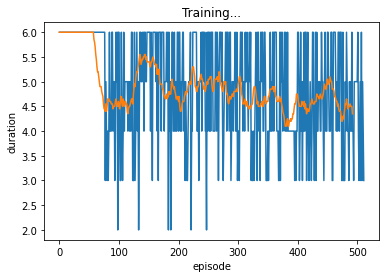

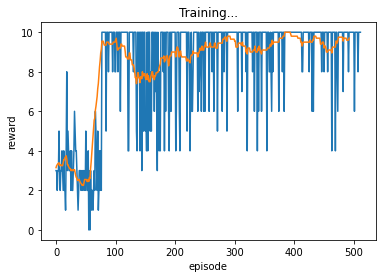

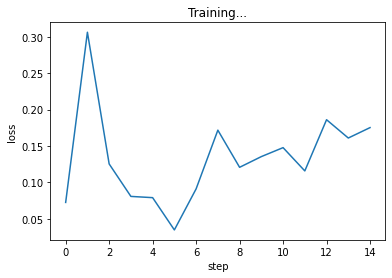

In [133]:
plot_all(*run_experiment(
    model={'name': 'nn'},
    value_function='hybrid',
    eps=[0.9, 0.05, 500],
    gamma=0.6,
    num_episodes=512,
    batch_size=64
    ))